# AFM DASHBOARD

## Load libraries

In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib ipympl

import ipywidgets as widgets
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.subplots as sp
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import itables
from itables import init_notebook_mode
from sklearn.cluster import KMeans
from IPython.display import display, HTML, clear_output
from tkinter import filedialog

from wsxm_read import *
from wsxm_analyze import *
from plot_functions import *

# init_notebook_mode(all_interactive=True)

## FILE BROWSER

In [2]:
# folderpath = filedialog.askdirectory() #use folder picker dialogbox
folderpath = '/home/pranav/Work/Data/Murcia/AFM/20240412 thiol interdigielec Sitip old'
# folderpath = 'data'
print(f'Data folder: {folderpath}')

#create folder to save dashboard output files in
outputpath = f'{folderpath}/dashboard output'
os.makedirs(outputpath, exist_ok=True)

#creates data file list contained within the folder as "datalist.pkl" & "datalist.xlsx"
#Set refresh=True to recreate file list again, else set to False to use previously created file list/create one if it doesn't exist
file_df = wsxm_collect_files(folderpath, refresh=False)

chans_list = list(file_df['channel'].unique()) #list of unique channels in all files

# List of regex patterns to ignore in header names
bad_patterns = [re.compile(r'Image \d{3}'), re.compile(r'scale,'), re.compile(r'Line \d{1}'), re.compile(r'-- None --'),
                re.compile(r'color'), re.compile(r'Header sections'), re.compile(r'style')] 
#generate unique header list
header_unique_names = np.unique(np.concatenate(file_df['header names'].to_list()))
mask = np.vectorize(lambda s: not any(pattern.search(s) for pattern in bad_patterns))(header_unique_names) # Use numpy's vectorize with a lambda function to create a boolean mask
header_unique_names = header_unique_names[mask] # Filter the original array with the boolean mask
# header_unique_names = [name if name not in chans_list else name + "1" for name in header_unique_names]
file_df.drop(columns= ['header names'], inplace=True)

#File Viewer Dashboard
data_type_button = widgets.ToggleButtons(options=['all','1D', '2D', '3D'],
                                         disabled=False)
channel_view_select = widgets.SelectMultiple(options=chans_list, description='channels',
                                             value=['Topography' if 'Topography' in chans_list else chans_list[0]])
header_select = widgets.SelectMultiple(options=header_unique_names, value=[header_unique_names[0]], description='header')
table_type_button = widgets.ToggleButtons(options=['full', 'summary'], value='summary',
                                         disabled=False)
data_type_button.value = '2D'
dash0_output = widgets.Output()
dash0_box1 = widgets.HBox([table_type_button, data_type_button])
dash0_box2 = widgets.HBox([channel_view_select, header_select])

@dash0_output.capture()
def dash0_update_summarytable(change):
    table_type = table_type_button.value
    if table_type == 'summary':
        view_channels = list(channel_view_select.value) #['Topography', 'Normal force', 'Excitation frequency', 'Adhesion']
        data_type = data_type_button.value
        df_list = []
        for key in file_df['file'].unique():
            for chan in view_channels:
                if data_type == 'all':
                    file_df_filter = file_df.loc[(file_df.file==key) & (file_df.channel==chan)]
                else:
                    file_df_filter = file_df.loc[(file_df.type==data_type) & (file_df.file==key) & (file_df.channel==chan)]
                if file_df_filter.size!=0:                    
                    df_list.append(file_df_filter.sort_values(by=['name'], ascending=False).iloc[0]) #first file (forward dir)
        if len(df_list) == 0:
            dash0_output.clear_output()
        else:
            file_df2 = pd.concat(df_list, axis=1).transpose()
            #remame column name if it is same as a channel name (eg Amplitude)
            header_names_edit = [name if name not in chans_list else f'{name}1' for name in list(header_select.value)]
            file_info_cols = ['size','resolution'] + header_names_edit #list(header_select.value)
            column_group = ['file', 'type'] + file_info_cols
            file_df_pivot = file_df2.pivot_table(columns='channel', values='plot', 
                                                  index=column_group,
                                                 aggfunc='min').reset_index()
            file_df_mintime = file_df2.groupby(column_group)['time'].min().reset_index()
            file_df_summary = pd.merge(file_df_pivot, file_df_mintime, on=column_group)
            file_df_summary = file_df_summary.reindex(['file'] + view_channels + file_info_cols + ['time'], axis=1)
            file_df_summary.sort_values(by=['file'], inplace=True)
            file_df_summary.dropna(inplace=True) #only show rows which contain images of all selected channels
            dash0_output.clear_output(wait=True)
            with dash0_output:
                itables.show(file_df_summary, classes="display")

@dash0_output.capture()
def dash0_update_tabletype(change):
    table_type = table_type_button.value
    if table_type == 'full':
        dash0_output.clear_output()
        with dash0_output:
            itables.show(file_df, column_filters = "footer", layout={"topEnd": None})
        dash0_box2.layout.display='none'
    if table_type == 'summary':
        dash0_update_summarytable(None)
        dash0_box2.layout.display=None

@dash0_output.capture()
def dash0_update_header(change):
    header_selection = header_select.value
    for header_i in header_selection:
        if header_i not in file_df.columns:
            #remame column name if it is same as a channel name (eg Amplitude)
            col_name = header_i if header_i not in chans_list else f'{header_i}1'
            file_df.insert(len(file_df.columns)-1, col_name, None)
            for i in file_df.index:
                if header_i in file_df.loc[i,'header'].keys():
                    file_df.loc[i, col_name] = file_df.loc[i, 'header'][header_i]
                else:
                    file_df.loc[i, col_name] = ''
    # itables.show(file_df)
    dash0_update_tabletype(None)


data_type_button.observe(dash0_update_summarytable, 'value')
channel_view_select.observe(dash0_update_summarytable, 'value')
header_select.observe(dash0_update_header, 'value')
table_type_button.observe(dash0_update_tabletype, 'value')

display(dash0_box1)
display(dash0_box2)
display(dash0_output)
dash0_update_header(None)
# table_type_button.value = 'summary'
# dash0_update_summarytable(None)
# with dash0_output:
#     itables.show(file_df, column_filters = "header", layout={"topEnd": None})
# box1.layout.display='none'


Data folder: /home/pranav/Work/Data/Murcia/AFM/20240412 thiol interdigielec Sitip old


Output()

## AFM CALIBRATION

### Thermal noise method

In [3]:
#Calibrate Amplitude in nm/V from thermal noise images (laser on/off)

# files = ['thermalcalib_laseroff_0000', 'thermalcalib_laseroff_0001', 'thermalcalib_laseroff_0002','thermalcalib_laseroff_0003', 'thermalcalib_laseroff_0004',
#         'thermalcalib_laseron_0000', 'thermalcalib_laseron_0001', 'thermalcalib_laseron_0002', 'thermalcalib_laseron_0003', 'thermalcalib_laseron_0004']
file_paths = list(filedialog.askopenfilenames(title='Choose thermal noise image files', 
                                              initialdir=folderpath, filetypes=(('amplitude channel', '*.ch15'),)))
file_keys = []
for file_path_i in file_paths: #find the list of unique file keyword names
    file_name_i = os.path.basename(file_path_i)
    file_keys.append(file_df[file_df['name']==file_name_i]['file'].iloc[0])
files = list(dict.fromkeys(file_keys))

chan = 'Amplitude'
chan_dir = 'Forward'

calib_data_dict = {'plot': [], 'file':[], 'direction':[], 'frequency':[], 'psd':[], 'psd max':[], 'zrms':[], 'gain in':[]}
files_skipped = []
for file_i in files:
    filepath_i = folderpath + '/' + file_df.loc[(file_df.file==file_i)].iloc[0].loc['name']
    data_i = wsxm_readchan(filepath_i, all_files=True, mute=True)
    for chan_dir in data_i[chan].keys():
        chan_data_i = data_i[chan][chan_dir]
        if chan_data_i['header']['Z Amplitude'].split(' ')[1] != 'V':
            files_skipped.append(file_i)
            # print('RAW DATA NOT IN VOLTS! Skipping:', file_i, chan, chan_dir)
            continue
        freq_i, psd_i, psdmax_i, zrms_i, fig_i = get_psd_calib(chan_data_i)
        calib_data_dict['file'].append(file_i)
        calib_data_dict['direction'].append(chan_dir)
        calib_data_dict['frequency'].append(freq_i)
        calib_data_dict['psd'].append(psd_i)
        calib_data_dict['psd max'].append(psdmax_i)
        calib_data_dict['zrms'].append(zrms_i)
        calib_data_dict['plot'].append(fig_i)
        calib_data_dict['gain in'].append(int(chan_data_i['header']['Gain in']))
        
calib_df = pd.DataFrame(calib_data_dict)

#assort files into "laser on" and "laser off" groups using kmeans clustering algo on max of psd value
rms_values = calib_df['psd max'].values.reshape(-1,1)
kmeans = KMeans(n_clusters=2) # Create a KMeans instance with 2 clusters: kmeans
kmeans.fit(rms_values) # Fit model to your data
centroids = kmeans.cluster_centers_# Get the cluster centroids
low_cluster, high_cluster = (0, 1) if centroids[0] < centroids[1] else (1, 0) # Determine which cluster corresponds to 'low' or 'high'
calib_df['Laser'] = ['OFF' if label == low_cluster else 'ON' for label in kmeans.labels_]
calib_df_off = calib_df[calib_df['Laser'] == 'OFF'].reset_index(drop=True)
calib_df_on = calib_df[calib_df['Laser'] == 'ON'].reset_index(drop=True)
row_min = min([calib_df_on.shape[0],calib_df_off.shape[0]]) #for one-to-one map of ON and OFF files

calib_result_dict = {'Amplitude calib':[], 'Spring constant':[], 'Q factor':[], 'Amp rms':[], 
                     'gain in':[], 'file_on': [], 'file_off': [], 'plot': []}
for i in range(row_min):
    ampcali_i, kcant_i, qfac_i, amprms_i, plot_i = get_calib(calib_df_on,calib_df_off,i)
    calib_result_dict['Amplitude calib'].append(ampcali_i)
    calib_result_dict['Spring constant'].append(kcant_i)
    calib_result_dict['Q factor'].append(qfac_i)
    calib_result_dict['Amp rms'].append(amprms_i)
    calib_result_dict['plot'].append(plot_i)
    calib_result_dict['gain in'].append(calib_df_on['gain in'].iloc[i])
    calib_result_dict['file_on'].append(calib_df_on['file'].iloc[i])
    calib_result_dict['file_off'].append(calib_df_off['file'].iloc[i])
calib_result_df = pd.DataFrame(calib_result_dict)


calib_summary = pd.DataFrame({'Mean': calib_result_df.drop(columns=['plot', 'gain in','file_on','file_off']).mean(),
                              'Standard Deviation': calib_result_df.drop(columns=['plot', 'gain in', 'file_on', 'file_off']).std()
                              })

#set calibration dictionary
CALIB_DICT['Amplitude']['nm']['factor'] = calib_summary['Mean'].loc['Amplitude calib']

if len(files_skipped) != 0:
    print('SOME RAW DATA NOT IN VOLTS! Skipped:', '; '.join(files_skipped))
itables.show(calib_summary)
itables.show(calib_result_df)
# itables.show(calib_df.drop(columns=['frequency', 'psd']))

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by KMeans.

### Force-distance method


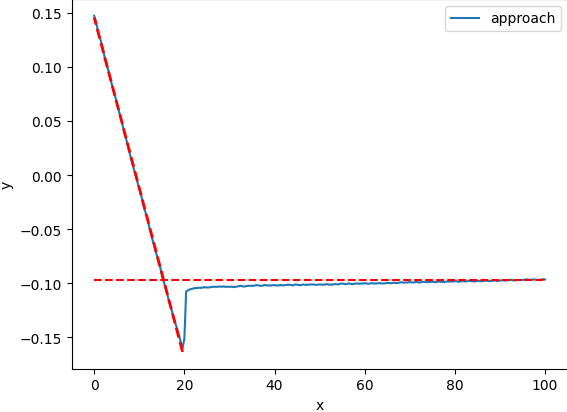
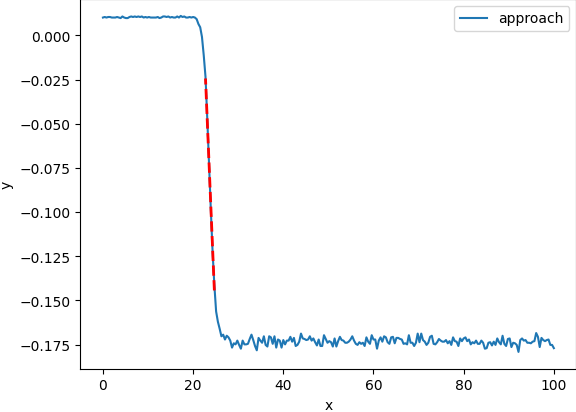
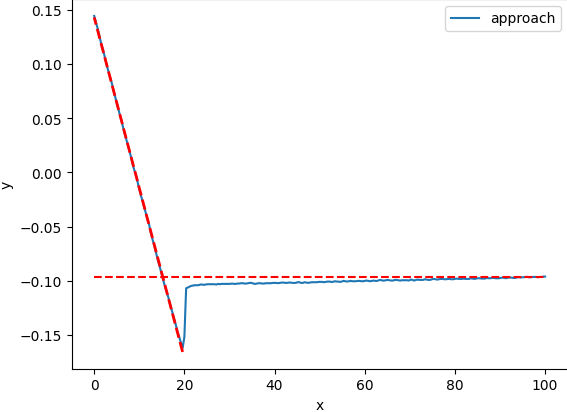
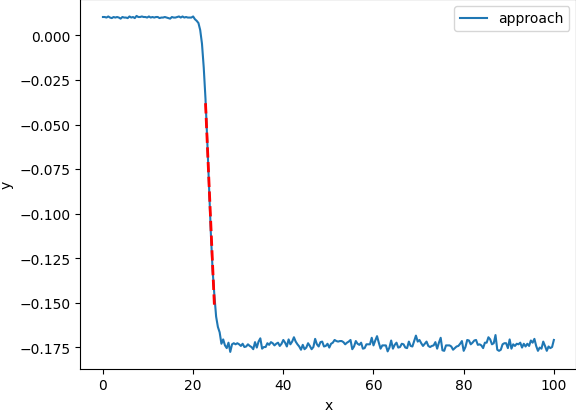
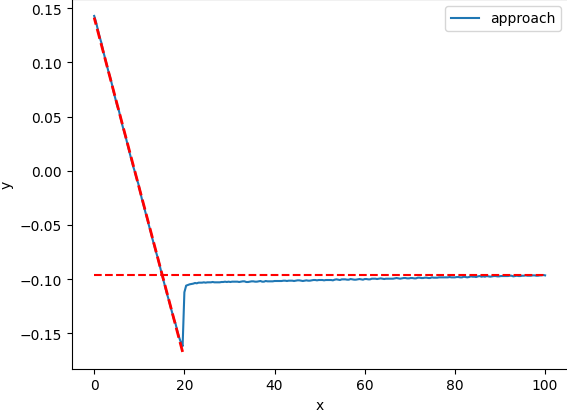
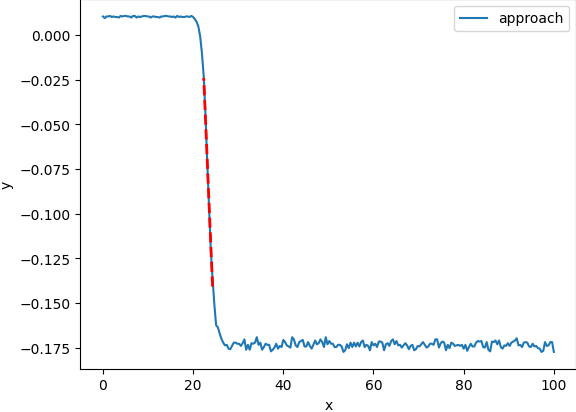
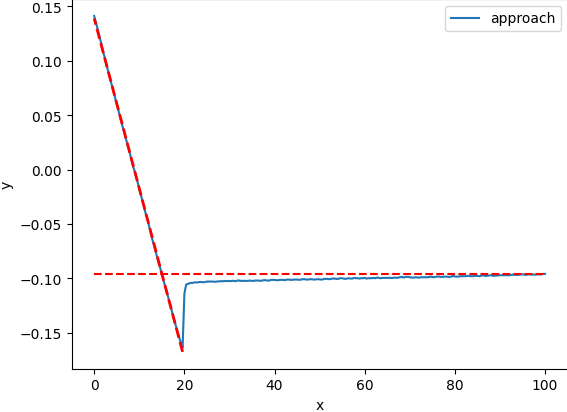
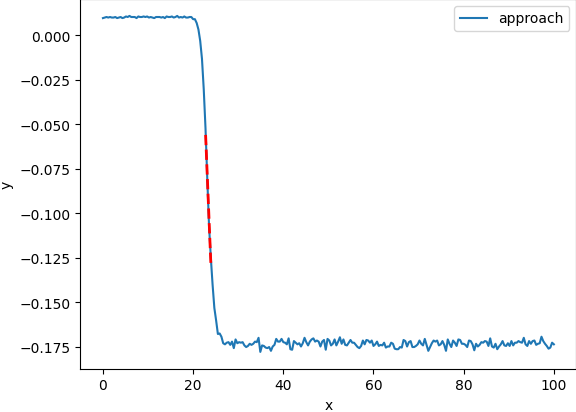
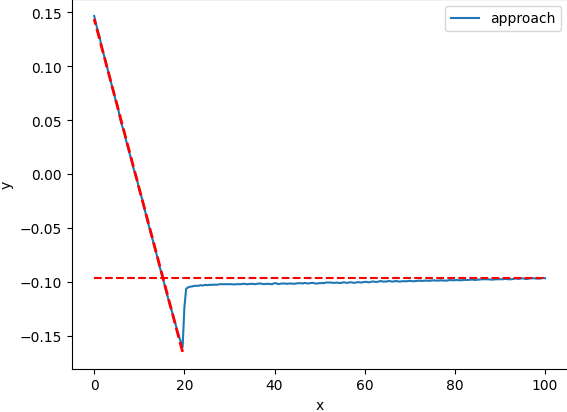
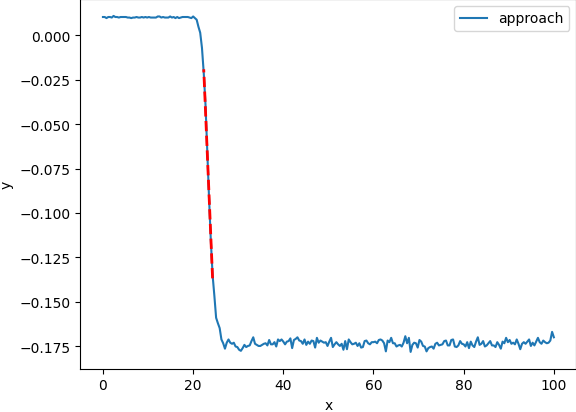
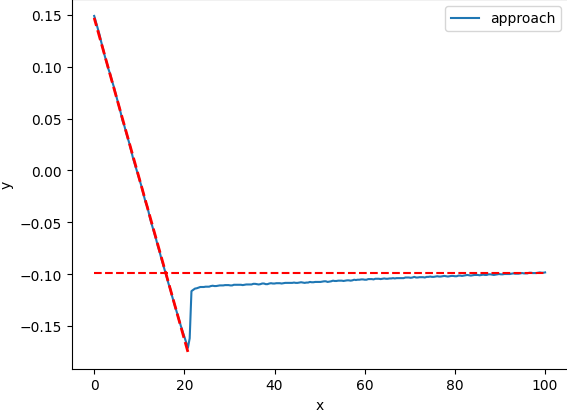
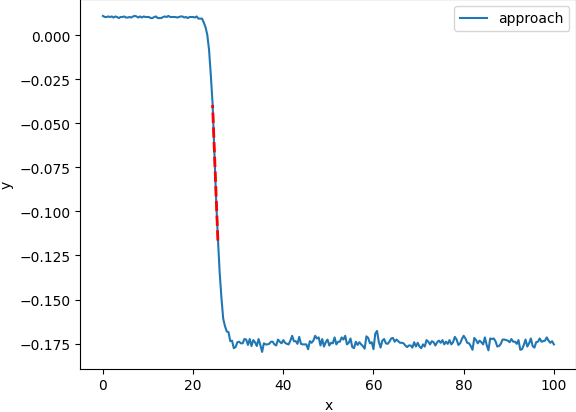
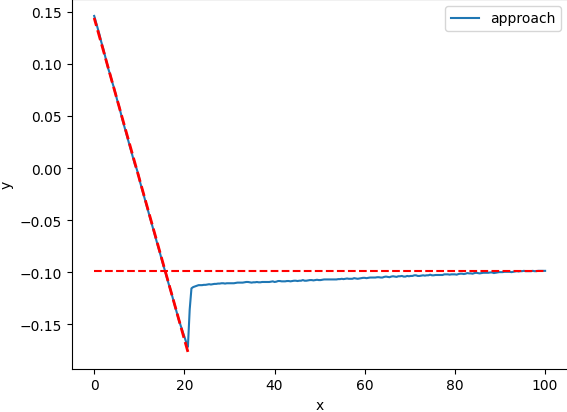
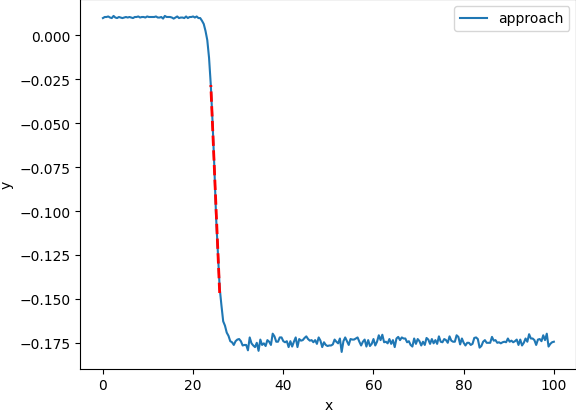
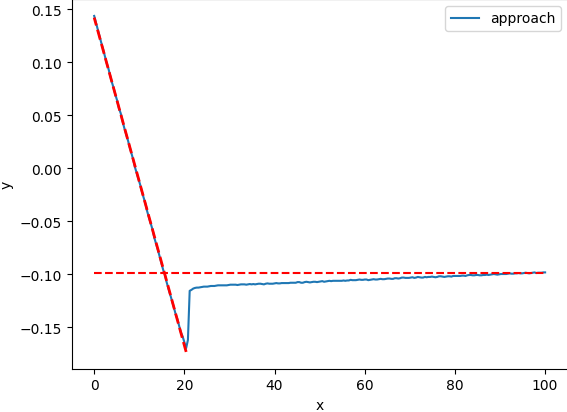
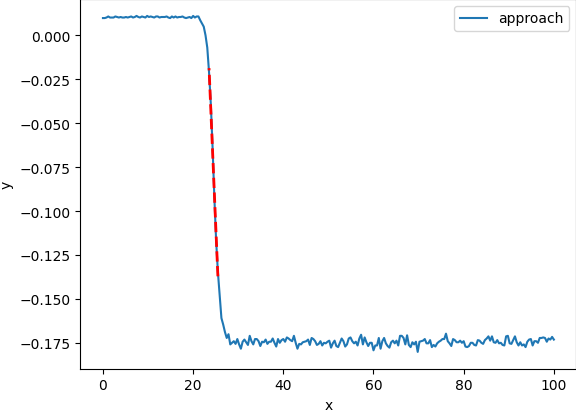
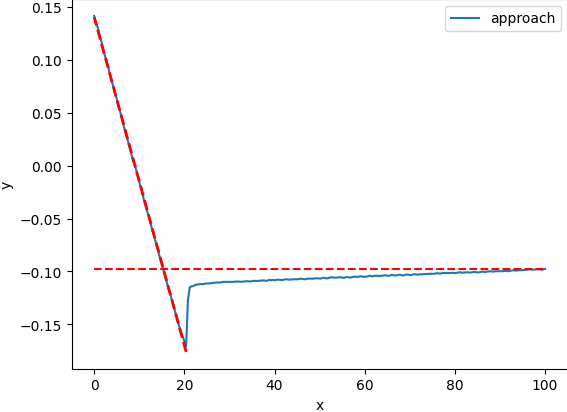
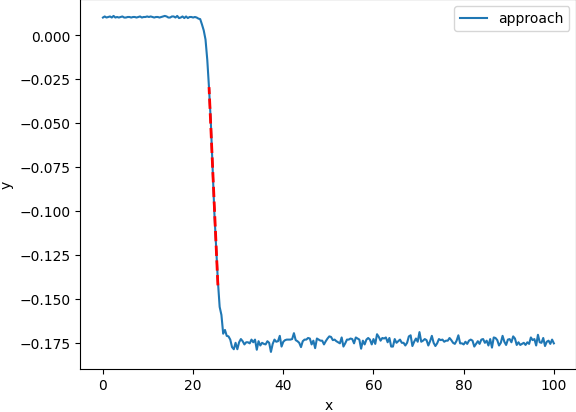
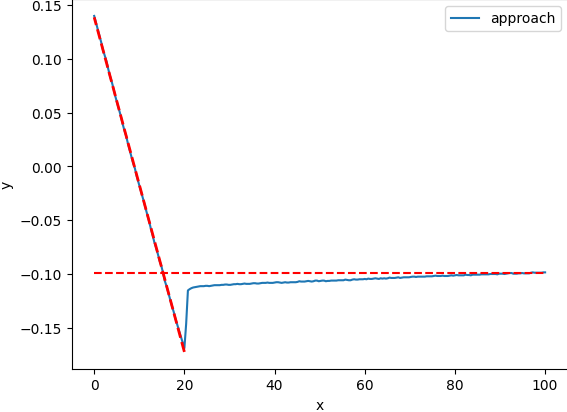
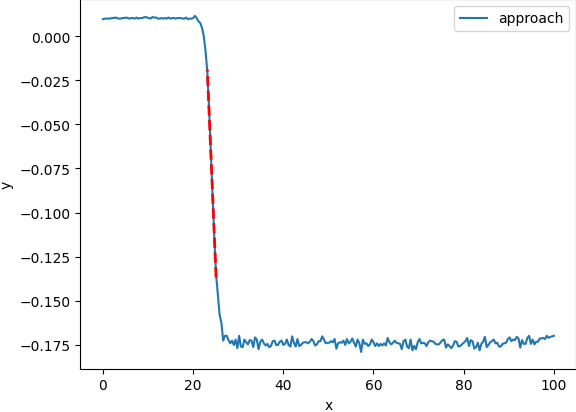
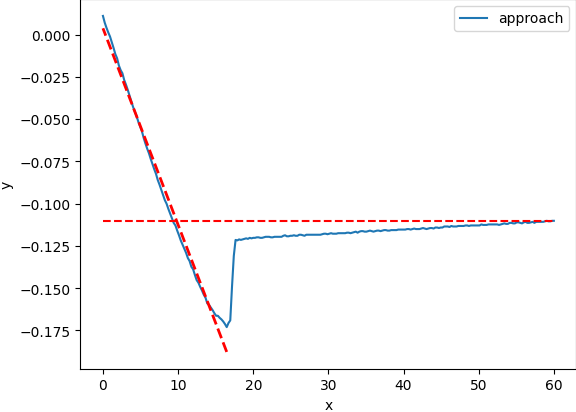
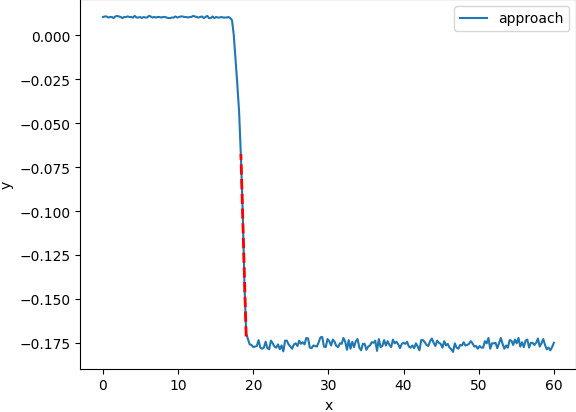
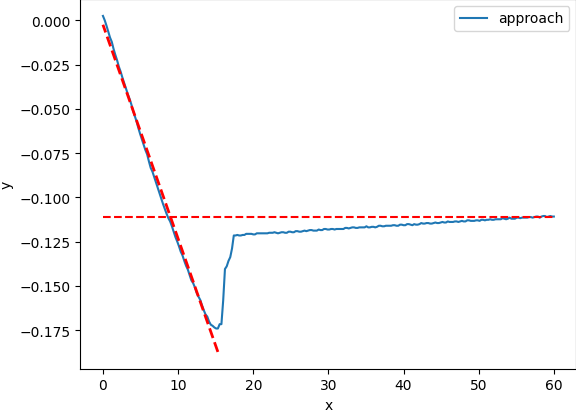
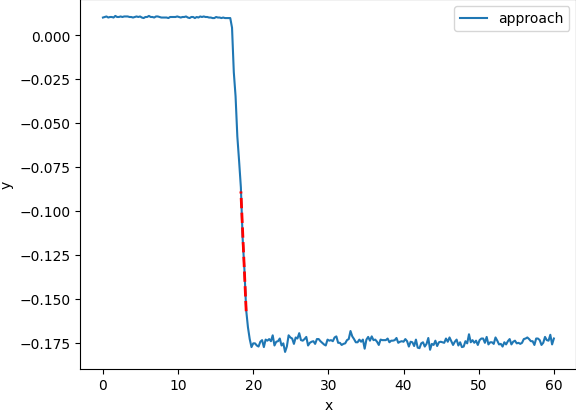
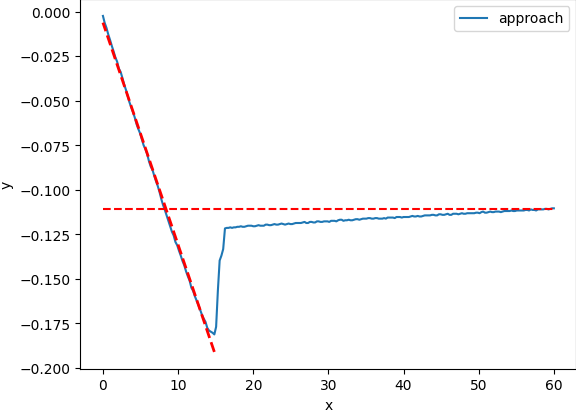
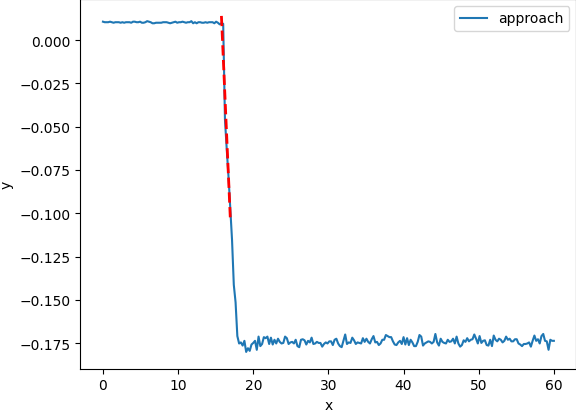
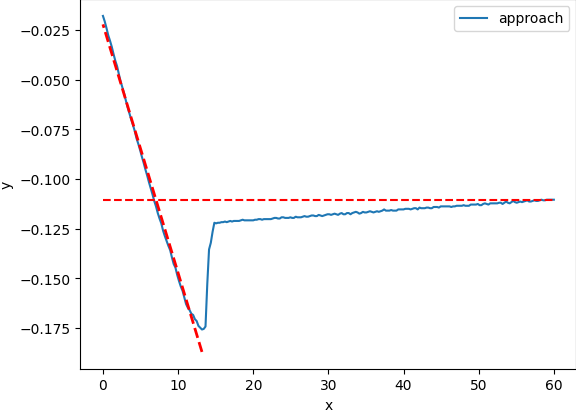
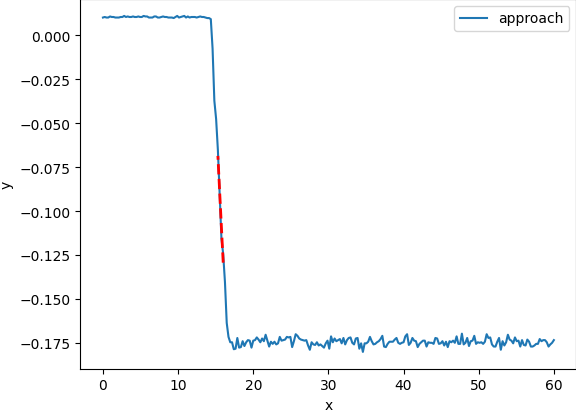
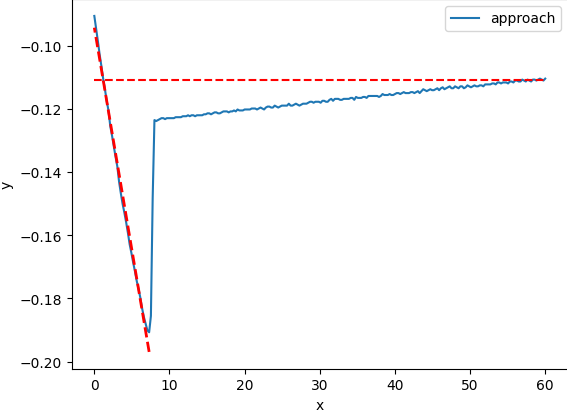
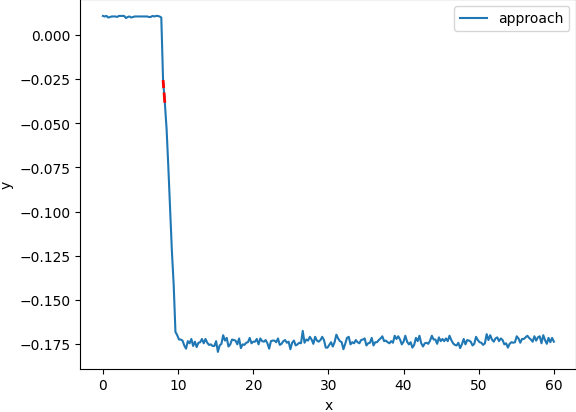
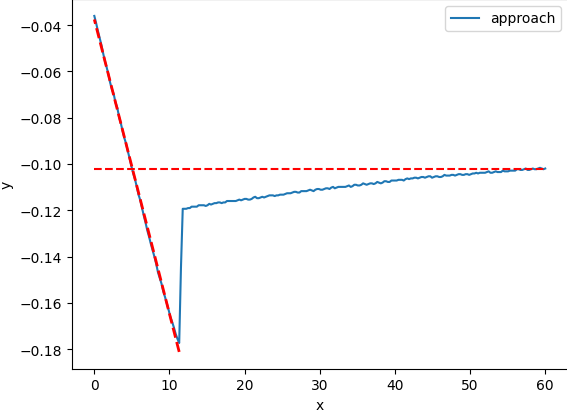
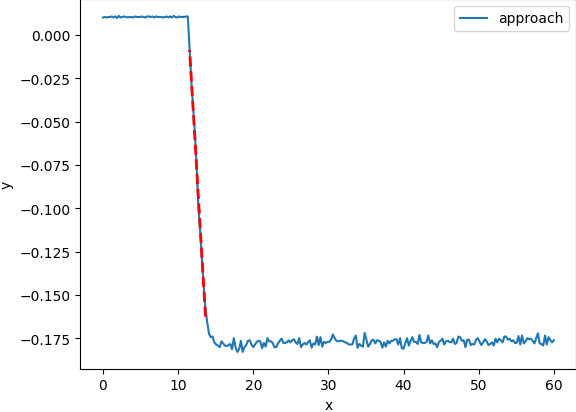
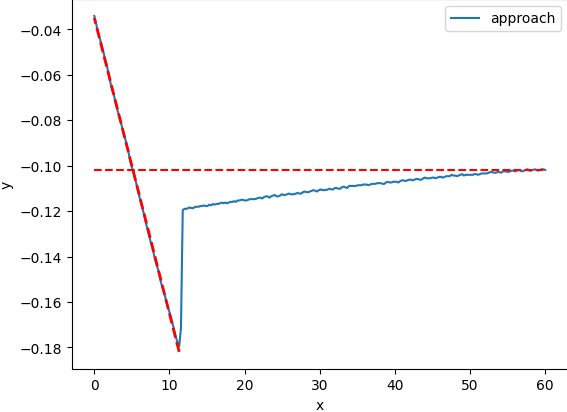
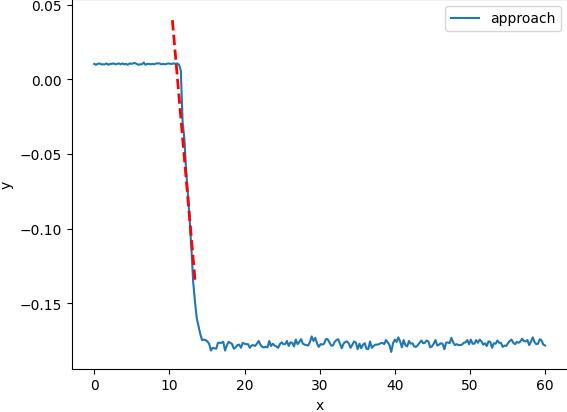
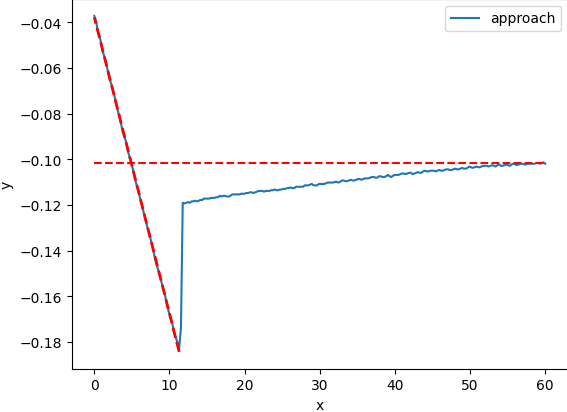
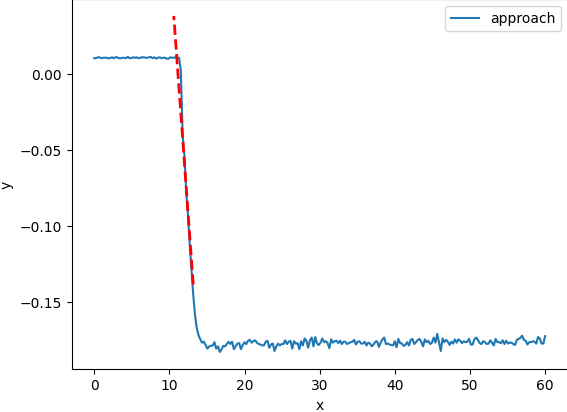
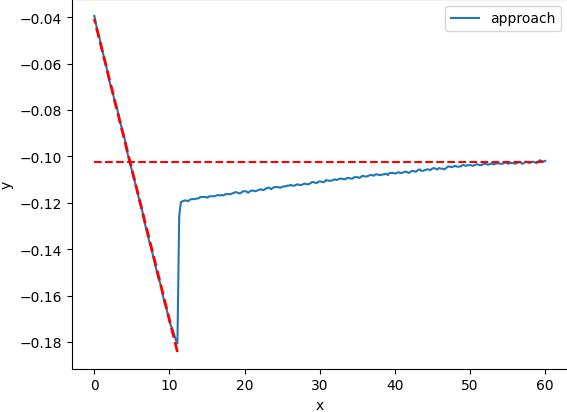
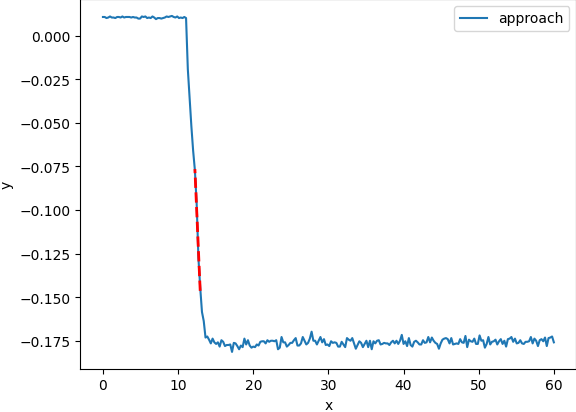
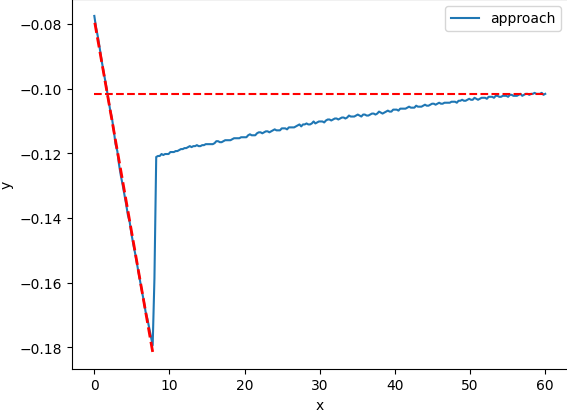
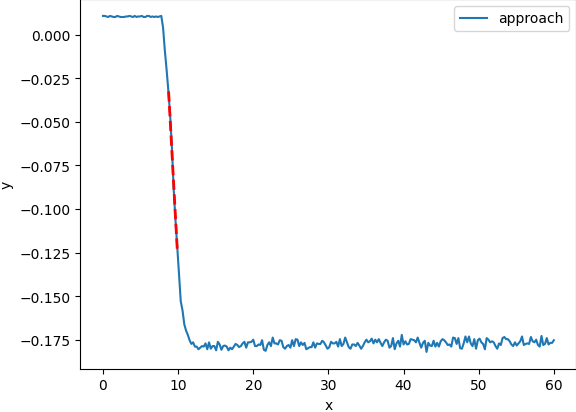

In [4]:
#Calibrate normal force and amplitude from spectroscopy curves

file_paths = list(filedialog.askopenfilenames(title='Choose spectroscopy file', 
                                              initialdir=folderpath, filetypes=(('spectroscopy data',['*.curves','*.cur','*.stp','*.curve']),)))
file_keys = []
for file_path_i in file_paths: #find the list of unique file keyword names
    file_name_i = os.path.basename(file_path_i)
    file_keys.append(file_df[file_df['name']==file_name_i]['file'].iloc[0])
files = list(dict.fromkeys(file_keys))
# files = ['interdigThiols_tipSi3nN_a_0003', 'interdigThiols_tipSi3nN_a_0005']

# chan = 'Normal force'
spec_dir = 'approach'

calib_spectro_dict = {'normal force calib':[], 'amplitude calib':[], 'file':[], 'curve num':[], 'plot normf': [], 'plot amp': []}
for file_i in files:
    filepath_i = folderpath + '/' + file_df.loc[(file_df.file==file_i)].iloc[0].loc['name']
    # filename_i = os.path.basename(filepath_i)
    data_i = wsxm_readspectra(filepath_i, all_files=True, mute=True)
    # for chan_dir in data_i[chan].keys():
    curve_numlist = data_i['Normal force']['curves'].keys()
    for curv_ind in curve_numlist:
        spectro_data_i = data_i['Normal force']['curves'][curv_ind]['data']
        #normal force calibration
        spectrodf_i, spectroparam_i = wsxm_calcspectroparam(spectro_data_i, 'Normal force', unit='V')
        if spectroparam_i['Stiffness']['value'] != 0:
            defl_calib = 1/spectroparam_i['Stiffness']['value'] #cantilever deflection calibration in nm/V
        else:
            defl_calib = 0
            print('Normal force slope is zero. Check: ', file_i)
        fig, ax = plt.subplots()
        sns.lineplot(data=spectrodf_i[spectrodf_i['segment'] == spec_dir], x="x", y="y", hue="segment", ax=ax)
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles=handles, labels=labels) #remove legend title        
        ax.hlines(spectroparam_i['Adhesion']['zero'], spectrodf_i['x'].min(), 
                   spectrodf_i['x'].max(), linestyles='dashed', colors='r')
        ax.plot(spectroparam_i['Stiffness']['x'], spectroparam_i['Stiffness']['y'],
                 'r', linestyle='dashed',linewidth=2)
        fig_i = fig2html(fig, size=200)
        plt.close()
        calib_spectro_dict['normal force calib'].append(defl_calib)
        calib_spectro_dict['plot normf'].append(fig_i)
        
        #amplitude calibration
        spectro_data_i = data_i['Amplitude']['curves'][curv_ind]['data']
        spectrodf_i, spectroparam_i = wsxm_calcspectroparam(spectro_data_i, 'Amplitude', unit='V')
        if spectroparam_i['Slope-amp']['value'] != 0:
            amp_calib = 1/spectroparam_i['Slope-amp']['value'] #amplitude calibration in nm/V
        else:
            amp_calib = 0
            print('Amp slope is zero. Check: ', file_i)
        fig, ax = plt.subplots()
        sns.lineplot(data=spectrodf_i[spectrodf_i['segment'] == spec_dir], x="x", y="y", hue="segment", ax=ax)
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles=handles, labels=labels) #remove legend title        
        ax.plot(spectroparam_i['Slope-amp']['x'], spectroparam_i['Slope-amp']['y'],
                 'r', linestyle='dashed',linewidth=2)
        fig_i = fig2html(fig, size=200)
        plt.close()
        calib_spectro_dict['amplitude calib'].append(amp_calib)
        calib_spectro_dict['plot amp'].append(fig_i)
        
        calib_spectro_dict['file'].append(file_i)
        calib_spectro_dict['curve num'].append(curv_ind)
        

calib_spectro_df = pd.DataFrame(calib_spectro_dict)

calib_spectro_summary = pd.DataFrame({'Mean': calib_spectro_df[['normal force calib', 'amplitude calib']].mean(),
                                      'Standard Deviation': calib_spectro_df[['normal force calib', 'amplitude calib']].std()
                                      })
#set calibration dictionary
#COMMENT IF YOU DONT WANT TO USE AMPLITUDE CALIBRATION FROM SPECTROSCOPY FIT
CALIB_DICT['Amplitude']['nm']['factor'] = calib_spectro_summary['Mean'].loc['amplitude calib']

CALIB_DICT['Normal force']['nm']['factor'] = calib_spectro_summary['Mean'].loc['normal force calib']
CALIB_DICT['Normal force']['nN']['factor'] = calib_spectro_summary['Mean'].loc['normal force calib']*calib_summary['Mean'].loc['Spring constant']
# print(CALIB_DICT)
itables.show(calib_spectro_summary)
itables.show(calib_spectro_df)

## FORCE-VOLUME ANALYSIS

### Load data

In [3]:
#Load WSxM force-volume data file
#filepath = 'data/20240202_laser_off_128pts_58lps_0002.f.dy.ch15'
#filepath = 'data/interdigThiols_tipSi3nN_b_0026.f.dy.top'
# filepath = 'data/interdigThiols_tipSi3nN_b_0026.fb.ch1.gsi' #ff,fb,bb,bf:1st letter=x dir,2nd letter=z dir
#filepath = 'data/interdigThiols_tipSi3nN_b_0023_Excitation frequency.f.curves'

filekey = 'interdigThiols_tipSi3nN_b_0026' #common part of file name
filepath = folderpath + '/' + file_df.loc[(file_df.file==filekey)].iloc[0].loc['name']

data_dict = wsxm_readforcevol(filepath, all_files=True, topo_only=False) #complete force volume data with all channels

#prepare and initialize data for dashboards

chan_list = list(data_dict.keys())
img_dir_list = ['Forward', 'Backward']
chan_list.remove('Topography') #only include 3d data in channel list
channel = chan_list[0] #'Excitation frequency', 'Normal force', 'Amplitude', 'Topography'
img_dir = img_dir_list[0] #'Forward' # 'Forward', 'Backward'

param_data_dict = calc_spectro_prop(data_dict)

header_dict = data_dict[channel][f'Image {img_dir} with Forward Ramps']['header']
x_num = int(header_dict['Number of rows [General Info]'])
y_num = int(header_dict['Number of columns [General Info]'])
z_num = int(header_dict['Number of points per ramp [General Info]'])
x_data = data_dict[channel][f'Image {img_dir} with Forward Ramps']['data']['X']
y_data = data_dict[channel][f'Image {img_dir} with Forward Ramps']['data']['Y']
z_data = data_dict[channel][f'Image {img_dir} with Forward Ramps']['data']['Z']
param_list = list(param_data_dict.keys()) #all calculated parameter images eg. adhesion
param_list.insert(0,'Topography')

#calculate global channel mins and maxs
chan_mins, chan_maxs = {}, {}
for chan_i in data_dict.keys():
    min_temp, max_temp = [], []
    for dir_i in data_dict[chan_i].keys():
        z_lab_i = 'Z' if chan_i == 'Topography' else 'ZZ'
        min_temp.append(data_dict[chan_i][dir_i]['data'][z_lab_i].min())
        max_temp.append(data_dict[chan_i][dir_i]['data'][z_lab_i].max())
    chan_mins[chan_i] = min(min_temp)
    chan_maxs[chan_i] = max(max_temp)

#mins and maxs of x,y,z arrays
xmin, xmax = x_data.min(), x_data.max()
ymin, ymax = y_data.min(), y_data.max()
zmin, zmax = z_data.min(), z_data.max()
# #spectroscopy
# spectro_data = wsxm_getspectro(data_dict, channel=channel, img_dir=img_dir)
# df_spectro, data_param = wsxm_calcspectroparam(spectro_data, channel)

1 interdigThiols_tipSi3nN_b_0026.bf.ch12.gsi
2 interdigThiols_tipSi3nN_b_0026.fb.ch12.gsi
3 interdigThiols_tipSi3nN_b_0026.ff.ch12.gsi
4 interdigThiols_tipSi3nN_b_0026.ff.ch1.gsi
5 interdigThiols_tipSi3nN_b_0026.bb.ch1.gsi
6 interdigThiols_tipSi3nN_b_0026.bb.ch15.gsi
7 interdigThiols_tipSi3nN_b_0026.ff.ch15.gsi
8 interdigThiols_tipSi3nN_b_0026.fb.ch15.gsi
9 interdigThiols_tipSi3nN_b_0026.bb.ch12.gsi
10 interdigThiols_tipSi3nN_b_0026.bf.ch15.gsi
11 interdigThiols_tipSi3nN_b_0026.bf.ch1.gsi
12 interdigThiols_tipSi3nN_b_0026.fb.ch1.gsi


In [6]:
param_data_dict['Adhesion']['Forward'].keys()

dict_keys(['data', 'header'])

### Data viewer

In [32]:
dash1_fig = go.FigureWidget()
specs = [[{} for _ in range(3)] for _ in range(3)]
specs[1][0] = {"secondary_y": True}
specs[2][0] = {"secondary_y": True}
sp.make_subplots(rows=3, cols=3, figure=dash1_fig, specs=specs,
                     #shared_xaxes=True, shared_yaxes=True,
                     vertical_spacing=0.05, horizontal_spacing=0.07)  
font_dict=dict(family='Arial',size=16,color='black')
dash1_fig.update_layout(#legend=dict(orientation="h",yanchor="top",y=-0.1,xanchor="center",x=0.5, font_size=18),
              font=font_dict,  # font formatting
              plot_bgcolor='white',  # background color
              barmode='overlay', #showlegend=False, 
              width=1150, height=1000,
              title='', #template='plotly_white',  #"plotly", "plotly_white", "plotly_dark", "ggplot2", "seaborn", "simple_white", "none"
              margin=dict(t=50, b=0, l=0, r=0)) 

for i in range(3):
    for j in range(3):
        # x and y-axis formatting
        dash1_fig.update_yaxes(showline=True,  # add line at x=0
                               linecolor='black',  # line color
                               linewidth=2.4, # line size
                               tickformat="~s" if j>0  or (i==0 and j==0) else None, #ticklabel number format
                               showticklabels=False if j==1 else True,
                               ticksuffix = "    " if j==2 else "",
                               ticks='outside',  # ticks outside axis
                               mirror='ticks' if j>0  or (i==0 and j==0) else True,
                               row=i+1, col=j+1)
        dash1_fig.update_xaxes(showline=True,
                               linecolor='black',
                               linewidth=2.4,
                               tickformat="~s", #ticklabel number format
                               ticks='outside',
                               mirror='ticks' if j>0  or (i==0 and j==0) else True,
                               row=i+1, col=j+1)

x_ind, y_ind, z_ind = 0, 0, 0

img_data = data_dict['Topography'][f'Image {img_dir} with Forward Ramps']
dash1_heatmap_top = plotly_heatmap(x=img_data['data']['X'],
                             y=img_data['data']['Y'],
                             z_mat=img_data['data']['Z'], style='full')
dash1_heatmap_top.data[0].coloraxis = 'coloraxis2'

img_data_a = data_dict[channel][f'Image {img_dir} with Forward Ramps']
img_data_r = data_dict[channel][f'Image {img_dir} with Backward Ramps']

#XZ section images
dash1_heatmap_xz_a = plotly_heatmap(x=img_data_a['data']['X'],
                             y=img_data_a['data']['Z'],
                             z_mat=img_data_a['data']['ZZ'][:,y_ind,:], style='full') #approach
dash1_heatmap_xz_a.data[0].coloraxis = 'coloraxis1'
dash1_heatmap_xz_r = plotly_heatmap(x=img_data_r['data']['X'],
                             y=img_data_r['data']['Z'],
                             z_mat=img_data_r['data']['ZZ'][:,y_ind,:], style='full') #retract
dash1_heatmap_xz_r.data[0].coloraxis = 'coloraxis1'
#YZ section images
dash1_heatmap_yz_a = plotly_heatmap(x=img_data_a['data']['Y'],
                             y=img_data_a['data']['Z'],
                             z_mat=img_data_a['data']['ZZ'][:,:,x_ind], style='full') #approach
dash1_heatmap_yz_a.data[0].coloraxis = 'coloraxis1'
dash1_heatmap_yz_r = plotly_heatmap(x=img_data_r['data']['Y'],
                             y=img_data_r['data']['Z'],
                             z_mat=img_data_r['data']['ZZ'][:,:,x_ind], style='full') #retract
dash1_heatmap_yz_r.data[0].coloraxis = 'coloraxis1'
#XY section images
dash1_heatmap_xy_a = plotly_heatmap(x=img_data_a['data']['X'],
                             y=img_data_a['data']['Y'],
                             z_mat=img_data_a['data']['ZZ'][z_ind,:,:], style='full') #approach
dash1_heatmap_xy_a.data[0].coloraxis = 'coloraxis1'
dash1_heatmap_xy_r = plotly_heatmap(x=img_data_r['data']['X'],
                             y=img_data_r['data']['Y'],
                             z_mat=img_data_r['data']['ZZ'][z_ind,:,:], style='full') #retract
dash1_heatmap_xy_r.data[0].coloraxis = 'coloraxis1'


#spectroscopy
spectro_data = wsxm_getspectro(data_dict, channel=channel, img_dir=img_dir, x=xmin, y=ymin)
df_spectro, data_param = wsxm_calcspectroparam(spectro_data, channel, unit='V')
line_spec = plotly_lineplot(data=df_spectro,  x="x", y="y", color="segment")

xx_v, yy_v = get_imgline(data_dict['Topography'][f'Image {img_dir} with Forward Ramps'],x=xmin)
# line_top_x = ax[2][0].plot(xx,yy,color=color_list[0]) #vertical
# ax_top_y = ax[2][0].twinx()
xx_h, yy_h = get_imgline(data_dict['Topography'][f'Image {img_dir} with Forward Ramps'],y=ymin)
df_topoline = pd.DataFrame({'x':np.append(xx_v, xx_h), 'y':np.append(yy_v, yy_h), 
                          'line': ['v']*len(xx_v)+['h']*len(xx_h)})
line_topo = plotly_lineplot(data=df_topoline,  x="x", y="y", color="line")

        
dash1_fig.add_trace(dash1_heatmap_top.data[0], row=1, col=1) #data[0]
dash1_fig.add_trace(dash1_heatmap_yz_a.data[0], row=1, col=2) #data[1]
dash1_fig.add_trace(dash1_heatmap_yz_r.data[0], row=1, col=3) #data[2]
dash1_fig.add_trace(dash1_heatmap_xz_a.data[0], row=2, col=2) #data[3]
dash1_fig.add_trace(dash1_heatmap_xz_r.data[0], row=2, col=3) #data[4]
dash1_fig.add_trace(dash1_heatmap_xy_a.data[0], row=3, col=2) #data[5]
dash1_fig.add_trace(dash1_heatmap_xy_r.data[0], row=3, col=3) #data[6]
dash1_fig.add_trace(line_spec.data[0], row=2, col=1) #data[7]
dash1_fig.add_trace(line_spec.data[1], row=2, col=1, secondary_y=True) #data[8]
dash1_fig.add_trace(line_topo.data[0], row=3, col=1) #data[9]
dash1_fig.add_trace(line_topo.data[1], row=3, col=1, secondary_y=True) #data[10]

dash1_fig.add_hline(y=ymin, line_color="red", line_width=2,
              visible=True, row=1,col=1)
dash1_fig.add_vline(x=xmin, line_color="blue", line_width=2,
              visible=True, row=1,col=1)

dash1_fig.update_layout({'legend1': dict(y=dash1_fig.layout.yaxis4.domain[1], x=dash1_fig.layout.xaxis4.domain[1],
                                         bgcolor='rgba(0,0,0,0)', tracegroupgap=0,
                                     xanchor="right", yanchor="top")}, showlegend=True)
dash1_fig.update_traces(row=2, col=1, legend='legend1')
dash1_fig.update_layout({'legend2': dict(y=dash1_fig.layout.yaxis8.domain[1], x=dash1_fig.layout.xaxis7.domain[1],
                                         bgcolor='rgba(0,0,0,0)', tracegroupgap=0,
                                     xanchor="right", yanchor="top")}, showlegend=True)
dash1_fig.update_traces(row=3, col=1, legend='legend2')


dash1_fig.update_layout(coloraxis1=dict(colorscale=cm_afmhot,#cmin=68500, cmax=69600,
                                 colorbar=dict(len=0.6, x=0.65, y=1, thickness=15,
                                               orientation='h', xanchor='center', 
                                               yanchor='bottom')),
                       coloraxis2=dict(colorscale=cm_afmhot,#cmin=-50, cmax=200,
                                 colorbar=dict(len=0.26, x=0.14, y=1, thickness=10,
                                              orientation='h',yanchor='bottom',
                                               xanchor='center',thicknessmode="pixels"#,tickformat="~s" 
                                              )))

# dash1_fig.layout.coloraxis2.cmin = 50
# dash1_fig.layout.coloraxis2.cmax = 100

#widgets
dash1_slide_x = widgets.IntSlider(value=xmin, min=xmin, max=xmax, step=(xmax-xmin)/x_num,
                            description='x')
dash1_slide_y = widgets.IntSlider(value=ymin, min=ymin, max=ymax, step=(ymax-ymin)/y_num,
                            description='y')
dash1_slide_z = widgets.IntSlider(value=zmin, min=zmin, max=zmax, step=(zmax-zmin)/z_num,
                            description='z')
dash1_slide_zrange = widgets.IntSlider(value=zmax, min=zmin, max=zmax, step=(zmax-zmin)/z_num,
                            description='z limit')
dash1_slide_cb = widgets.FloatRangeSlider(value=[chan_mins[channel], chan_maxs[channel]], 
                                    min=chan_mins[channel], max=chan_maxs[channel], 
                                    step=(chan_maxs[channel]-chan_mins[channel])/100,
                                    description='color',readout=True)
dash1_chan_button = widgets.ToggleButtons(options=chan_list,
                                          layout=widgets.Layout(width='200px'),
                                    # description='Channel:',
                                     disabled=False)
dash1_imgdir_button = widgets.ToggleButtons(options=['Forward', 'Backward'],
                                            layout=widgets.Layout(width='200px'),
                                    # description='Channel:',
                                     disabled=False)
dash1_param_dropdown = widgets.Dropdown(options=param_list,
                                  value='Topography',disabled=False,
                                       layout=widgets.Layout(width='200px'))
dash1_output = widgets.Output()
dash1_box2 = widgets.VBox([dash1_slide_x, dash1_slide_y, dash1_slide_z])
dash1_box1 = widgets.VBox([dash1_param_dropdown, dash1_imgdir_button])
dash1_box3 = widgets.VBox([dash1_slide_zrange, dash1_slide_cb])
dash1_box4 = widgets.HBox([dash1_box1, dash1_chan_button, dash1_box2, dash1_box3])

#update functions

@dash1_output.capture()
def dash1_update_x(change):
    
    x_pt = dash1_slide_x.value
    y_pt = dash1_slide_y.value
    img_dir = dash1_imgdir_button.value
    channel = dash1_chan_button.value
    channel_top = dash1_param_dropdown.value
    # vmin, vmax = dash1_slide_cb.value
    
    #update position lines
    dash1_fig.layout.shapes = [{
                         'line': {'color': 'red', 'width': 2},
                         'type': 'line',
                         'visible': True,
                         'x0': 0,
                         'x1': 1,
                         'xref': 'x domain',
                         'y0': y_pt,
                         'y1': y_pt,
                         'yref': 'y'
                     },
                     {
                         'line': {'color': 'blue', 'width': 2},
                         'type': 'line',
                         'visible': True,
                         'x0': x_pt,
                         'x1': x_pt,
                         'xref': 'x',
                         'y0': 0,
                         'y1': 1,
                         'yref': 'y domain'
                     }]
    
    img_data_a = data_dict[channel][f'Image {img_dir} with Forward Ramps']
    img_data_r = data_dict[channel][f'Image {img_dir} with Backward Ramps']
    
    x_ind_a = np.argmin(abs(img_data_a['data']['X']-x_pt))
    x_ind_r = np.argmin(abs(img_data_r['data']['X']-x_pt))
    
    dash1_fig.data[1].z = img_data_a['data']['ZZ'][:,:,x_ind_a]
    dash1_fig.data[2].z = img_data_r['data']['ZZ'][:,:,x_ind_r]
    
    spectro_data = wsxm_getspectro(data_dict, channel=channel, img_dir=img_dir, x= x_pt, y=y_pt)
    for fig_data in [dash1_fig.data[7], dash1_fig.data[8]]:
        fig_data.x = spectro_data[fig_data.name]['x'] 
        fig_data.y = spectro_data[fig_data.name]['y']

    if channel_top == 'Topography':
        xx_v, yy_v = get_imgline(data_dict[channel_top][f'Image {img_dir} with Forward Ramps'], x=y_pt)
    else:
        xx_v, yy_v = get_imgline(param_data_dict[channel_top][img_dir], x=x_pt)
    
    for fig_data in [dash1_fig.data[9], dash1_fig.data[10]]:
        if fig_data.name == 'v':
            fig_data.x = xx_v
            fig_data.y = yy_v
            # break


@dash1_output.capture()
def dash1_update_y(change):
    x_pt = dash1_slide_x.value
    y_pt = dash1_slide_y.value
    img_dir = dash1_imgdir_button.value
    channel = dash1_chan_button.value
    channel_top = dash1_param_dropdown.value
    # vmin, vmax = dash1_slide_cb.value
    
    #update position lines
    dash1_fig.layout.shapes = [{
                         'line': {'color': 'red', 'width': 2},
                         'type': 'line',
                         'visible': True,
                         'x0': 0,
                         'x1': 1,
                         'xref': 'x domain',
                         'y0': y_pt,
                         'y1': y_pt,
                         'yref': 'y'
                     },
                     {
                         'line': {'color': 'blue', 'width': 2},
                         'type': 'line',
                         'visible': True,
                         'x0': x_pt,
                         'x1': x_pt,
                         'xref': 'x',
                         'y0': 0,
                         'y1': 1,
                         'yref': 'y domain'
                     }]
    
    img_data_a = data_dict[channel][f'Image {img_dir} with Forward Ramps']
    img_data_r = data_dict[channel][f'Image {img_dir} with Backward Ramps']
    
    y_ind_a = np.argmin(abs(img_data_a['data']['Y']-y_pt))
    y_ind_r = np.argmin(abs(img_data_r['data']['Y']-y_pt))
    
    dash1_fig.data[3].z = img_data_a['data']['ZZ'][:,y_ind_a,:]
    dash1_fig.data[4].z = img_data_r['data']['ZZ'][:,y_ind_r,:]

    
    spectro_data = wsxm_getspectro(data_dict, channel=channel, img_dir=img_dir, x= x_pt, y=y_pt)
    # df_spectro, data_param = wsxm_calcspectroparam(spectro_data, channel, unit='V')
    for fig_data in [dash1_fig.data[7], dash1_fig.data[8]]:
        fig_data.x = spectro_data[fig_data.name]['x'] 
        fig_data.y = spectro_data[fig_data.name]['y']

    if channel_top == 'Topography':
        xx_h, yy_h = get_imgline(data_dict[channel_top][f'Image {img_dir} with Forward Ramps'], y=y_pt)
    else:
        xx_h, yy_h = get_imgline(param_data_dict[channel_top][img_dir], y=y_pt)
    
    for fig_data in [dash1_fig.data[9], dash1_fig.data[10]]:
        if fig_data.name == 'h':
            fig_data.x = xx_h
            fig_data.y = yy_h


@dash1_output.capture()
def dash1_update_z(change):
    img_dir = dash1_imgdir_button.value
    channel = dash1_chan_button.value
    z_pt = dash1_slide_z.value
    # vmin, vmax = dash1_slide_cb.value
    
    img_data_a = data_dict[channel][f'Image {img_dir} with Forward Ramps']
    img_data_r = data_dict[channel][f'Image {img_dir} with Backward Ramps']
    
    z_ind_a = np.argmin(abs(img_data_a['data']['Z']-z_pt))
    z_ind_r = np.argmin(abs(img_data_r['data']['Z']-z_pt))
    
    dash1_fig.data[5].z = img_data_a['data']['ZZ'][z_ind_a,:,:]
    dash1_fig.data[6].z = img_data_r['data']['ZZ'][z_ind_r,:,:]
    
@dash1_output.capture()
def dash1_update_zrange(change):
    z_new = change.new
    dash1_fig.update_layout(yaxis2_range=[zmin, z_new])
    dash1_fig.update_layout(yaxis3_range=[zmin, z_new])
    dash1_fig.update_layout(yaxis6_range=[zmin, z_new])
    dash1_fig.update_layout(yaxis7_range=[zmin, z_new])
    dash1_fig.update_layout(xaxis4_range=[zmin, z_new])

@dash1_output.capture()
def dash1_update_param(change):
    img_dir = dash1_imgdir_button.value
    channel_top = dash1_param_dropdown.value
    x_pt = dash1_slide_x.value
    y_pt = dash1_slide_y.value
    if channel_top == 'Topography':
        img_data = data_dict[channel_top][f'Image {img_dir} with Forward Ramps']
        xx_v, yy_v = get_imgline(data_dict[channel_top][f'Image {img_dir} with Forward Ramps'], x=y_pt)
        xx_h, yy_h = get_imgline(data_dict[channel_top][f'Image {img_dir} with Forward Ramps'], y=y_pt)
    else:
        img_data = param_data_dict[channel_top][img_dir]
        xx_h, yy_h = get_imgline(param_data_dict[channel_top][img_dir], y=y_pt)
        xx_v, yy_v = get_imgline(param_data_dict[channel_top][img_dir], x=x_pt)

    dash1_fig.data[0].z = img_data['data']['Z']
    
    vmin = np.percentile(img_data['data']['Z'].flatten(), 1, method='midpoint')
    vmax = np.percentile(img_data['data']['Z'].flatten(), 99, method='midpoint')
    dash1_fig.layout.coloraxis2.cmin=vmin
    dash1_fig.layout.coloraxis2.cmax=vmax
    
    for fig_data in [dash1_fig.data[9], dash1_fig.data[10]]:
        if fig_data.name == 'h':
            fig_data.x = xx_h
            fig_data.y = yy_h
        elif fig_data.name == 'v':
            fig_data.x = xx_v
            fig_data.y = yy_v

@dash1_output.capture()
def dash1_update_imgdir(change):
    dash1_update_param(None)
    dash1_update_chan(None)

@dash1_output.capture()
def dash1_update_chan(change):
    channel = dash1_chan_button.value
    img_dir = dash1_imgdir_button.value
    x_pt = dash1_slide_x.value
    y_pt = dash1_slide_y.value
    z_pt = dash1_slide_z.value
    vmin, vmax = chan_mins[channel], chan_maxs[channel]
    
    dash1_fig.layout.coloraxis1.cmin=vmin
    dash1_fig.layout.coloraxis1.cmax=vmax
    
    #update position lines
    dash1_fig.layout.shapes = [{
                         'line': {'color': 'red', 'width': 2},
                         'type': 'line',
                         'visible': True,
                         'x0': 0,
                         'x1': 1,
                         'xref': 'x domain',
                         'y0': y_pt,
                         'y1': y_pt,
                         'yref': 'y'
                     },
                     {
                         'line': {'color': 'blue', 'width': 2},
                         'type': 'line',
                         'visible': True,
                         'x0': x_pt,
                         'x1': x_pt,
                         'xref': 'x',
                         'y0': 0,
                         'y1': 1,
                         'yref': 'y domain'
                     }]
    
    img_data_a = data_dict[channel][f'Image {img_dir} with Forward Ramps']
    img_data_r = data_dict[channel][f'Image {img_dir} with Backward Ramps']
    
    x_ind_a = np.argmin(abs(img_data_a['data']['X']-x_pt))
    x_ind_r = np.argmin(abs(img_data_r['data']['X']-x_pt))
    
    dash1_fig.data[1].z = img_data_a['data']['ZZ'][:,:,x_ind_a]
    dash1_fig.data[2].z = img_data_r['data']['ZZ'][:,:,x_ind_r]
    
    y_ind_a = np.argmin(abs(img_data_a['data']['Y']-y_pt))
    y_ind_r = np.argmin(abs(img_data_r['data']['Y']-y_pt))
    
    dash1_fig.data[3].z = img_data_a['data']['ZZ'][:,y_ind_a,:]
    dash1_fig.data[4].z = img_data_r['data']['ZZ'][:,y_ind_r,:]
    
    z_ind_a = np.argmin(abs(img_data_a['data']['Z']-z_pt))
    z_ind_r = np.argmin(abs(img_data_r['data']['Z']-z_pt))
    
    dash1_fig.data[5].z = img_data_a['data']['ZZ'][z_ind_a,:,:]
    dash1_fig.data[6].z = img_data_r['data']['ZZ'][z_ind_r,:,:]
    
    spectro_data = wsxm_getspectro(data_dict, channel=channel, img_dir=img_dir, x= x_pt, y=y_pt)
    for fig_data in [dash1_fig.data[7], dash1_fig.data[8]]:
        fig_data.x = spectro_data[fig_data.name]['x'] 
        fig_data.y = spectro_data[fig_data.name]['y']
    
    #reinitialize colorbar to new values of channel(works somehow)
    dash1_slide_cb.unobserve(dash1_update_colorbar, 'value')
    dash1_slide_cb.index = (0,0)
    dash1_slide_cb.min, dash1_slide_cb.max = -1e100, 1e100 #to avoid error of min, max classh from previous value
    dash1_slide_cb.step = (chan_maxs[channel]-chan_mins[channel])/100
    dash1_slide_cb.value = (chan_mins[channel], chan_maxs[channel])
    # dash1_slide_cb.min, dash1_slide_cb.max = chan_mins[channel], chan_maxs[channel]
    dash1_slide_cb.observe(dash1_update_colorbar, 'value')

@dash1_output.capture()
def dash1_update_colorbar(change):
    channel = dash1_chan_button.value
    img_dir = dash1_imgdir_button.value
    x_pt = dash1_slide_x.value
    y_pt = dash1_slide_y.value
    z_pt = dash1_slide_z.value
    vmin, vmax = change.new    
       
    if dash1_slide_cb.min != chan_mins[channel] or  dash1_slide_cb.max != chan_maxs[channel]:
        #slider reset to channel values
        dash1_slide_cb.unobserve(dash1_update_colorbar, 'value')
        dash1_slide_cb.min, dash1_slide_cb.max = -1e100, 1e100 #to avoid error of min, max classh from previous value
        dash1_slide_cb.min, dash1_slide_cb.max = chan_mins[channel], chan_maxs[channel]
        dash1_slide_cb.step = (chan_maxs[channel]-chan_mins[channel])/100
        dash1_slide_cb.value = (chan_mins[channel], chan_maxs[channel])
        dash1_slide_cb.observe(dash1_update_colorbar, 'value')
        vmin, vmax = chan_mins[channel], chan_maxs[channel]
    else:
        dash1_fig.layout.coloraxis1.cmin=vmin
        dash1_fig.layout.coloraxis1.cmax=vmax

#update x,y cordinates by clicking inside the plot
@dash1_output.capture()
def dash1_onclick(trace, points, selector):
    if len(points.point_inds) != 0:
        x_pt = points.xs[0]
        y_pt=points.ys[0]
        
        #update position lines
        dash1_fig.layout.shapes = [{
                             'line': {'color': 'red', 'width': 2},
                             'type': 'line',
                             'visible': True,
                             'x0': 0,
                             'x1': 1,
                             'xref': 'x domain',
                             'y0': y_pt,
                             'y1': y_pt,
                             'yref': 'y'
                         },
                         {
                             'line': {'color': 'blue', 'width': 2},
                             'type': 'line',
                             'visible': True,
                             'x0': x_pt,
                             'x1': x_pt,
                             'xref': 'x',
                             'y0': 0,
                             'y1': 1,
                             'yref': 'y domain'
                         }]
        dash1_slide_x.unobserve(dash1_update_x, 'value')
        dash1_slide_y.unobserve(dash1_update_y, 'value')
        dash1_slide_x.value = x_pt
        dash1_slide_y.value = y_pt
        dash1_slide_x.observe(dash1_update_x, 'value')
        dash1_slide_y.observe(dash1_update_y, 'value')
    
dash1_slide_x.observe(dash1_update_x, 'value')
dash1_slide_y.observe(dash1_update_y, 'value')
dash1_slide_z.observe(dash1_update_z, 'value')
dash1_slide_zrange.observe(dash1_update_zrange, 'value')
dash1_param_dropdown.observe(dash1_update_param, 'value')
dash1_imgdir_button.observe(dash1_update_imgdir, 'value')
dash1_chan_button.observe(dash1_update_chan, 'value')
dash1_slide_cb.observe(dash1_update_colorbar, 'value')
dash1_fig.data[0].on_click(dash1_onclick)

display(dash1_box4)
display(dash1_fig)
display(dash1_output)

FigureWidget({
    'data': [{'coloraxis': 'coloraxis2',
              'colorscale': [[0.0, 'rgb(0, 0, 0)'], [0.003937007874015748, 'rgb(2,
                             0, 0)'], [0.007874015748031496, 'rgb(4, 0, 0)'], ...,
                             [0.9921259842519685, 'rgb(255, 255, 251)'],
                             [0.9960629921259843, 'rgb(255, 255, 253)'], [1.0,
                             'rgb(255, 255, 255)']],
              'showscale': True,
              'type': 'heatmap',
              'uid': '273c2cf1-5010-4910-83ca-3a81631152c2',
              'x': array([5000.        , 4960.62992126, 4921.25984252, 4881.88976378,
                          4842.51968504, 4803.1496063 , 4763.77952756, 4724.40944882,
                          4685.03937008, 4645.66929134, 4606.2992126 , 4566.92913386,
                          4527.55905512, 4488.18897638, 4448.81889764, 4409.4488189 ,
                          4370.07874016, 4330.70866142, 4291.33858268, 4251.96850394,
                

Output()

### Compare spectroscopy curves

Output()

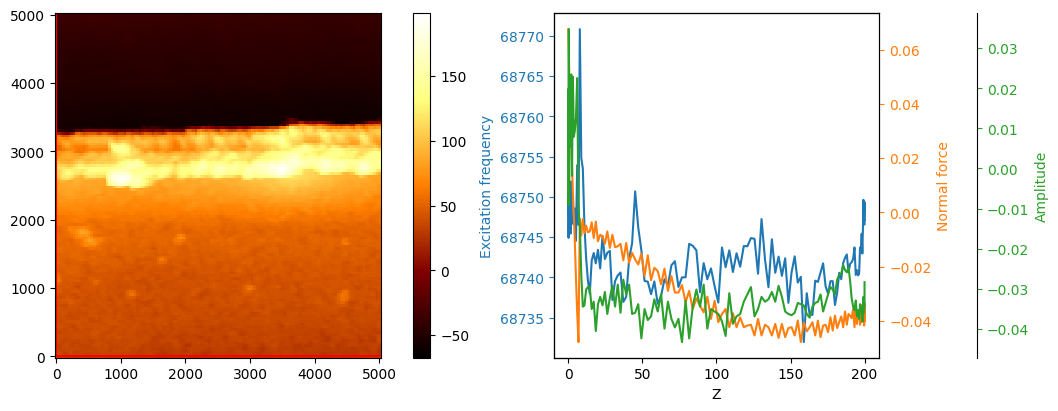

In [4]:
#close dashboard-2 figure if already open
for fignum_i in plt.get_fignums():
    figlab_i = plt.figure(fignum_i).get_label()
    if figlab_i == 'dash2':
        plt.close(figlab_i) 
    
fig2, ax2 = plt.subplots(1,2, figsize=(10.5,4), num='dash2',layout='constrained')
ax2_spec = [ax2[1], ax2[1].twinx(), ax2[1].twinx()]
ax2_spec[-1].spines['right'].set_position(('axes', 1.3))
fig2.canvas.header_visible = False
fig2.canvas.toolbar_position = 'bottom'

#topography
xx, yy, zz = get_imgdata(data_dict['Topography'][f'Image {img_dir} with Forward Ramps'])
vmin, vmax = zz.min(), zz.max()
pmesh_top2 = ax2[0].pcolormesh(xx,yy,zz, cmap='afmhot',vmin=chan_mins['Topography'],
                                vmax=chan_maxs['Topography'])
cb_top2 = plt.colorbar(pmesh_top2, ax=ax2[0])

#spectroscopy
spec_dir = 'approach'
color_list = sns.color_palette()
spec_line2 = {}
for i, channel in enumerate(chan_list):
    spectro_data = wsxm_getspectro(data_dict, channel=channel, img_dir=img_dir)
    df_spectro, data_param = wsxm_calcspectroparam(spectro_data, channel, unit='V')
    df_spectro['channel'] = channel
    df_spectro_filt = df_spectro[df_spectro['segment'].isin([spec_dir])].reset_index(drop=True) #filter to selected direction
    spec_line2[channel] = sns.lineplot(data=df_spectro_filt, x="x", y="y", ax=ax2_spec[i], color=color_list[i])
    ax2_spec[i].set_ylabel(channel)
    ax2_spec[i].yaxis.label.set_color(color_list[i])
    ax2_spec[i].tick_params(axis='y', colors=color_list[i]) 

ax2_spec[0].set_xlabel('Z')

#position lines on topo
line_h2 = ax2[0].axhline(ymin, xmin, xmax, linestyle='solid', color='r')
line_v2 = ax2[0].axvline(xmin, ymin, ymax, linestyle='solid', color='r')
# plt.tight_layout()

#widgets
slide_x2 = widgets.IntSlider(value=xmin, min=xmin, max=xmax, step=(xmax-xmin)/x_num,
                            description='x')
slide_y2 = widgets.IntSlider(value=ymin, min=ymin, max=ymax, step=(ymax-ymin)/y_num,
                            description='y')
slide_zrange2 = widgets.IntSlider(value=zmax, min=zmin, max=zmax, step=(zmax-zmin)/z_num,
                            description='z limit')
slide_cb2 = widgets.FloatRangeSlider(value=[vmin, vmax], min=vmin, max=vmax,
                                     step=(vmax-vmin)/100, description='color',readout=True)
specdir_button2 = widgets.ToggleButtons(options=['approach', 'retract'], #CHANGE TO MULTIPLE SELECT!
                                    # description='Channel:',
                                     disabled=False)
imgdir_button2 = widgets.ToggleButtons(options=['Forward', 'Backward'],
                                    # description='Channel:',
                                     disabled=False)
param_dropdown2 = widgets.Dropdown(options=param_list,
                                  value='Topography',disabled=False)
dash2_output = widgets.Output()
dash2_box1 = widgets.VBox([slide_x2, slide_y2, slide_zrange2, slide_cb2])
dash2_box2 = widgets.VBox([param_dropdown2, imgdir_button2])
dash2_box3 = widgets.VBox([specdir_button2])

#update functions

@dash2_output.capture()
def dash2_update_x(change):
    img_dir = imgdir_button2.value
    spec_dir = specdir_button2.value
    x_pt = change.new
    y_pt = slide_y2.value

    # df_spectro_list, data_param_dict = [], {}
    for i, channel in enumerate(chan_list):
        spectro_data = wsxm_getspectro(data_dict, channel=channel, img_dir=img_dir, x=x_pt, y= y_pt)
        df_spectro, data_param = wsxm_calcspectroparam(spectro_data, channel, unit='V')
        df_spectro['channel'] = channel
        df_spectro_filt = df_spectro[df_spectro['segment'].isin([spec_dir])].reset_index(drop=True) #filter to selected direction
        spec_line2[channel].get_lines()[0].set_data(df_spectro_filt['x'],df_spectro_filt['y'])
        ax2_spec[i].set_ylim(df_spectro_filt['y'].min(), df_spectro_filt['y'].max())
    line_v2.set_xdata([x_pt]) #vertical line on topo
    fig2.canvas.draw()

@dash2_output.capture()
def dash2_update_y(change):
    img_dir = imgdir_button2.value
    spec_dir = specdir_button2.value
    x_pt = slide_x2.value
    y_pt = change.new
    
    # df_spectro_list, data_param_dict = [], {}
    for i, channel in enumerate(chan_list):
        spectro_data = wsxm_getspectro(data_dict, channel=channel, img_dir=img_dir, x=x_pt, y= y_pt)
        df_spectro, data_param = wsxm_calcspectroparam(spectro_data, channel, unit='V')
        df_spectro['channel'] = channel
        df_spectro_filt = df_spectro[df_spectro['segment'].isin([spec_dir])].reset_index(drop=True) #filter to selected direction
        spec_line2[channel].get_lines()[0].set_data(df_spectro_filt['x'],df_spectro_filt['y'])
        ax2_spec[i].set_ylim(df_spectro_filt['y'].min(), df_spectro_filt['y'].max())
    line_h2.set_ydata([y_pt]) #horizontal line on topo
    fig2.canvas.draw()

@dash2_output.capture()
def dash2_update_zrange(change):
    z_new = change.new
    for i, channel in enumerate(chan_list):
        ax2_spec[i].set_xlim(zmin, z_new)

@dash2_output.capture()
def dash2_update_param(change):
    img_dir = imgdir_button2.value
    if change.new == 'Topography':
        xx, yy, zz = get_imgdata(data_dict[change.new][f'Image {img_dir} with Forward Ramps'])
    else:
        xx, yy, zz = get_imgdata(param_data_dict[change.new][imgdir_button2.value])
    pmesh_top2.set_array(zz)
    vmin, vmax = zz.min(), zz.max()
    pmesh_top2.set_clim(vmin, vmax)
    cb_top2.mappable.set_clim(vmin, vmax)
    fig2.canvas.draw()

    #reinitialize colorbar to new values of channel(works somehow)
    slide_cb2.unobserve(dash2_update_colorbar, 'value')
    slide_cb2.min, slide_cb2.max = -1e100, 1e100 #to avoid error of min, max classh from previous value
    slide_cb2.step = (vmax-vmin)/100
    slide_cb2.value = (vmin, vmax)
    # slide_cb.min, slide_cb.max = chan_mins[channel], chan_maxs[channel]
    slide_cb2.observe(dash2_update_colorbar, 'value')

@dash2_output.capture()
def dash2_update_imgdir(change):
    img_dir = change.new
    x_pt = slide_x2.value
    y_pt = slide_y2.value
    spec_dir = specdir_button2.value
    vmin, vmax = slide_cb2.value
    
    if param_dropdown2.value == 'Topography':
        xx, yy, zz = get_imgdata(data_dict[param_dropdown2.value][f'Image {img_dir} with Forward Ramps'])
    else:
        xx, yy, zz = get_imgdata(param_data_dict[param_dropdown2.value][img_dir])
    pmesh_top2.set_array(zz)
    pmesh_top2.set_clim(vmin,vmax)

    # df_spectro_list, data_param_dict = [], {}
    for i, channel in enumerate(chan_list):
        spectro_data = wsxm_getspectro(data_dict, channel=channel, img_dir=img_dir, x=x_pt, y= y_pt)
        df_spectro, data_param = wsxm_calcspectroparam(spectro_data, channel, unit='V')
        df_spectro['channel'] = channel
        df_spectro_filt = df_spectro[df_spectro['segment'].isin([spec_dir])].reset_index(drop=True) #filter to selected direction
        spec_line2[channel].get_lines()[0].set_data(df_spectro_filt['x'],df_spectro_filt['y'])
        ax2_spec[i].set_ylim(df_spectro_filt['y'].min(), df_spectro_filt['y'].max())
    fig2.canvas.draw()

@dash2_output.capture()
def dash2_update_specdir(change):
    img_dir = imgdir_button2.value
    x_pt = slide_x2.value
    y_pt = slide_y2.value
    spec_dir = change.new

    # df_spectro_list, data_param_dict = [], {}
    for i, channel in enumerate(chan_list):
        spectro_data = wsxm_getspectro(data_dict, channel=channel, img_dir=img_dir, x=x_pt, y= y_pt)
        df_spectro, data_param = wsxm_calcspectroparam(spectro_data, channel, unit='V')
        df_spectro['channel'] = channel
        df_spectro_filt = df_spectro[df_spectro['segment'].isin([spec_dir])].reset_index(drop=True) #filter to selected direction
        spec_line2[channel].get_lines()[0].set_data(df_spectro_filt['x'],df_spectro_filt['y'])
        ax2_spec[i].set_ylim(df_spectro_filt['y'].min(), df_spectro_filt['y'].max())
    fig2.canvas.draw()

@dash2_output.capture()
def dash2_update_colorbar(change):
    vmin, vmax = change.new
    img_dir = imgdir_button2.value
    if param_dropdown2.value == 'Topography':
        xx, yy, zz = get_imgdata(data_dict[param_dropdown2.value][f'Image {img_dir} with Forward Ramps'])
    else:
        xx, yy, zz = get_imgdata(param_data_dict[param_dropdown2.value][img_dir])
    
    if slide_cb2.min != zz.min() or  slide_cb2.max != zz.max():
        #slider reset to channel values
        vmin, vmax = zz.min(), zz.max()
        slide_cb2.unobserve(dash2_update_colorbar, 'value')
        slide_cb2.min, slide_cb2.max = -1e100, 1e100 #to avoid error of min, max classh from previous value
        slide_cb2.min, slide_cb2.max = vmin, vmax
        slide_cb2.step = (vmin - vmax)/100
        slide_cb2.value = (vmin, vmax)
        slide_cb2.observe(dash2_update_colorbar, 'value')
    else:
        pmesh_top2.set_clim(vmin, vmax)
        cb_top2.mappable.set_clim(vmin, vmax)
        fig2.canvas.draw()

#update x,y cordinates by clicking inside the plot
@dash2_output.capture()
def dash2_onclick(event):
    if event.inaxes == ax2[0]:
        slide_x2.value = event.xdata
        slide_y2.value = event.ydata

# @dash2_output.capture()
# def response(change):
#     print(change)
     
slide_x2.observe(dash2_update_x, 'value')
slide_y2.observe(dash2_update_y, 'value')
slide_zrange2.observe(dash2_update_zrange, 'value')
slide_cb2.observe(dash2_update_colorbar,'value')
param_dropdown2.observe(dash2_update_param, 'value')
imgdir_button2.observe(dash2_update_imgdir, 'value')
specdir_button2.observe(dash2_update_specdir, 'value')
dash2_cid = fig2.canvas.mpl_connect('button_press_event', dash2_onclick)

display(dash2_box1)
display(dash2_box2)
display(dash2_box3)
display(dash2_output)

In [99]:
#close dashboard-2 figure if already open
# for fignum_i in plt.get_fignums():
#     figlab_i = plt.figure(fignum_i).get_label()
#     if figlab_i == 'dash2':
#         plt.close(figlab_i) 
    
# fig2, ax2 = plt.subplots(1,2, figsize=(10.5,4), num='dash2',layout='constrained')
# ax2_spec = [ax2[1], ax2[1].twinx(), ax2[1].twinx()]
# ax2_spec[-1].spines['right'].set_position(('axes', 1.3))
# fig2.canvas.header_visible = False
# fig2.canvas.toolbar_position = 'bottom'

# choose the figure font
font_dict=dict(family='Arial', size=18, color='black')
color_list = px.colors.qualitative.Plotly
dash2_figdict = {'a': go.FigureWidget(), 'b': go.FigureWidget()} 

#topography
# dash2_figa = go.FigureWidget()
img_data = data_dict['Topography'][f'Image {img_dir} with Forward Ramps']
dash2_figa = plotly_heatmap(x=img_data['data']['X'],
                            y=img_data['data']['Y'],
                            z_mat=img_data['data']['Z'], style='full')
dash2_figa.data[0].coloraxis = 'coloraxis1'
dash2_figdict['a'].add_trace(dash2_figa.data[0])


dash2_figdict['a'].update_layout(coloraxis1=dict(colorscale=cm_afmhot,#cmin=68500, cmax=69600,
                                 colorbar=dict(#len=0.6, x=0.65, y=1, 
                                               thickness=15, #orientation='h', xanchor='center',  yanchor='bottom'
                                 )),
                                 xaxis = dict(range=[xmin,xmax]),
                                 yaxis = dict(range=[ymin,ymax]),
                                 font=font_dict,  # font formatting
                                  plot_bgcolor='white',  # background color
                                  height=500, width=600, title_text="",
                                  margin=dict(t=50, b=0, l=0, r=0),
                                  showlegend=False)
dash2_figdict['b'].update_layout(font=font_dict,  # font formatting
                          plot_bgcolor='white',  # background color
                          height=500, width=1000, title_text="",
                          margin=dict(t=50, b=0, l=0, r=0),
                          showlegend=False)



vmin, vmax = img_data['data']['Z'].min(), img_data['data']['Z'].max()
curve_numall = []
for xpt_i in img_data['data']['X']:
    for ypt_i in img_data['data']['Y']:
        curv_ind = f'x={xpt_i},y={ypt_i}'
        curve_numall.append(curv_ind)

#position lines on topo
# dash2_figdict['a'].add_hline(y=ymin, line_color="red", line_width=2,
#                      visible=True, row=1,col=1)
# dash2_figdict['a'].add_vline(x=xmin, line_color="blue", line_width=2,
#                      visible=True, row=1,col=1)
xpt_len = 0.05*(xmax-xmin)
ypt_len = 0.05*(ymax-ymin)
dash2_figdict['a'].add_shape(type="line",
    x0=xmin, y0=ymin-ypt_len, x1=xmin, y1=ymin+ypt_len,
    line=dict(color=color_list[0],width=2))
dash2_figdict['a'].add_shape(type="line",
    x0=xmin-xpt_len, y0=ymin, x1=xmin+xpt_len, y1=ymin,
    line=dict(color=color_list[0],width=2))
# xx, yy, zz = get_imgdata(data_dict['Topography'][f'Image {img_dir} with Forward Ramps'])
# vmin, vmax = zz.min(), zz.max()
# pmesh_top2 = ax2[0].pcolormesh(xx,yy,zz, cmap='afmhot',vmin=chan_mins['Topography'],
#                                 vmax=chan_maxs['Topography'])
# cb_top2 = plt.colorbar(pmesh_top2, ax=ax2[0])

#spectroscopy
# dash2_figb = go.FigureWidget()
# spec_dir = 'approach'
# color_list = sns.color_palette()
# spec_line2 = {}
# for i, channel in enumerate(chan_list):
#     spectro_data = wsxm_getspectro(data_dict, channel=channel, img_dir=img_dir)
#     df_spectro, data_param = wsxm_calcspectroparam(spectro_data, channel, unit='V')
#     df_spectro['channel'] = channel
#     df_spectro_filt = df_spectro[df_spectro['segment'].isin([spec_dir])].reset_index(drop=True) #filter to selected direction
#     spec_line2[channel] = sns.lineplot(data=df_spectro_filt, x="x", y="y", ax=ax2_spec[i], color=color_list[i])
#     ax2_spec[i].set_ylabel(channel)
#     ax2_spec[i].yaxis.label.set_color(color_list[i])
#     ax2_spec[i].tick_params(axis='y', colors=color_list[i]) 

# ax2_spec[0].set_xlabel('Z')

#position lines on topo
# line_h2 = ax2[0].axhline(ymin, xmin, xmax, linestyle='solid', color='r')
# line_v2 = ax2[0].axvline(xmin, ymin, ymax, linestyle='solid', color='r')
# plt.tight_layout()

#widgets
dash2_slide_x = widgets.IntSlider(value=xmin, min=xmin, max=xmax, step=(xmax-xmin)/x_num,
                            description='x', layout=widgets.Layout(width='300px'))
dash2_slide_y = widgets.IntSlider(value=ymin, min=ymin, max=ymax, step=(ymax-ymin)/y_num,
                            description='y', layout=widgets.Layout(width='300px'))
dash2_slide_zrange = widgets.IntSlider(value=zmax, min=zmin, max=zmax, step=(zmax-zmin)/z_num,
                            description='z limit', layout=widgets.Layout(width='300px'))
dash2_slide_cb = widgets.FloatRangeSlider(value=[vmin, vmax], min=vmin, max=vmax,
                                     step=(vmax-vmin)/100, description='color',readout=True,
                                         layout=widgets.Layout(width='300px'))
# specdir_button2 = widgets.ToggleButtons(options=['approach', 'retract'], #CHANGE TO MULTIPLE SELECT!
#                                     # description='Channel:',
#                                      disabled=False)
dash2_imgdir_button = widgets.ToggleButtons(options=['Forward', 'Backward'],
                                            layout=widgets.Layout(width='175px'),
                                    # description='Channel:',
                                     disabled=False)
dash2_param_dropdown = widgets.Dropdown(options=param_list,
                                        layout=widgets.Layout(width='175px'),
                                  value='Topography',disabled=False)

dash2_curve_toggle = widgets.ToggleButton(
                                            value=False,
                                            description='Persist points',
                                            disabled=False,
                                            button_style='', # 'success', 'info', 'warning', 'danger' or ''
                                            # tooltip='Description',
                                            #icon='check', # (FontAwesome names without the `fa-` prefix)
    layout=widgets.Layout(width='175px'),
                                        )
#widgets
# dash4_output = widgets.Output()
dash2_chan_select = widgets.SelectMultiple(options=chan_list, value=[chan_list[0]])
dash2_chan_box = widgets.VBox([widgets.Label('channels'), dash2_chan_select])
# dash4_file_select = widgets.SelectMultiple(options=files_spectro, value=[files_spectro[0]])
# dash4_file_box = widgets.VBox([widgets.Label('files'), dash4_file_select])
curv_init = f'x={xmin},y={ymin}'
dash2_curvnum_select = widgets.SelectMultiple(options=[curv_init], value=[curv_init])
dash4_curvnum_box = widgets.VBox([widgets.Label('points'), dash2_curvnum_select])
dash2_specdir_select = widgets.SelectMultiple(options=['approach', 'retract'], value=['approach'])
dash2_specdir_box = widgets.VBox([widgets.Label('direction'), dash2_specdir_select])
dash2_grid_toggle = widgets.ToggleButton(value=False, description='Show grid', button_style='')
dash2_param_toggle = widgets.ToggleButton(value=False, description='Show calc', button_style='')
dash2_save_button = widgets.Button(description='Save')

dash2_unit_dropdown = {}
for chan_i in chan_list:
    chan_units_i = list(CALIB_DICT[chan_i].keys())
    dash2_unit_dropdown[chan_i] = widgets.Dropdown(options=chan_units_i,value=chan_units_i[0],
                                                  layout=widgets.Layout(width='50px'))
dash2_unit_box = widgets.VBox([widgets.Label('unit')]+list(dash2_unit_dropdown.values()), 
                              layout=widgets.Layout(width='100px'))

dash2_output = widgets.Output()
dash2_box1 = widgets.VBox([dash2_slide_x, dash2_slide_y, dash2_slide_zrange, dash2_slide_cb],
                         layout=widgets.Layout(width='500px'))
dash2_box2 = widgets.VBox([dash2_param_dropdown, dash2_imgdir_button, dash2_curve_toggle], layout=widgets.Layout(width='300px'))
dash2_box3 = widgets.HBox([dash2_box2, dash2_box1, dash2_chan_box, dash2_unit_box, dash2_specdir_box, dash4_curvnum_box])
#output widgets to display table/figures
# dash4_tableout = widgets.Output()
dash2_figaout = widgets.Output()
dash2_figbout = widgets.Output()
dash2_box4 = widgets.HBox([dash2_figaout, dash2_figbout])

dash2_figb_axdict = {} #dictionary of y axis
dash2_figb_tracedict = {'calc':[]} #dictionary of index in FigureWidget.data for each plotted lines (other than vline/hline)
# dash2_figb_tracedict = {} #dictionary of traces used in statistics plot

with dash2_figaout:
    display(dash2_figdict['a'])

# curve_numall = []
# spectro_data_long = {}
# spectrodf_filt_list = []
# spectroparam_dict = {} 

dash2_datadict = {} #UNCOMMENT THIS!


@dash2_output.capture()
def dash2_update_data(change):
    chan_selected = dash2_chan_select.value
    img_dir = dash2_imgdir_button.value
    spec_dir = dash2_specdir_select.value
    curv_selected = dash2_curvnum_select.value
    # files_spectro_filt = dash4_file_select.value
    # img_dir = dash2_imgdir_button.value
    # curve_numlist = dash2_curvnum_select.value
    # curve_numall = []
    # spectro_data_long = {}
    spectrodf_filt_list = []
    spectroparam_dict = {} 
    # curve_dict = {}
    paramval_dict = {'channel':[], 'direction':[], 'curve number':[], 'x_pt':[], 'y_pt':[], 'parameter':[], 'value':[]}
    # zmin, zmax = np.inf, -np.inf
    # for i, file_i in enumerate(files_spectro_filt):
    #     filepath_i = folderpath + '/' + file_df_spectro.loc[(file_df_spectro.file==file_i)].iloc[0].loc['name']
    #     spectro_data_i = wsxm_readspectra(filepath_i, all_files=True, mute=True)
    #     spectro_data_long[file_i] = {'file': []}
    #     spectroparam_dict[file_i] = {}
    for chan_i in chan_selected:#chan_list:#spectro_data_i.keys():
        # curve_numlist = list(spectro_data_i[chan_i]['curves'].keys()) #number of curves
        # curve_numall += curve_numlist
        # spectro_data_long[file_i]['file'] = []
        # spectro_data_long['curve number'] = []
        # spectro_data_long['segment'] = []
        # spectro_data_long[chan_i] = []
        spectroparam_dict[chan_i] = {}
        for img_dir_i in [img_dir]:#img_dir_list:
            spectroparam_dict[chan_i][img_dir_i] = {}
            for curv_ind in curv_selected:#curve_numall: #curve_numlist:
                #spectroscopy
                x_pt = float(curv_ind.split(',')[0].split('=')[1])#curve_dict[curv_ind]['x_pt']
                y_pt = float(curv_ind.split(',')[1].split('=')[1])#curve_dict[curv_ind]['y_pt']
                spectro_data_chani = wsxm_getspectro(data_dict, channel=chan_i, img_dir=img_dir_i, 
                                                     x=x_pt, y=y_pt)
                unit_i = dash2_unit_dropdown[chan_i].value
                #THIS CAN BE OPTIMIZED! PARAMETERS WERE ALREADY CALCULATED IN THE BEGINNING
                spectrodf_filt_i, spectroparam_i = wsxm_calcspectroparam(spectro_data_chani, chan_i, unit=unit_i)
                # spectro_data_chani = spectro_data_i[chan_i]['curves'][curv_ind]['data']
                # unit_i = dash4_unit_dropdown[chan_i].value
                # spectrodf_filt_i, spectroparam_i = wsxm_calcspectroparam(spectro_data_chani, chan_i, unit=unit_i) #CHECK CALIBRATION EVERYWHERE! TODO!
                spectroparam_dict[chan_i][img_dir_i][curv_ind] = spectroparam_i
                
                zero_shift_i = spectroparam_i['Adhesion']['zero'] if chan_i == 'Normal force' else 0
                spectrodf_filt_i.loc[:,'y'] = spectrodf_filt_i.loc[:,'y']-zero_shift_i
                spectrodf_filt_i.insert(0,'channel',chan_i)
                spectrodf_filt_i.insert(0,'direction',img_dir_i)
                spectrodf_filt_i.insert(0,'curve number',curv_ind)
                spectrodf_filt_i.insert(0,'x_pt',x_pt)
                spectrodf_filt_i.insert(0,'y_pt',y_pt)
                spectrodf_filt_list.append(spectrodf_filt_i)

                #collect data for pair plot and statistics for all channels
                # spectro_data_long[file_i]['file'] += [file_i]*len(spectrodf_filt_i['y'])
                # spectro_data_long['curve number'] += [curv_ind]*len(spectrodf_filt_i['y'])
                # spectro_data_long['segment'] += spectrodf_filt_i['segment'].to_list()
                # spectro_data_long[chan_i] += spectrodf_filt_i['y'].to_list()

                #collected calculated parameters for all channels
                for param_i, param_dict_i in spectroparam_i.items():
                    # paramval_dict['file'].append(file_i)
                    paramval_dict['channel'].append(chan_i)
                    paramval_dict['direction'].append(img_dir_i)
                    paramval_dict['curve number'].append(curv_ind)
                    paramval_dict['x_pt'].append(x_pt)
                    paramval_dict['y_pt'].append(y_pt)
                    paramval_dict['parameter'].append(param_i)
                    paramval_dict['value'].append(param_dict_i['value'])
                
    # curvnum_old = list(dash2_curvnum_select.value)
    # dash2_curvnum_select.unobserve(dash2_update_allplots, 'value')
    # dash2_curvnum_select.options = list(dict.fromkeys(curve_numlist))
    # dash2_curvnum_select.index = (0,) #used to fix bug, now widget value can be updated after options update
    # if all(ind in curve_numlist for ind in curvnum_old) == False:
    #     dash2_curvnum_select.value = (curve_numlist[0],)
    # else:
    #     dash2_curvnum_select.value = tuple(curvnum_old)
    # dash2_curvnum_select.observe(dash2_update_allplots, 'value')            

    dash2_datadict['full'] = pd.concat(spectrodf_filt_list)
    dash2_datadict['long'] = dash2_datadict['full'].pivot(columns='channel', 
                                                          index=['direction', 'curve number', 'segment', 'x'],
                                                          values='y').reset_index()    
    dash2_datadict['paramdict'] = spectroparam_dict
    
    #statistics of spectroscopy calculated parameters
#     paramval_groupcols = ['channel', 'parameter']
#     paramval_df = pd.DataFrame(paramval_dict)
#     paramval_grouped = paramval_df.groupby(paramval_groupcols)
#     paramval_summary = paramval_grouped['value'].agg(['mean', 'std']).reset_index()
    
#     dash2_datadict['param'] = paramval_df
#     dash2_datadict['summary'] = paramval_summary
    
    # plotly_pairplot_initax(fig=dash4_figdict['b'], num=len(dash4_datadict['full']['channel'].unique()))
    
    # dash4_tableout.clear_output()
    # with dash4_tableout:
    #     itables.show(paramval_summary)



#update functions
@dash2_output.capture()
def dash2_update_plot(change):
    # files_selected = dash4_file_select.value
    chan_selected = dash2_chan_select.value
    img_dir = dash2_imgdir_button.value
    spec_dir = dash2_specdir_select.value
    curv_ind = dash2_curvnum_select.value
    calc_show = dash2_param_toggle.value
    
    spectrodf_full = dash2_datadict['full']
    spectro_longdf = dash2_datadict['long'] #pd.DataFrame(dash4_datadict['long'][list(dash4_file_select.value)[0]])
    spectroparam_dict = dash2_datadict['paramdict']
    spectrodf_filt = spectrodf_full[(spectrodf_full['channel'].isin(chan_selected)) & (spectrodf_full['direction']==img_dir) &
                                   (spectrodf_full['segment'].isin(spec_dir)) & (spectrodf_full['curve number'].isin(curv_ind))]
    spectrolong_filt = spectro_longdf[(spectro_longdf['direction']==img_dir) & (spectro_longdf['segment'].isin(spec_dir)) & 
                                      (spectro_longdf['curve number'].isin(curv_ind))]
    #update spectroscopy plot
    plotly_multiyplot(fig=dash2_figdict['b'], yax_dict= dash2_figb_axdict, data=spectrodf_filt, 
                      multiy_col='channel', yvars=chan_selected, x="x", y="y", line_group="curve number", 
                      color='curve number' if len(chan_selected)==1 else None,
                      #symbol='curve number', hover_name="curve number", 
                      line_dash="segment", font_dict=font_dict)
    # dash2_update_grid(None)
    
    dash2_figdict['b'].layout.shapes = []
    dash2_figb_tracedict['calc'] = []
    # for file_i in files_selected:
    for chan_i in chan_selected:
        for curv_i in curv_ind:
            try:
                spectroparam_i = spectroparam_dict[chan_i][img_dir][curv_i]
            except:
                print('ERROR', chan_i, curv_i)
                continue
            zero_shift_i = spectroparam_i['Adhesion']['zero'] if chan_i == 'Normal force' else 0
            for param_i, param_dict_i in spectroparam_i.items():
                #plot parameter calculation lines, fits. Only plot if parameter calculated for selected segment
                if param_dict_i['segment'] in spec_dir: #CHECK THIS!                            
                    if FUNC_DICT[chan_i][param_i]['plot type'] == 'line': #CHECK THIS!
                        if len(param_dict_i['y']) != 0:
                            dash2_figdict['b'].add_trace(go.Scatter(x=param_dict_i['x'], y=param_dict_i['y']-zero_shift_i,
                                                                    mode='lines', yaxis=dash2_figb_axdict[chan_i],
                                                                    line_dash="dash", line_color="black", line_width=3,
                                                                   visible=calc_show))
                            dash2_figb_tracedict['calc'].append(len(dash2_figdict['b'].data)-1)
                    else:
                        for paramtype_i, ptype_i in FUNC_DICT[chan_i][param_i]['plot type'].items():
                            if ptype_i == 'hline':
                                dash2_figdict['b'].add_hline(y=param_dict_i[paramtype_i]-zero_shift_i,
                                                             yref=dash2_figb_axdict[chan_i],secondary_y=True,
                                                             line_dash="dash", line_color="black", line_width=3,
                                                            visible=calc_show)
                            elif ptype_i == 'vline': #ADD OTHER PLOT TYPES HERE TODO!
                                dash2_figdict['b'].add_vline(x=param_dict_i[paramtype_i],
                                                             line_dash="dash", line_color="black", line_width=3,
                                                            visible=calc_show)
    
    dash2_figbout.clear_output(wait=True)
    with dash2_figbout: 
        display(dash2_figdict['b'])  
     
    #don't update statistics plot if only channel or specro specific widget values changed
#     if change in ['all']:
#         long_cols = list(spectrolong_filt.columns)
#         # long_cols.remove('file')
#         long_cols.remove('curve number')
#         long_cols.remove('segment')
#         long_cols.remove('x')
#         long_cols.sort()
#         # itables.show(spectrolong_filt)
#         plotly_pairplot(fig=dash4_figdict['b'], data=spectrolong_filt, cols = long_cols, 
#                         hue='file', diag_kind = 'hist')

#         dash4_figbout.clear_output(wait=True)
#         with dash4_figbout:
#             display(dash4_figdict['b'])
        # dash4_figdict['b'] = go.FigureWidget(dash4_figb)

@dash2_output.capture()
def dash2_update_plotchan(change):
    chan_selected = dash2_chan_select.value
    plotly_multiyplot_initax(fig=dash2_figdict['b'], yvars=chan_selected, yax_dict=dash2_figb_axdict,
                            font_dict=font_dict)
    if change == 'all':
        dash2_update_data(None)
        dash2_update_plot('all')
    else:
        dash2_update_data(None)
        dash2_update_plot('chan')
        
@dash2_output.capture()
def dash2_update_x(change):
    # print('update x', change.new)
    img_dir = dash2_imgdir_button.value
    spec_dir = dash2_specdir_select.value
    x_pt = x_data[np.argmin(abs(x_data-dash2_slide_x.value))]
    y_pt = y_data[np.argmin(abs(y_data-dash2_slide_y.value))]
    
    #update position lines
    # dash2_figdict['a'].layout.shapes = [{
    #                      'line': {'color': 'red', 'width': 2},
    #                      'type': 'line',
    #                      'visible': True,
    #                      'x0': 0,
    #                      'x1': 1,
    #                      'xref': 'x domain',
    #                      'y0': y_pt,
    #                      'y1': y_pt,
    #                      'yref': 'y'
    #                  },
    #                  {
    #                      'line': {'color': 'blue', 'width': 2},
    #                      'type': 'line',
    #                      'visible': True,
    #                      'x0': x_pt,
    #                      'x1': x_pt,
    #                      'xref': 'x',
    #                      'y0': 0,
    #                      'y1': 1,
    #                      'yref': 'y domain'
    #                  }]
    dash2_figdict['a'].layout.shapes = [{'line': {'color': color_list[0], 'width': 2}, 'type': 'line', 
                                             'x0': x_pt, 'x1': x_pt, 'y0': y_pt-ypt_len, 'y1': y_pt+ypt_len},
                                            {'line': {'color': color_list[0], 'width': 2}, 'type': 'line', 
                                             'x0': x_pt-xpt_len, 'x1': x_pt+xpt_len, 'y0': y_pt, 'y1': y_pt}]
        
    curv_ind = f'x={x_pt},y={y_pt}'
    dash2_curvnum_select.unobserve(dash2_update_curvselect, 'value')
    if curv_ind not in dash2_curvnum_select.options:
        if dash2_curve_toggle.value == True:
            dash2_curvnum_select.options += (curv_ind,)
        else:
            dash2_curvnum_select.options = [curv_ind]
    dash2_curvnum_select.value = [curv_ind]
    dash2_curvnum_select.observe(dash2_update_curvselect, 'value')
    
    dash2_update_data(None)
    dash2_update_plot('all')
    
    # df_spectro_list, data_param_dict = [], {}
    # for i, channel in enumerate(chan_list):
    #     spectro_data = wsxm_getspectro(data_dict, channel=channel, img_dir=img_dir, x=x_pt, y= y_pt)
    #     df_spectro, data_param = wsxm_calcspectroparam(spectro_data, channel, unit='V')
    #     df_spectro['channel'] = channel
    #     df_spectro_filt = df_spectro[df_spectro['segment'].isin([spec_dir])].reset_index(drop=True) #filter to selected direction
    #     spec_line2[channel].get_lines()[0].set_data(df_spectro_filt['x'],df_spectro_filt['y'])
    #     ax2_spec[i].set_ylim(df_spectro_filt['y'].min(), df_spectro_filt['y'].max())
    # line_v2.set_xdata([x_pt]) #vertical line on topo
    # fig2.canvas.draw()

@dash2_output.capture()
def dash2_update_y(change):
    # print('update y', change.new)
    img_dir = dash2_imgdir_button.value
    spec_dir = dash2_specdir_select.value
    x_pt = x_data[np.argmin(abs(x_data-dash2_slide_x.value))]
    y_pt = y_data[np.argmin(abs(y_data-dash2_slide_y.value))]
    
    #update position lines
    # dash2_figdict['a'].layout.shapes = [{
    #                      'line': {'color': 'red', 'width': 2},
    #                      'type': 'line',
    #                      'visible': True,
    #                      'x0': 0,
    #                      'x1': 1,
    #                      'xref': 'x domain',
    #                      'y0': y_pt,
    #                      'y1': y_pt,
    #                      'yref': 'y'
    #                  },
    #                  {
    #                      'line': {'color': 'blue', 'width': 2},
    #                      'type': 'line',
    #                      'visible': True,
    #                      'x0': x_pt,
    #                      'x1': x_pt,
    #                      'xref': 'x',
    #                      'y0': 0,
    #                      'y1': 1,
    #                      'yref': 'y domain'
    #                  }]
    dash2_figdict['a'].layout.shapes = [{'line': {'color': color_list[0], 'width': 2}, 'type': 'line', 
                                             'x0': x_pt, 'x1': x_pt, 'y0': y_pt-ypt_len, 'y1': y_pt+ypt_len},
                                            {'line': {'color': color_list[0], 'width': 2}, 'type': 'line', 
                                             'x0': x_pt-xpt_len, 'x1': x_pt+xpt_len, 'y0': y_pt, 'y1': y_pt}]
        
    curv_ind = f'x={x_pt},y={y_pt}'
    dash2_curvnum_select.unobserve(dash2_update_curvselect, 'value') 
    if curv_ind not in dash2_curvnum_select.options:
        if dash2_curve_toggle.value == True:
            dash2_curvnum_select.options += (curv_ind,)
        else:
            dash2_curvnum_select.options = [curv_ind]
    dash2_curvnum_select.value = [curv_ind]
    dash2_curvnum_select.observe(dash2_update_curvselect, 'value') 
    
    dash2_update_data(None)
    dash2_update_plot('all')
    
    # df_spectro_list, data_param_dict = [], {}
    # for i, channel in enumerate(chan_list):
    #     spectro_data = wsxm_getspectro(data_dict, channel=channel, img_dir=img_dir, x=x_pt, y= y_pt)
    #     df_spectro, data_param = wsxm_calcspectroparam(spectro_data, channel, unit='V')
    #     df_spectro['channel'] = channel
    #     df_spectro_filt = df_spectro[df_spectro['segment'].isin([spec_dir])].reset_index(drop=True) #filter to selected direction
    #     spec_line2[channel].get_lines()[0].set_data(df_spectro_filt['x'],df_spectro_filt['y'])
    #     ax2_spec[i].set_ylim(df_spectro_filt['y'].min(), df_spectro_filt['y'].max())
    # line_h2.set_ydata([y_pt]) #horizontal line on topo
    # fig2.canvas.draw()

@dash2_output.capture()
def dash2_update_zrange(change):
    z_new = change.new
    dash2_figdict['b'].update_layout(xaxis_range=[zmin, z_new])
    # z_new = change.new
    # for i, channel in enumerate(chan_list):
    #     ax2_spec[i].set_xlim(zmin, z_new)

@dash2_output.capture()
def dash2_update_param(change):
    # img_dir = imgdir_button2.value
    # if change.new == 'Topography':
    #     xx, yy, zz = get_imgdata(data_dict[change.new][f'Image {img_dir} with Forward Ramps'])
    # else:
    #     xx, yy, zz = get_imgdata(param_data_dict[change.new][imgdir_button2.value])
    # pmesh_top2.set_array(zz)
    # vmin, vmax = zz.min(), zz.max()
    # pmesh_top2.set_clim(vmin, vmax)
    # cb_top2.mappable.set_clim(vmin, vmax)
    # fig2.canvas.draw()
    
    img_dir = dash2_imgdir_button.value
    channel_top = dash2_param_dropdown.value
    x_pt = x_data[np.argmin(abs(x_data-dash2_slide_x.value))]
    y_pt = y_data[np.argmin(abs(y_data-dash2_slide_y.value))]
    if channel_top == 'Topography':
        img_data = data_dict[channel_top][f'Image {img_dir} with Forward Ramps']
        # xx_v, yy_v = get_imgline(data_dict[channel_top][f'Image {img_dir} with Forward Ramps'], x=y_pt)
        # xx_h, yy_h = get_imgline(data_dict[channel_top][f'Image {img_dir} with Forward Ramps'], y=y_pt)
    else:
        img_data = param_data_dict[channel_top][img_dir]
        # xx_h, yy_h = get_imgline(param_data_dict[channel_top][img_dir], y=y_pt)
        # xx_v, yy_v = get_imgline(param_data_dict[channel_top][img_dir], x=x_pt)

    dash2_figdict['a'].data[0].z = img_data['data']['Z']
    
    vmin, vmax = img_data['data']['Z'].min(), img_data['data']['Z'].max()
    vmin_good = np.percentile(img_data['data']['Z'].flatten(), 1, method='midpoint')
    vmax_good = np.percentile(img_data['data']['Z'].flatten(), 99, method='midpoint')
    dash2_figdict['a'].layout.coloraxis.cmin=vmin_good
    dash2_figdict['a'].layout.coloraxis.cmax=vmax_good

    #reinitialize colorbar to new values of channel(works somehow)
    dash2_slide_cb.unobserve(dash2_update_colorbar, 'value')
    dash2_slide_cb.min, dash2_slide_cb.max = -1e100, 1e100 #to avoid error of min, max classh from previous value
    dash2_slide_cb.step = (vmax_good-vmin_good)/100
    dash2_slide_cb.value = (vmin_good, vmax_good)
    # slide_cb.min, slide_cb.max = chan_mins[channel], chan_maxs[channel]
    dash2_slide_cb.observe(dash2_update_colorbar, 'value')

@dash2_output.capture()
def dash2_update_imgdir(change):
    # img_dir = change.new
    # x_pt = slide_x2.value
    # y_pt = slide_y2.value
    # spec_dir = specdir_button2.value
    img_dir = dash2_imgdir_button.value
    spec_dir = dash2_specdir_select.value
    channel_top = dash2_param_dropdown.value
    x_pt = x_data[np.argmin(abs(x_data-dash2_slide_x.value))]
    y_pt = y_data[np.argmin(abs(y_data-dash2_slide_y.value))]
    chan_selected = dash2_chan_select.value
    vmin, vmax = dash2_slide_cb.value
    
    # if param_dropdown2.value == 'Topography':
    #     xx, yy, zz = get_imgdata(data_dict[param_dropdown2.value][f'Image {img_dir} with Forward Ramps'])
    # else:
    #     xx, yy, zz = get_imgdata(param_data_dict[param_dropdown2.value][img_dir])
    # pmesh_top2.set_array(zz)
    # pmesh_top2.set_clim(vmin,vmax)
    
    if channel_top == 'Topography':
        img_data = data_dict[channel_top][f'Image {img_dir} with Forward Ramps']
        # xx_v, yy_v = get_imgline(data_dict[channel_top][f'Image {img_dir} with Forward Ramps'], x=y_pt)
        # xx_h, yy_h = get_imgline(data_dict[channel_top][f'Image {img_dir} with Forward Ramps'], y=y_pt)
    else:
        img_data = param_data_dict[channel_top][img_dir]
        # xx_h, yy_h = get_imgline(param_data_dict[channel_top][img_dir], y=y_pt)
        # xx_v, yy_v = get_imgline(param_data_dict[channel_top][img_dir], x=x_pt)
    
    dash2_figdict['a'].data[0].z = img_data['data']['Z']
    
    dash2_update_data(None)
    dash2_update_plot('all')
        
    # df_spectro_list, data_param_dict = [], {}
    # for i, channel in enumerate(chan_list):
    #     spectro_data = wsxm_getspectro(data_dict, channel=channel, img_dir=img_dir, x=x_pt, y= y_pt)
    #     df_spectro, data_param = wsxm_calcspectroparam(spectro_data, channel, unit='V')
    #     df_spectro['channel'] = channel
    #     df_spectro_filt = df_spectro[df_spectro['segment'].isin([spec_dir])].reset_index(drop=True) #filter to selected direction
    #     spec_line2[channel].get_lines()[0].set_data(df_spectro_filt['x'],df_spectro_filt['y'])
    #     ax2_spec[i].set_ylim(df_spectro_filt['y'].min(), df_spectro_filt['y'].max())
    # fig2.canvas.draw()

@dash2_output.capture()
def dash2_update_specdir(change):
    # img_dir = imgdir_button2.value
    # x_pt = slide_x2.value
    # y_pt = slide_y2.value
    # spec_dir = change.new
    img_dir = dash2_imgdir_button.value
    spec_dir = dash2_specdir_select.value
    x_pt = x_data[np.argmin(abs(x_data-dash2_slide_x.value))]
    y_pt = y_data[np.argmin(abs(y_data-dash2_slide_y.value))]

    # df_spectro_list, data_param_dict = [], {}
    # for i, channel in enumerate(chan_list):
    #     spectro_data = wsxm_getspectro(data_dict, channel=channel, img_dir=img_dir, x=x_pt, y= y_pt)
    #     df_spectro, data_param = wsxm_calcspectroparam(spectro_data, channel, unit='V')
    #     df_spectro['channel'] = channel
    #     df_spectro_filt = df_spectro[df_spectro['segment'].isin([spec_dir])].reset_index(drop=True) #filter to selected direction
    #     spec_line2[channel].get_lines()[0].set_data(df_spectro_filt['x'],df_spectro_filt['y'])
    #     ax2_spec[i].set_ylim(df_spectro_filt['y'].min(), df_spectro_filt['y'].max())
    # fig2.canvas.draw()

@dash2_output.capture()
def dash2_update_colorbar(change):
    vmin, vmax = change.new
    img_dir = dash2_imgdir_button.value
    channel_top = dash2_param_dropdown.value
    if channel_top == 'Topography':
        img_data = data_dict[channel_top][f'Image {img_dir} with Forward Ramps']
        # xx_v, yy_v = get_imgline(data_dict[channel_top][f'Image {img_dir} with Forward Ramps'], x=y_pt)
        # xx_h, yy_h = get_imgline(data_dict[channel_top][f'Image {img_dir} with Forward Ramps'], y=y_pt)
    else:
        img_data = param_data_dict[channel_top][img_dir]
    
    # zz = img_data['data']['Z']
    # print(dash2_slide_cb.min,img_data['data']['Z'].min(),dash2_slide_cb.max,img_data['data']['Z'].max())
    if dash2_slide_cb.min != img_data['data']['Z'].min() or  dash2_slide_cb.max != img_data['data']['Z'].max():
        #slider reset to channel values
        vmin, vmax = img_data['data']['Z'].min(), img_data['data']['Z'].max()
        vmin_good = np.percentile(img_data['data']['Z'].flatten(), 1, method='midpoint')
        vmax_good = np.percentile(img_data['data']['Z'].flatten(), 99, method='midpoint')
        dash2_slide_cb.unobserve(dash2_update_colorbar, 'value')
        dash2_slide_cb.min, dash2_slide_cb.max = -1e100, 1e100 #to avoid error of min, max classh from previous value
        dash2_slide_cb.min, dash2_slide_cb.max = vmin, vmax
        dash2_slide_cb.step = (vmax_good - vmin_good)/100
        dash2_slide_cb.value = (vmin_good, vmax_good)
        dash2_slide_cb.observe(dash2_update_colorbar, 'value')
    else:
        dash2_figdict['a'].layout.coloraxis1.cmin=vmin
        dash2_figdict['a'].layout.coloraxis1.cmax=vmax
        # pmesh_top2.set_clim(vmin, vmax)
        # cb_top2.mappable.set_clim(vmin, vmax)
        # fig2.canvas.draw()

@dash2_output.capture()
def dash2_update_allplots(change):
    dash2_update_plot('all')
    
@dash2_output.capture()
def dash2_update_curvselect(change):
    curv_ind_list = dash2_curvnum_select.value
    shape_list = []
    for i, curv_ind in enumerate(curv_ind_list):
        x_pt = float(curv_ind.split(',')[0].split('=')[1])#curve_dict[curv_ind]['x_pt']
        y_pt = float(curv_ind.split(',')[1].split('=')[1])#curve_dict[curv_ind]['y_pt']
        # print(curv_ind, x_pt, y_pt)
        shape_list += [{'line': {'color': color_list[i], 'width': 2}, 'type': 'line', 
                            'x0': x_pt, 'x1': x_pt, 'y0': y_pt-ypt_len, 'y1': y_pt+ypt_len},
                           {'line': {'color': color_list[i], 'width': 2}, 'type': 'line', 
                            'x0': x_pt-xpt_len, 'x1': x_pt+xpt_len, 'y0': y_pt, 'y1': y_pt}]
    
    #update position lines
    # dash2_figdict['a'].layout.shapes = [{
    #                      'line': {'color': 'red', 'width': 2},
    #                      'type': 'line',
    #                      'visible': True,
    #                      'x0': 0,
    #                      'x1': 1,
    #                      'xref': 'x domain',
    #                      'y0': y_pt,
    #                      'y1': y_pt,
    #                      'yref': 'y'
    #                  },
    #                  {
    #                      'line': {'color': 'blue', 'width': 2},
    #                      'type': 'line',
    #                      'visible': True,
    #                      'x0': x_pt,
    #                      'x1': x_pt,
    #                      'xref': 'x',
    #                      'y0': 0,
    #                      'y1': 1,
    #                      'yref': 'y domain'
    #                  }]
    
    # print(shape_list)
    dash2_figdict['a'].layout.shapes = shape_list
    dash2_update_data(None)
    dash2_update_plot('all')
    # dash2_slide_x.unobserve(dash2_update_x, 'value')
    # dash2_slide_y.unobserve(dash2_update_y, 'value')
    # dash2_slide_x.value = x_data[np.argmin(abs(x_data-x_pt))]       
    # dash2_slide_y.value = y_data[np.argmin(abs(y_data-y_pt))]
    # dash2_slide_x.observe(dash2_update_x, 'value')
    # dash2_slide_y.observe(dash2_update_y, 'value')
    # if x_pt == 0.0 or y_pt == 0.0:
    #     dash2_update_plot('all')
    
#update x,y cordinates by clicking inside the plot
@dash2_output.capture()
def dash2_onclick(trace, points, selector):
    # print('test', points, trace, selector)
    if len(points.point_inds) != 0:
        x_pt = points.xs[0]
        y_pt = points.ys[0]
        
        #update position lines
        # dash2_figdict['a'].layout.shapes = [{
        #                      'line': {'color': 'red', 'width': 2},
        #                      'type': 'line',
        #                      'visible': True,
        #                      'x0': 0,
        #                      'x1': 1,
        #                      'xref': 'x domain',
        #                      'y0': y_pt,
        #                      'y1': y_pt,
        #                      'yref': 'y'
        #                  },
        #                  {
        #                      'line': {'color': 'blue', 'width': 2},
        #                      'type': 'line',
        #                      'visible': True,
        #                      'x0': x_pt,
        #                      'x1': x_pt,
        #                      'xref': 'x',
        #                      'y0': 0,
        #                      'y1': 1,
        #                      'yref': 'y domain'
        #                  }]
        
        
        curv_ind = f'x={x_pt},y={y_pt}'
        dash2_curvnum_select.unobserve(dash2_update_curvselect, 'value')
        if curv_ind not in dash2_curvnum_select.options:
            if dash2_curve_toggle.value == True:
                dash2_curvnum_select.options += (curv_ind,)
                dash2_curvnum_select.value = dash2_curvnum_select.options #+= (curv_ind,)
                shape_list = []
                for i, curv_ind in enumerate(dash2_curvnum_select.value):
                    x_pt = float(curv_ind.split(',')[0].split('=')[1])#curve_dict[curv_ind]['x_pt']
                    y_pt = float(curv_ind.split(',')[1].split('=')[1])#curve_dict[curv_ind]['y_pt']
                    # print(curv_ind, x_pt, y_pt)
                    shape_list += [{'line': {'color': color_list[i], 'width': 2}, 'type': 'line', 
                                        'x0': x_pt, 'x1': x_pt, 'y0': y_pt-ypt_len, 'y1': y_pt+ypt_len},
                                       {'line': {'color': color_list[i], 'width': 2}, 'type': 'line', 
                                        'x0': x_pt-xpt_len, 'x1': x_pt+xpt_len, 'y0': y_pt, 'y1': y_pt}]
                dash2_figdict['a'].layout.shapes = shape_list
                
            else:
                dash2_curvnum_select.options = [curv_ind]
                dash2_curvnum_select.value = [curv_ind]
                dash2_figdict['a'].layout.shapes = [{'line': {'color': color_list[0], 'width': 2}, 'type': 'line', 
                                                     'x0': x_pt, 'x1': x_pt, 'y0': y_pt-ypt_len, 'y1': y_pt+ypt_len},
                                                    {'line': {'color': color_list[0], 'width': 2}, 'type': 'line', 
                                                     'x0': x_pt-xpt_len, 'x1': x_pt+xpt_len, 'y0': y_pt, 'y1': y_pt}]
        dash2_curvnum_select.observe(dash2_update_curvselect, 'value') 
        
        dash2_update_data(None)
        dash2_update_plot('all')
        
        # dash2_slide_x.unobserve(dash2_update_x,'value') #unobserve_all()#(dash2_update_x, 'value')
        # dash2_slide_y.unobserve(dash2_update_y, 'value') #(dash2_update_y, 'value')
        # dash2_slide_x.value = x_data[np.argmin(abs(x_data-x_pt))]       
        # dash2_slide_y.value = y_data[np.argmin(abs(y_data-y_pt))]
        # dash2_slide_x.observe(dash2_update_x, 'value')
        # dash2_slide_y.observe(dash2_update_y, 'value')
        
        
        
    # if event.inaxes == ax2[0]:
    #     slide_x2.value = event.xdata
    #     slide_y2.value = event.ydata

# @dash2_output.capture()
# def response(change):
#     print(change)
     
dash2_slide_x.observe(dash2_update_x, 'value')
dash2_slide_y.observe(dash2_update_y, 'value')
dash2_slide_zrange.observe(dash2_update_zrange, 'value')
dash2_slide_cb.observe(dash2_update_colorbar,'value')
dash2_param_dropdown.observe(dash2_update_param, 'value')
dash2_imgdir_button.observe(dash2_update_imgdir, 'value')
dash2_specdir_select.observe(dash2_update_allplots, 'value')
dash2_curvnum_select.observe(dash2_update_curvselect, 'value') 
dash2_figdict['a'].data[0].on_click(dash2_onclick)

dash2_chan_select.observe(dash2_update_plotchan, 'value')


# dash2_param_toggle.observe(dash2_update_plotcalc, 'value')
# dash2_grid_toggle.observe(dash2_update_grid, 'value')
# for dash2_dropi in dash2_unit_dropdown.values():
#     dash2_dropi.observe(dash2_update_allplots, 'value')
# dash2_save_button.on_click(dash2_save_click)


dash2_update_data(None)
dash2_update_plotchan('all')
# display(dash2_box1)
# display(dash2_box2)
display(dash2_box3)
display(dash2_box4)
# display(dash2_figdict['a'])
display(dash2_output)

Output()

In [66]:
 np.array([])

array([], dtype=float64)

### Calculated image maps and statistics

In [27]:
#close dashboard-3 figure if already open
for fignum_i in plt.get_fignums():
    figlab_i = plt.figure(fignum_i).get_label()
    if figlab_i in ['dash3a', 'dash3b']:
        plt.close(figlab_i)
imgdir = 'Forward'
# bin_num3 = 100 #number of bins for histogram

dash3_figa = widgets.Output()
fig3_dict = {'a':{'fig':'', 'ax':''}, 'b': {'fig':'', 'ax':''}}
fig3_subplotrows = (len(param_list)//2) + (len(param_list)%2)
with plt.ioff():
    fig3_dict['a']['fig'], fig3_dict['a']['ax'] = plt.subplots(fig3_subplotrows, 2, figsize=(10, 4*fig3_subplotrows), 
                                                               sharey=True, num='dash3a', layout='constrained')

if len(param_list) == 1: #put it in list to avoid indexing error later
        fig3_dict['a']['ax'] = [fig3_dict['a']['ax']]
else:
    fig3_dict['a']['ax'] = fig3_dict['a']['ax'].flatten()
    if len(param_list)%2 == 1: #clear final empty plot if it exists
        fig3_dict['a']['ax'][-1].set_axis_off()

pmesh_top3, cb_top3, slide_range3 = {}, {}, {}
param_data_long = {}
vmin_set, vmax_set = {}, {}
# fig3a_cb_loc = 'bottom' if len(param_list)>3 else 'right' #adjust colorbar location for aesthetics
for i, param_i in enumerate(param_list):
    if param_i == 'Topography':
        xx, yy, zz = get_imgdata(data_dict[param_i][f'Image {img_dir} with Forward Ramps'])
    else:
        xx, yy, zz = get_imgdata(param_data_dict[param_i][imgdir])
    vmin, vmax = zz.min(), zz.max()
    param_data_long[param_i] = zz.flatten()
    #set data range between 1 and 99 percentile
    vmin_set[param_i] = np.percentile(param_data_long[param_i], 1, method='midpoint')
    vmax_set[param_i] = np.percentile(param_data_long[param_i], 99, method='midpoint')
    pmesh_top3[param_i] = fig3_dict['a']['ax'][i].pcolormesh(xx,yy,zz, cmap='afmhot',vmin=vmin_set[param_i], vmax=vmax_set[param_i])
    with plt.ioff():
        fig3_dict['a']['ax'][i].set_box_aspect(1) 
        cb_top3[param_i] = plt.colorbar(pmesh_top3[param_i], ax=fig3_dict['a']['ax'][i])#, location=fig3a_cb_loc)
        fig3_dict['a']['ax'][i].set_title(param_i)
    #range slider
    slide_range3[param_i] = widgets.FloatRangeSlider(value=(vmin_set[param_i],vmax_set[param_i]),
                                                     min=vmin, max=vmax,step=(vmax-vmin)/1000,
                                                     description=param_i,readout=True)

# fig3_dict['a']['fig'].tight_layout()
with dash3_figa:
    fig3_dict['a']['fig'].canvas.header_visible = False
    fig3_dict['a']['fig'].canvas.toolbar_position = 'bottom'
    display(fig3_dict['a']['fig'].canvas)

# fig3_1, ax3_1 = plt.subplots(1,1)
param_data_df = pd.DataFrame(param_data_long)
param_data_df_filt = param_data_df.copy(deep=True)
for param_i in param_list:
    param_data_df_filt[param_i] = param_data_df_filt[param_i].where((param_data_df[param_i]>=vmin_set[param_i]) & \
                                                                    (param_data_df[param_i]<=vmax_set[param_i]), None)

dash3_figb = widgets.Output()
with plt.ioff():
    dash3_g = sns.pairplot(param_data_df_filt, diag_kind = 'kde', height=2,
                           plot_kws=dict(edgecolors='none', s=5))#, diag_kws=dict(bins=bin_num3))
with dash3_figb:
    fig3_dict['b']['fig'] = dash3_g.figure
    plt.figure(fig3_dict['b']['fig'].number).set_label('dash3b')
    # fig3_dict['b']['fig'].canvas.manager.set_window_title('dash3b')
    fig3_dict['b']['fig'].canvas.header_visible = False
    fig3_dict['b']['fig'].canvas.toolbar_position = 'bottom'
    display(fig3_dict['b']['fig'].canvas)

#widgets
imgdir_button3 = widgets.ToggleButtons(options=['Forward', 'Backward'],
                                    # description='Channel:',
                                       disabled=False)
dash3_chan_select = widgets.SelectMultiple(options=param_list, value=param_list,
                                          description='channels', diabled=False)
dash3_output = widgets.Output()
dash3_box1 = widgets.VBox([imgdir_button3, dash3_chan_select])
dash3_box2 = widgets.VBox(list(slide_range3.values()))
dash3_box3 = widgets.HBox([dash3_box1, dash3_box2])

dash3_initcount = 0

@dash3_output.capture()
def dash3_update_plots(change):
    # print('here', change)
    global dash3_initcount #to avoid running during first execution of program for each slider (its a bug)
    if dash3_initcount < len(slide_range3):
        dash3_initcount += 1
    else:
        img_dir = imgdir_button3.value
        paramlist_select = list(dash3_chan_select.value)
        if change.owner.description != '': #only when sliders are changed
            vmin, vmax = change.new
            param_i = change.owner.description
        
        param_data_df_filt = param_data_df.copy(deep=True)
        
        for i, param_i in enumerate(paramlist_select):
            if param_i == 'Topography':
                xx, yy, zz = get_imgdata(data_dict[param_i][f'Image {img_dir} with Forward Ramps'])
            else:
                xx, yy, zz = get_imgdata(param_data_dict[param_i][imgdir])
            vmin, vmax = slide_range3[param_i].value
            # vmin, vmax = zz.min(), zz.max()
            pmesh_top3[param_i].set_array(zz)
            pmesh_top3[param_i].set_clim(vmin, vmax)
            
            param_data_df_filt[param_i] = param_data_df_filt[param_i].where((param_data_df[param_i]>=vmin) & (param_data_df[param_i]<=vmax), None)
        fig3_dict['a']['fig'].canvas.draw()
        dash3_figb.clear_output()
        with plt.ioff():
            dash3_g = sns.pairplot(param_data_df_filt[paramlist_select],  diag_kind = 'kde', height=2, 
                                   plot_kws=dict(edgecolors='none', s=5))#, diag_kws=dict(bins=bin_num3))
        with dash3_figb:
            fig3_dict['b']['fig'] = dash3_g.figure
            plt.figure(fig3_dict['b']['fig'].number).set_label('dash3b')
            # fig3_dict['b']['fig'].canvas.manager.set_window_title('dash3b')
            # fig3_dict['b']['fig'].num='dash3b'
            fig3_dict['b']['fig'].canvas.header_visible = False
            fig3_dict['b']['fig'].canvas.toolbar_position = 'bottom'
            display(fig3_dict['b']['fig'].canvas)

@dash3_output.capture()
def dash3_update_chans(change):
    paramlist_select = list(change.new)
    img_dir = imgdir_button3.value
    fig3_subplotrows = (len(paramlist_select)//2) + (len(paramlist_select)%2)
    with plt.ioff():
        fig3_dict['a']['fig'].clear()
        fig3_dict['a']['ax'] = ''
        fig3_dict['a']['fig'], fig3_dict['a']['ax'] = plt.subplots(fig3_subplotrows, 2, figsize=(10, 4*fig3_subplotrows),  
                                                                   sharey=True, num='dash3a', layout='constrained')
    #update figure dimensions metadata (otherwise doesn't update!)
    fig3_dict['a']['fig'].set_figheight(4*fig3_subplotrows)
    fig3_dict['a']['fig'].set_figwidth(10)
    # if len(paramlist_select) == 1: #put it in list to avoid indexing error later
        # print(fig3_dict['a']['ax'])
        # fig3_dict['a']['ax'] = [fig3_dict['a']['ax']]
        # print(fig3_dict['a']['ax'])
    # else:
    fig3_dict['a']['ax'] = fig3_dict['a']['ax'].flatten()
    if len(param_list)%2 == 1:
        fig3_dict['a']['ax'][-1].set_axis_off()
    pmesh_top3.clear()
    cb_top3.clear()
    for param_i in param_list: #hide or show sliders
        if param_i in paramlist_select:
            slide_range3[param_i].layout.display = None
        else:
            slide_range3[param_i].layout.display = 'none'
    # print(fig3_dict['a']['ax'])
    param_data_df_filt = param_data_df.copy(deep=True)
    # fig3a_cb_loc = 'bottom' if len(paramlist_select)>3 else 'right' #adjust colorbar location for aesthetics
    for i, param_i in enumerate(paramlist_select):
        if param_i == 'Topography':
            xx, yy, zz = get_imgdata(data_dict[param_i][f'Image {img_dir} with Forward Ramps'])
        else:
            xx, yy, zz = get_imgdata(param_data_dict[param_i][imgdir])
        vmin, vmax = slide_range3[param_i].value
        pmesh_top3[param_i] = fig3_dict['a']['ax'][i].pcolormesh(xx,yy,zz, cmap='afmhot',vmin=vmin, 
                                                                 vmax=vmax)
        with plt.ioff():
            fig3_dict['a']['ax'][i].set_box_aspect(1) 
            cb_top3[param_i] = plt.colorbar(pmesh_top3[param_i], ax=fig3_dict['a']['ax'][i])#, location=fig3a_cb_loc)
            fig3_dict['a']['ax'][i].set_title(param_i)
        param_data_df_filt[param_i] = param_data_df_filt[param_i].where((param_data_df[param_i]>=vmin) & (param_data_df[param_i]<=vmax), 
                                                                        None)

    fig3_dict['a']['fig'].canvas.draw()

    dash3_figb.clear_output()
    with plt.ioff():
        dash3_g = sns.pairplot(param_data_df_filt[paramlist_select],  diag_kind = 'kde', height=2, 
                               plot_kws=dict(edgecolors='none', s=5))#, diag_kws=dict(bins=bin_num3))
    with dash3_figb:
        fig3_dict['b']['fig'] = dash3_g.figure
        plt.figure(fig3_dict['b']['fig'].number).set_label('dash3b')
        # fig3_dict['b']['fig'].canvas.manager.set_window_title('dash3b')
        # fig3_dict['b']['fig'].num='dash3b'
        fig3_dict['b']['fig'].canvas.header_visible = False
        fig3_dict['b']['fig'].canvas.toolbar_position = 'bottom'
        display(fig3_dict['b']['fig'].canvas)

imgdir_button3.observe(dash3_update_plots, 'value')
dash3_chan_select.observe(dash3_update_chans, 'value')
for slide_i in slide_range3.values():
    slide_i.observe(dash3_update_plots, 'value')
    
display(dash3_box3)
display(dash3_figa)
display(dash3_figb)
display(dash3_output)

Output()

Output()

Output()

In [94]:
fig3_dict['a']['fig'].set_figheight(5)
fig3_dict['a']['fig'].set_figwidth(10)

In [11]:
dash3_g.figure.num='dash3b'

## SPECTROSCOPY DATA ANALYSIS

### Data viewer

In [31]:
file_df_spectro = file_df[(file_df['type']=='1D') & (file_df['channel'] != 'Other')]
files_spectro = list(dict.fromkeys(file_df_spectro['file']))
files_spectro.sort()
chanlist_spectro = list(dict.fromkeys(file_df_spectro['channel'])) #unique channels
chanlist_spectro.sort()

#widgets
dash4_output = widgets.Output()
dash4_chan_select = widgets.SelectMultiple(options=chanlist_spectro, value=[chanlist_spectro[0]])
dash4_chan_box = widgets.VBox([widgets.Label('channels'), dash4_chan_select])
dash4_file_select = widgets.SelectMultiple(options=files_spectro, value=[files_spectro[0]])
dash4_file_box = widgets.VBox([widgets.Label('files'), dash4_file_select])
dash4_curvnum_select = widgets.SelectMultiple(options=[1], value=[1])
dash4_curvnum_box = widgets.VBox([widgets.Label('curve num'), dash4_curvnum_select])
dash4_specdir_select = widgets.SelectMultiple(options=['approach', 'retract'], value=['approach'])
dash4_specdir_box = widgets.VBox([widgets.Label('direction'), dash4_specdir_select])
dash4_grid_toggle = widgets.ToggleButton(value=False, description='Show grid', button_style='')
dash4_param_toggle = widgets.ToggleButton(value=False, description='Show calc', button_style='')
dash4_save_button = widgets.Button(description='Save')

dash4_unit_dropdown = {}
for chan_i in chanlist_spectro:
    chan_units_i = list(CALIB_DICT[chan_i].keys())
    dash4_unit_dropdown[chan_i] = widgets.Dropdown(options=chan_units_i,value=chan_units_i[0])
    
#output widgets to display table/figures
dash4_tableout = widgets.Output()
dash4_figaout = widgets.Output()
dash4_figbout = widgets.Output()

#layout
dash4_unit_box = widgets.VBox([widgets.Label('unit')]+list(dash4_unit_dropdown.values()))
dash4_box1 = widgets.HBox([dash4_file_box, dash4_chan_box, dash4_unit_box, dash4_curvnum_box, dash4_specdir_box])
dash4_box2 = widgets.HBox([dash4_param_toggle, dash4_grid_toggle, dash4_save_button])

# choose the figure font
font_dict=dict(family='Arial', size=22, color='black')

dash4_figa_axdict = {} #dictionary of y axis
dash4_figa_tracedict = {'calc':[]} #dictionary of index in FigureWidget.data for each plotted lines (other than vline/hline)
dash4_figb_tracedict = {} #dictionary of traces used in statistics plot

dash4_figdict = {'a': go.FigureWidget(), 'b': go.FigureWidget()} 
dash4_figdict['a'].update_layout(font=font_dict,  # font formatting
                          plot_bgcolor='white',  # background color
                          height=500, width=1100, title_text="",
                          margin=dict(t=50, b=0, l=0, r=0),
                          showlegend=False)

curve_numall = []
spectro_data_long = {}
spectrodf_filt_list = []
spectroparam_dict = {} 
dash4_datadict = {}

@dash4_output.capture()
def dash4_update_data(change):

    files_spectro_filt = dash4_file_select.value
    curve_numall = []
    spectro_data_long = {}
    spectrodf_filt_list = []
    spectroparam_dict = {} 
    
    paramval_dict = {'file':[], 'channel':[], 'curve number': [], 'parameter':[], 'value':[]}
    # zmin, zmax = np.inf, -np.inf
    for i, file_i in enumerate(files_spectro_filt):
        filepath_i = folderpath + '/' + file_df_spectro.loc[(file_df_spectro.file==file_i)].iloc[0].loc['name']
        spectro_data_i = wsxm_readspectra(filepath_i, all_files=True, mute=True)
        spectro_data_long[file_i] = {'file': []}
        spectroparam_dict[file_i] = {}
        for chan_i in spectro_data_i.keys():
            curve_numlist = list(spectro_data_i[chan_i]['curves'].keys()) #number of curves
            curve_numall += curve_numlist
            spectro_data_long[file_i]['file'] = []
            spectro_data_long[file_i]['curve number'] = []
            spectro_data_long[file_i]['segment'] = []
            spectro_data_long[file_i][chan_i] = []
            spectroparam_dict[file_i][chan_i] = {}
            for curv_ind in curve_numlist:
                spectro_data_chani = spectro_data_i[chan_i]['curves'][curv_ind]['data']
                unit_i = dash4_unit_dropdown[chan_i].value
                spectrodf_filt_i, spectroparam_i = wsxm_calcspectroparam(spectro_data_chani, chan_i, 
                                                                         unit=unit_i, calc_params=True) #CHECK CALIBRATION EVERYWHERE! TODO!
                spectroparam_dict[file_i][chan_i][curv_ind] = spectroparam_i
                zero_shift_i = spectroparam_i['Adhesion']['zero'] if chan_i == 'Normal force' else 0
                spectrodf_filt_i.loc[:,'y'] = spectrodf_filt_i.loc[:,'y']-zero_shift_i
                spectrodf_filt_i.insert(0,'channel',chan_i)
                spectrodf_filt_i.insert(0,'file',file_i)
                spectrodf_filt_i.insert(0,'curve number',curv_ind)                
                spectrodf_filt_list.append(spectrodf_filt_i)

                #collect data for pair plot and statistics for all channels
                spectro_data_long[file_i]['file'] += [file_i]*len(spectrodf_filt_i['y'])
                spectro_data_long[file_i]['curve number'] += [curv_ind]*len(spectrodf_filt_i['y'])
                spectro_data_long[file_i]['segment'] += spectrodf_filt_i['segment'].to_list()
                spectro_data_long[file_i][chan_i] += spectrodf_filt_i['y'].to_list()

                #collected calculated parameters for all channels
                for param_i, param_dict_i in spectroparam_i.items():
                    paramval_dict['file'].append(file_i)
                    paramval_dict['channel'].append(chan_i)
                    paramval_dict['curve number'].append(curv_ind)
                    paramval_dict['parameter'].append(param_i)
                    paramval_dict['value'].append(param_dict_i['value'])
                
    curvnum_old = list(dash4_curvnum_select.value)
    dash4_curvnum_select.unobserve(dash4_update_allplots, 'value')
    dash4_curvnum_select.options = list(dict.fromkeys(curve_numall))
    dash4_curvnum_select.index = (0,) #used to fix bug, now widget value can be updated after options update
    if all(ind in curve_numall for ind in curvnum_old) == False:
        dash4_curvnum_select.value = (curve_numall[0],)
    else:
        dash4_curvnum_select.value = tuple(curvnum_old)
    dash4_curvnum_select.observe(dash4_update_allplots, 'value')            

    dash4_datadict['full'] = pd.concat(spectrodf_filt_list)
    dash4_datadict['long'] = dash4_datadict['full'].pivot(columns='channel', index=['curve number', 'file', 'segment', 'x'],
                                                          values='y').reset_index()    
    dash4_datadict['paramdict'] = spectroparam_dict
    
    #statistics of spectroscopy calculated parameters
    paramval_groupcols = ['channel', 'parameter', 'file']
    paramval_df = pd.DataFrame(paramval_dict)
    paramval_grouped = paramval_df.groupby(paramval_groupcols)
    paramval_summary = paramval_grouped['value'].agg(['mean', 'std']).reset_index()
    
    dash4_datadict['param'] = paramval_df
    dash4_datadict['summary'] = paramval_summary
    
    plotly_pairplot_initax(fig=dash4_figdict['b'], num=len(dash4_datadict['full']['channel'].unique()))
    
    dash4_tableout.clear_output()
    with dash4_tableout:
        itables.show(paramval_summary)

@dash4_output.capture()
def dash4_update_plot(change):
    files_selected = dash4_file_select.value
    chan_selected = dash4_chan_select.value
    spec_dir = dash4_specdir_select.value
    curv_ind = dash4_curvnum_select.value
    calc_show = dash4_param_toggle.value
    
    spectrodf_full = dash4_datadict['full']
    spectro_longdf = dash4_datadict['long'] #pd.DataFrame(dash4_datadict['long'][list(dash4_file_select.value)[0]])
    spectroparam_dict = dash4_datadict['paramdict']
    
    spectrodf_filt = spectrodf_full[(spectrodf_full['channel'].isin(chan_selected)) & (spectrodf_full['segment'].isin(spec_dir)) &
                                   (spectrodf_full['curve number'].isin(curv_ind))]
    spectrolong_filt = spectro_longdf[(spectro_longdf['segment'].isin(spec_dir)) & (spectro_longdf['curve number'].isin(curv_ind))]
    
    #update spectroscopy plot
    plotly_multiyplot(fig=dash4_figdict['a'], yax_dict= dash4_figa_axdict, data=spectrodf_filt, 
                      multiy_col='channel', yvars=chan_selected, x="x", y="y", line_group="curve number", 
                      symbol='file', hover_name="file", line_dash="segment")

    dash4_update_grid(None)
    
    dash4_figdict['a'].layout.shapes = []
    dash4_figa_tracedict['calc'] = []
    for file_i in files_selected:
        for chan_i in chan_selected:
            for curv_i in curv_ind:
                try:
                    spectroparam_i = spectroparam_dict[file_i][chan_i][curv_i]
                except:
                    print('ERROR', file_i, chan_i, curv_i)
                    continue
                zero_shift_i = spectroparam_i['Adhesion']['zero'] if chan_i == 'Normal force' else 0
                for param_i, param_dict_i in spectroparam_i.items():
                    #plot parameter calculation lines, fits. Only plot if parameter calculated for selected segment
                    if param_dict_i['segment'] in spec_dir: #CHECK THIS!                            
                        if FUNC_DICT[chan_i][param_i]['plot type'] == 'line': #CHECK THIS!
                            dash4_figdict['a'].add_trace(go.Scatter(x=param_dict_i['x'], y=param_dict_i['y']-zero_shift_i,
                                                                    mode='lines', yaxis=dash4_figa_axdict[chan_i],
                                                                    line_dash="dash", line_color="black", line_width=3,
                                                                   visible=calc_show))
                            dash4_figa_tracedict['calc'].append(len(dash4_figdict['a'].data)-1)
                        else:
                            for paramtype_i, ptype_i in FUNC_DICT[chan_i][param_i]['plot type'].items():
                                if ptype_i == 'hline':
                                    dash4_figdict['a'].add_hline(y=param_dict_i[paramtype_i]-zero_shift_i,
                                                                 yref=dash4_figa_axdict[chan_i],secondary_y=True,
                                                                 line_dash="dash", line_color="black", line_width=3,
                                                                visible=calc_show)
                                elif ptype_i == 'vline': #ADD OTHER PLOT TYPES HERE TODO!
                                    dash4_figdict['a'].add_vline(x=param_dict_i[paramtype_i],
                                                                 line_dash="dash", line_color="black", line_width=3,
                                                                visible=calc_show)
    
    dash4_figaout.clear_output(wait=True)
    with dash4_figaout: 
        display(dash4_figdict['a'])  
     
    #don't update statistics plot if only channel or specro specific widget values changed
    if change in ['all']:
        long_cols = list(spectrolong_filt.columns)
        long_cols.remove('file')
        long_cols.remove('curve number')
        long_cols.remove('segment')
        long_cols.remove('x')
        long_cols.sort()
        # itables.show(spectrolong_filt)
        plotly_pairplot(fig=dash4_figdict['b'], data=spectrolong_filt, cols = long_cols, 
                        hue='file', diag_kind = 'hist')

        dash4_figbout.clear_output(wait=True)
        with dash4_figbout:
            display(dash4_figdict['b'])
        # dash4_figdict['b'] = go.FigureWidget(dash4_figb)

        
@dash4_output.capture()
def dash4_update_file(change):
    dash4_update_data(None)
    dash4_update_plot('all')

@dash4_output.capture()
def dash4_update_plotchan(change):
    chan_selected = dash4_chan_select.value
    plotly_multiyplot_initax(fig=dash4_figdict['a'], yvars=chan_selected, yax_dict=dash4_figa_axdict)
    if change == 'all':
        dash4_update_plot('all')
    else:
        dash4_update_plot('chan')
    
@dash4_output.capture()
def dash4_update_plotcalc(change):
    calc_show = change.new #dash4_param_toggle.value
    for i, data in enumerate(dash4_figdict['a'].data):
        if i in dash4_figa_tracedict['calc']:
            dash4_figdict['a'].data[i].visible = calc_show
    
    for i, shape in enumerate(dash4_figdict['a'].layout.shapes):
        dash4_figdict['a'].layout.shapes[i].visible = calc_show
        

@dash4_output.capture()
def dash4_update_allplots(change):
    dash4_update_plot('all')

@dash4_output.capture()
def dash4_update_grid(change):
    if dash4_grid_toggle.value == True:
        dash4_figdict['a'].layout.plot_bgcolor=None
    else:
        dash4_figdict['a'].layout.plot_bgcolor='white'

@dash4_output.capture()
def dash4_save_click(change):
    timestamp = datetime.datetime.now().strftime('%y%m%d-%H%M%S')
    dash4_outfilepath = f'{outputpath}/spectroscopy_results_{timestamp}' #COMPLETE THIS! ALSO SAVE PLOTS!
    with pd.ExcelWriter(f'{dash4_outfilepath}.xlsx', mode="w", engine="openpyxl") as writer:
        dash4_datadict['param'].to_excel(writer, sheet_name="Data")
    with pd.ExcelWriter(f'{dash4_outfilepath}.xlsx', mode="a", engine="openpyxl") as writer:
        dash4_datadict['summary'].to_excel(writer, sheet_name="Statistics")
    dash4_figdict['a'].write_image(f'{dash4_outfilepath}_spectroplot.png')
    dash4_figdict['b'].write_image(f'{dash4_outfilepath}_correlationplot.png')
    # dash4_update_data('save')
    
dash4_chan_select.observe(dash4_update_plotchan, 'value')
dash4_file_select.observe(dash4_update_file, 'value')
dash4_specdir_select.observe(dash4_update_allplots, 'value')
dash4_curvnum_select.observe(dash4_update_allplots, 'value')
dash4_param_toggle.observe(dash4_update_plotcalc, 'value')
dash4_grid_toggle.observe(dash4_update_grid, 'value')
for dash4_dropi in dash4_unit_dropdown.values():
    dash4_dropi.observe(dash4_update_allplots, 'value')
dash4_save_button.on_click(dash4_save_click)

dash4_update_data(None)
dash4_update_plotchan('all')

display(dash4_box1)
display(dash4_box2)
display(dash4_figaout)
display(dash4_figbout)
display(dash4_tableout)
display(dash4_output)

Output()

Output()

Output()

Output()

In [4]:
# dash4_figdict['b'].update_yaxes(range=[0,100], row=1, col=1, secondary_y=False)
# dash4_figdict['b'].data[0].x=[]#.visible=True
# dash4_figdict['b'].data = []
# print(dash4_figdict['b'])
# dash4_figdict['b']#.data[0].x = [1,2,3,4,5,6,7]
# for d in dash4_figdict['b'].data:
#     if d.type=='histogram':
#         print(d.yaxis)

1 3dmode_ampz_glassonly_range15nm_0185.f.dy.ch1
2 3dmode_ampz_glassonly_range15nm_0185.f.dy.ch15
3 3dmode_ampz_glassonly_range15nm_0185.b.dy.ch15
4 3dmode_ampz_glassonly_range15nm_0185.f.dy.ch16
5 3dmode_ampz_glassonly_range15nm_0185.b.dy.ch16
6 3dmode_ampz_glassonly_range15nm_0185.b.dy.ch1
Down


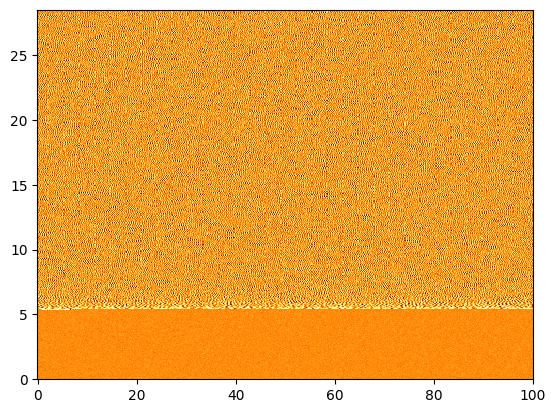

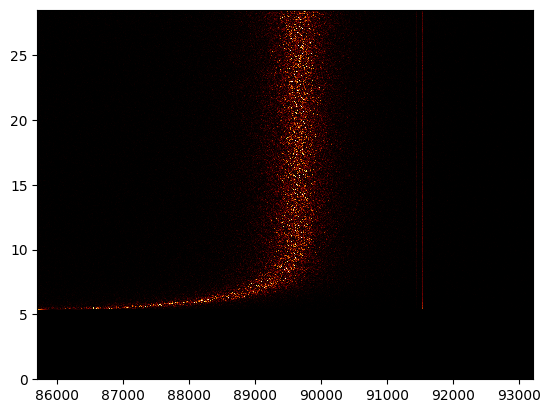

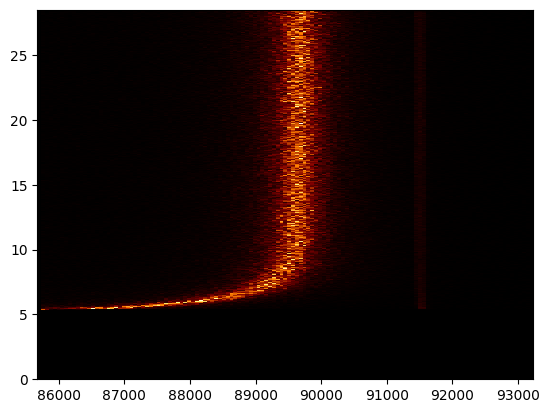

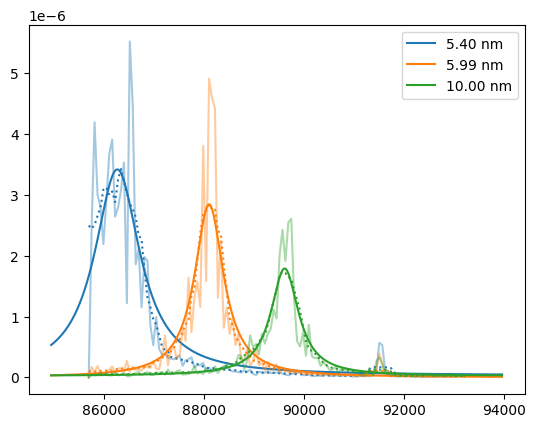

FigureWidget({
    'data': [{'hovertemplate': 'Z=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': '',
              'line': {'color': 'blue', 'dash': 'solid'},
              'marker': {'size': 1, 'symbol': 'circle'},
              'mode': 'lines',
              'name': '',
              'showlegend': False,
              'type': 'scattergl',
              'uid': '0540440c-371f-40d7-aad8-ef12e0e25286',
              'x': array([-0.00000000e+00,  2.78592375e-02,  5.57184751e-02, ...,  2.84442815e+01,
                           2.84721408e+01,  2.85000000e+01]),
              'xaxis': 'x',
              'y': array([          nan,           nan,           nan, ...,  -18.09213196,
                          -101.2125    ,   12.55682394]),
              'yaxis': 'y'},
             {'hovertemplate': 'Z=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': '',
              'line': {'color': 'red', 'dash': 'solid'},
              'marker': {'size': 1, 'symbol': 'circl

Z  Normal force  Resonance frequency    Q factor        FWHM  \
0     -0.000000     -0.921326                  NaN         NaN         NaN   
1      0.027859     -0.926819                  NaN         NaN         NaN   
2      0.055718     -0.927735                  NaN         NaN         NaN   
3      0.083578     -0.936280                  NaN         NaN         NaN   
4      0.111437     -0.937500                  NaN         NaN         NaN   
...         ...           ...                  ...         ...         ...   
1019  28.388563     -1.086121            15.975000  109.335131  820.312500   
1020  28.416422     -1.085511           -13.320304  128.880426  695.681125   
1021  28.444282     -1.087952           -18.092132  120.814977  742.084388   
1022  28.472141     -1.080017          -101.212500   95.543240  937.500000   
1023  28.500000     -1.089173            12.556824  185.529293  483.403756   

          Area   Amp rms  
0          NaN  0.011537  
1          NaN  0.011337  
2          NaN  0.011316  
3          NaN  0.011593  
4          NaN  0.011431  
...        ...       ...  
1019  0.002347  0.049494  
1020  0.002586  0.053474  
1021  0.002014  0.048944  
1022  0.002755  0.050619  
1023  0.033854  0.169550  

[1024 rows x 7 columns]

In [40]:
#calculate rolling average of window n to smoooth data a
def rollavg_cumsum_edges(a,n):
    assert n%2==1
    if n == 1:
        return a
    else:
        N = len(a)
        cumsum_vec = np.cumsum(np.insert(np.pad(a,(n-1,n-1),'constant'), 0, 0)) 
        d = np.hstack((np.arange(n//2+1,n),np.ones(N-n)*n,np.arange(n,n//2,-1)))  
        return (cumsum_vec[n+n//2:-n//2+1] - cumsum_vec[n//2:-n-n//2]) / d

#find index in "a" closest to val
def find_index(a, val):
    return np.argmin(abs(a-val))

folderpath_i = '/home/pranav/Work/Data/Murcia/AFM2/20240517 thiol interdigielec old_ctd/'
filepath_i = f'{folderpath_i}/3dmode_ampz_glassonly_range15nm_0185.b.dy.ch1'
# filepath_i = f'{folderpath_i}/3dmode_ampz_thiolonly_range10nm_0182.f.dy.ch15'
spectro_data_i = wsxm_readchan(filepath_i, all_files=True, mute=False)
chan = 'Amplitude'#'Topography', 'Normal force', 'Excitation frequency', 'Amplitude'

amp_data = {}
chan_dirs = list(spectro_data_i[chan].keys())
for dir_i in chan_dirs:
    im_data_test = spectro_data_i[chan][dir_i]
    im_data_test['data']['Y'] = 1.9*im_data_test['data']['Y'] #PIEZO CALIBRATION CORRECTION! REMOVE LATER!
    xx, yy, amp_data[dir_i] = get_imgdata(im_data_test)

head_data = im_data_test['header']
print(head_data['Y scanning direction'])

zz = amp_data[chan_dirs[0]]
plt.pcolormesh(xx,-yy,zz, cmap='afmhot', vmin=-0.2, vmax=0.2) #set color range here
# plt.colorbar()
plt.show()
# plt.plot(zz.flatten())
# plt.show()


sample_rate = float(head_data['Sampling frequency'].split(' ')[0])
freq_drive = float(head_data['Resonance frequency'].split(' ')[0])
freq_array, z_pow = signal.periodogram(zz, sample_rate, scaling='density') #power spectral density
freq_array_shifted = freq_array + freq_drive
ff, yy = np.meshgrid(freq_array_shifted, -im_data_test['data']['Y'])
plt.pcolormesh(ff, yy, z_pow, cmap='afmhot', vmin=z_pow.min(), vmax=0.1*z_pow.max())
# plt.colorbar()
plt.show()

split_num = 4 #powers of 2 eg.2,4,8,16
smooth_window = 9
pts = int(zz.shape[1]/split_num)
z_pow_list = []
for i in range(split_num):
    for dir_i in chan_dirs[:2]:
        amp_i = amp_data[dir_i][:,i*pts:(i+1)*pts] 
        freq_array, z_pow = signal.periodogram(amp_i, sample_rate, scaling='density') #power spectral density
        freq_array_shifted = freq_array + freq_drive
        z_pow_list.append(z_pow)
        # print(freq_array.shape, z_pow.shape)
    
plt.show()
z_pow_mean = np.mean(z_pow_list, axis=0)
ff, yy = np.meshgrid(freq_array_shifted, -im_data_test['data']['Y'])
plt.pcolormesh(ff, yy, z_pow_mean, cmap='afmhot', vmin=z_pow_mean.min(), vmax=0.1*z_pow_mean.max())
# plt.colorbar()
plt.show()

spectro_data = spectro_data_i['Normal force']['Forward']['data']
minarg = np.argmin(spectro_data['Z'][:,0])

 #plot spectra and fit at index
z_list = [5.4, 6, 10]
z_ind_list = [find_index(-im_data_test['data']['Y'], val) for val in z_list]
    
fit_results = {'Z':[], 'Normal force':[], 'Resonance frequency': [] , 'Q factor': [], 'FWHM': [], 'Area': [], 'Amp rms': []} 
color_list = iter(sns.color_palette())
for i in range(z_pow_mean.shape[0]):
    psd_final = z_pow_mean[i,:]
    #smooth data
    psd_smooth = rollavg_cumsum_edges(psd_final, smooth_window)

    #guess = [0, 76000, 2000, 100000]
    y_guess = 0 #psd_final.min()
    f_guess = freq_array_shifted[psd_smooth.argmax()]
    w_guess = 2*np.abs(freq_array_shifted[(np.abs(psd_smooth - psd_smooth.max()/2)).argmin()]-f_guess)
    A_guess = np.pi*w_guess*psd_smooth.max()/2
    guess = [y_guess, f_guess, w_guess, A_guess] #y0,f0,w,A
    # print(guess)
    #fit
    popt, pcov = curve_fit(lorentzian, freq_array_shifted,psd_smooth,
                        p0=guess, bounds=(0,np.inf))
    #print(np.linalg.cond(pcov))
    params = ['offset','resonance freq', 'fwhm', 'area']
    fit_dict = dict(zip(params, popt))
    # fit_dict['Q factor'] = fit_dict['resonance freq']/fit_dict['fwhm']    
    if i > minarg:
        q_factor = popt[1]/popt[2]
        fit_results['Resonance frequency'].append(popt[1])
        fit_results['FWHM'].append(popt[2])
        fit_results['Area'].append(popt[3])
        fit_results['Q factor'].append(q_factor)
    else:
        fit_results['Resonance frequency'].append(np.nan)
        fit_results['FWHM'].append(np.nan)
        fit_results['Area'].append(np.nan)
        fit_results['Q factor'].append(np.nan)
    fit_results['Z'].append(-im_data_test['data']['Y'][i])
    fit_results['Normal force'].append(spectro_data['Z'][i,0])
    
    #calcualte rms amplitude for each line
    amp_list = []
    for dir_i in chan_dirs:
        amp_i = amp_data[dir_i][i,:].flatten()
        amp_list.append(amp_i)
    amp_full = np.concatenate(amp_list)
    amp_rms = np.sqrt(amp_full.dot(amp_full)/amp_full.size)
    fit_results['Amp rms'].append(amp_rms)
    
    #plot only spectra naf fits corresponding to z_list indices
    if i in z_ind_list:
        color = next(color_list)
        plt.plot(freq_array_shifted, psd_final, color=color, alpha=0.4)
        plt.plot(freq_array_shifted, psd_smooth, ':', color=color,)
        f_min, f_max = freq_array_shifted.min(), freq_array_shifted.max()
        f_ext = 0.1*(f_max-f_min)
        freq_fit_range = np.linspace(f_min-f_ext, f_max+f_ext, 100000)
        z_val = -im_data_test['data']['Y'][i]
        plt.plot(freq_fit_range,lorentzian(freq_fit_range, *popt), '-', color=color, label=f'{z_val:,.2f} nm')
        plt.legend()
        
plt.show()

fit_df = pd.DataFrame(fit_results)
fit_df['Resonance frequency'] = fit_df['Resonance frequency'] - 89673 #SHIFT FREQUENCY
fit_df_long = pd.melt(fit_df, id_vars=['Z'], value_vars=fit_df.columns.drop('Z'))
fig, _ = plotly_multiyplot(data=fit_df_long, multiy_col='variable', x='Z', y='value',
                           yvars=['Resonance frequency', 'FWHM', 'Normal force', 'Amp rms']) 
display(fig)
display(fit_df)

0 73.5561


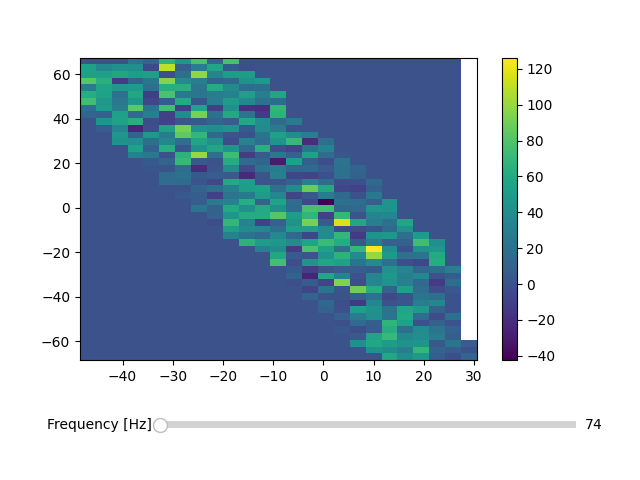

In [32]:
from matplotlib.widgets import Slider

mapa = np.loadtxt('data/Mapa3M3alargadotodo.txt')
X=mapa[1:,0]
Y=mapa[1:,1]
F = mapa[0,2:]
Z0=mapa[1:,2]
df0 = pd.DataFrame({'X':X, 'Y':Y, 'Z':Z0})
z_pivot0 = df0.pivot(index='Y', columns='X', values='Z')

x_val = z_pivot0.columns.values
y_val = z_pivot0.index.values

xx, yy = np.meshgrid(x_val,y_val)

# The parametrized function to be plotted
def update_data(frequency):
    ind = np.argmin(abs(F-frequency))
    Z=mapa[1:,ind+2]
    print(ind, frequency)
    df = pd.DataFrame({'X':X, 'Y':Y, 'Z':Z})
    z_pivot = df.pivot(index='Y', columns='X', values='Z')
    return z_pivot.values

# Create the figure and the line that we will manipulate
fig, ax = plt.subplots()
cplot = ax.pcolormesh(xx, yy, update_data(F[0]), cmap='viridis')
cbar = plt.colorbar(cplot)

fig.subplots_adjust(bottom=0.25)

# Make a horizontal slider to control the frequency.
axfreq = fig.add_axes([0.25, 0.1, 0.65, 0.03])
freq_slider = Slider(
    ax=axfreq,
    label='Frequency [Hz]',
    valmin=F.min(),
    valmax=F.max(),
    valinit=F[0],
)

def update_plot(val):
    new_z = update_data(val)
    cplot.set_array(new_z.ravel())
    
    # Manually update the color limits. Set cmin, cmax to fixed values if you don't want to update colours
    cmin, cmax = np.nanmin(new_z), np.nanmax(new_z)
    cplot.set_clim(vmin=cmin, vmax=cmax)
    
    cbar.update_normal(cplot)
    fig.canvas.draw_idle()

freq_slider.on_changed(update_plot) # register the update function with each slider

plt.show()

FigureWidget({
    'data': [{'hovertemplate': 'Z=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': '',
              'line': {'color': 'blue', 'dash': 'solid'},
              'marker': {'size': 1, 'symbol': 'circle'},
              'mode': 'lines',
              'name': '',
              'showlegend': False,
              'type': 'scattergl',
              'uid': '811e4242-2726-42fa-90d4-bc33c565c202',
              'x': array([-0.00000000e+00,  1.46627566e-02,  2.93255132e-02, ...,  1.49706745e+01,
                           1.49853372e+01,  1.50000000e+01]),
              'xaxis': 'x',
              'y': array([87052.25625   , 91505.38125   , 91446.7875    , ..., 89571.7875    ,
                          89642.10011787, 89685.73984392]),
              'yaxis': 'y'},
             {'hovertemplate': 'Z=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': '',
              'line': {'color': 'red', 'dash': 'solid'},
              'marker': {'size': 1, 'symbol': 

[-0.05386257  1.16913142]


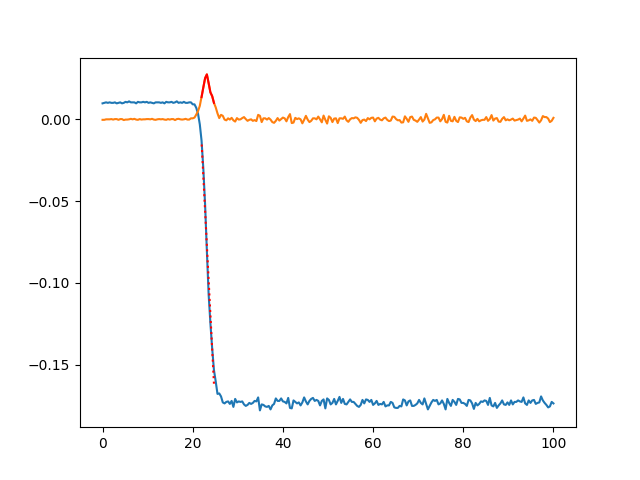

In [ ]:
# %matplotlib widget
plt.close()
file_i = 'interdigThiols_tipSi3nN_a_0003'
filepath_i = folderpath + '/' + file_df_spectro.loc[(file_df_spectro.file==file_i)].iloc[0].loc['name']
spectro_data_i = wsxm_readspectra(filepath_i, all_files=True, mute=True)
chan_i = 'Amplitude'
curv_ind = 4
segment = 'approach'
amp_data = spectro_data_i[chan_i]['curves'][curv_ind]['data']
plt.figure()
plt.plot(amp_data[segment]['x'], amp_data[segment]['y'])

amp_sobel = np.gradient(amp_data[segment]['y']) #sobel transform ndimage.sobel
plt.plot(amp_data[segment]['x'], amp_sobel)
# amp_sobel2 = ndimage.sobel(amp_sobel) #sobel transform
# plt.plot(spectro_data_chani['x'], amp_sobel2)
# plt.show()
ind_max = np.argmax(amp_sobel)
sobel_perc = np.percentile(amp_sobel, 95)
# plt.hlines(sobel_perc, 0,100)
# plt.hlines(amp_sobel[ind_max], 0,100)
# ind1 = ind_max+np.argmin(abs(amp_sobel[ind_max:]-sobel_perc))
# plt.vlines(spectro_data_chani['x'][ind1], -0.1,0.05)

kmeans = KMeans(n_clusters=2) # Create a KMeans instance with 2 clusters: kmeans
kmeans.fit(amp_sobel.reshape(-1, 1)) 
centroids = kmeans.cluster_centers_
low_cluster, high_cluster = (0, 1) if centroids[0] < centroids[1] else (1, 0) #Get higher value clusters
labels = kmeans.labels_
high_cluster_data = amp_sobel[labels == high_cluster]
high_cluster_indices = np.where(labels.reshape(amp_sobel.shape) == high_cluster)[0]

plt.plot(amp_data[segment]['x'][high_cluster_indices], amp_sobel[high_cluster_indices], 'r')

p, res, rank, sing, rcond = np.polyfit(amp_data[segment]['x'][high_cluster_indices],
                                       amp_data[segment]['y'][high_cluster_indices], 1, full=True)
poly = np.poly1d(p)
fit_data = {'x': amp_data[segment]['x'][high_cluster_indices], 'y': poly(amp_data[segment]['x'][high_cluster_indices])}
plt.plot(fit_data['x'], fit_data['y'], ':r')
print(p)
# slop_max = amp_sobel[ind_max]
# poly = np.poly1d([-slop_max,1.25])
# plt.plot(spectro_data_chani['x'][high_cluster_indices], poly(spectro_data_chani['x'][high_cluster_indices]), 'r')

In [ ]:
#dashboard 4: Spectroscopy data viewer


#close dashboard-4 figure if already open
for fignum_i in plt.get_fignums():
    figlab_i = plt.figure(fignum_i).get_label()
    if figlab_i == 'dash4':
        plt.close(figlab_i) 
    
fig4, ax4 = plt.subplots(1,1, figsize=(10.5,4), num='dash4',layout='constrained')
ax2_spec = [ax2[1], ax2[1].twinx(), ax2[1].twinx()]
ax2_spec[-1].spines['right'].set_position(('axes', 1.3))
fig2.canvas.header_visible = False
fig2.canvas.toolbar_position = 'bottom'

#topography
xx, yy, zz = get_imgdata(data_dict['Topography'][f'Image {img_dir} with Forward Ramps'])
vmin, vmax = zz.min(), zz.max()
pmesh_top2 = ax2[0].pcolormesh(xx,yy,zz, cmap='afmhot',vmin=chan_mins['Topography'],
                                vmax=chan_maxs['Topography'])
cb_top2 = plt.colorbar(pmesh_top2, ax=ax2[0])

#spectroscopy
spec_dir = 'approach'
color_list = sns.color_palette()
spec_line2 = {}
for i, channel in enumerate(chan_list):
    spectro_data = wsxm_getspectro(data_dict, channel=channel, img_dir=img_dir)
    df_spectro, data_param = wsxm_calcspectroparam(spectro_data, channel)
    df_spectro['channel'] = channel
    df_spectro_filt = df_spectro[df_spectro['segment'].isin([spec_dir])].reset_index(drop=True) #filter to selected direction
    spec_line2[channel] = sns.lineplot(data=df_spectro_filt, x="x", y="y", ax=ax2_spec[i], color=color_list[i])
    ax2_spec[i].set_ylabel(channel)
    ax2_spec[i].yaxis.label.set_color(color_list[i])
    ax2_spec[i].tick_params(axis='y', colors=color_list[i]) 

ax2_spec[0].set_xlabel('Z')

#position lines on topo
line_h2 = ax2[0].axhline(ymin, xmin, xmax, linestyle='solid', color='r')
line_v2 = ax2[0].axvline(xmin, ymin, ymax, linestyle='solid', color='r')
# plt.tight_layout()

#widgets
slide_x2 = widgets.IntSlider(value=xmin, min=xmin, max=xmax, step=(xmax-xmin)/x_num,
                            description='x')
slide_y2 = widgets.IntSlider(value=ymin, min=ymin, max=ymax, step=(ymax-ymin)/y_num,
                            description='y')
slide_zrange2 = widgets.IntSlider(value=zmax, min=zmin, max=zmax, step=(zmax-zmin)/z_num,
                            description='z limit')
slide_cb2 = widgets.FloatRangeSlider(value=[vmin, vmax], min=vmin, max=vmax,
                                     step=(vmax-vmin)/100, description='color',readout=True)
specdir_button2 = widgets.ToggleButtons(options=['approach', 'retract'], #CHANGE TO MULTIPLE SELECT!
                                    # description='Channel:',
                                     disabled=False)
imgdir_button2 = widgets.ToggleButtons(options=['Forward', 'Backward'],
                                    # description='Channel:',
                                     disabled=False)
param_dropdown2 = widgets.Dropdown(options=param_list,
                                  value='Topography',disabled=False)
dash2_output = widgets.Output()
dash2_box1 = widgets.VBox([slide_x2, slide_y2, slide_zrange2, slide_cb2])
dash2_box2 = widgets.VBox([param_dropdown2, imgdir_button2])
dash2_box3 = widgets.VBox([specdir_button2])

#update functions

@dash2_output.capture()
def dash2_update_x(change):
    img_dir = imgdir_button2.value
    spec_dir = specdir_button2.value
    x_pt = change.new
    y_pt = slide_y2.value

    # df_spectro_list, data_param_dict = [], {}
    for i, channel in enumerate(chan_list):
        spectro_data = wsxm_getspectro(data_dict, channel=channel, img_dir=img_dir, x=x_pt, y= y_pt)
        df_spectro, data_param = wsxm_calcspectroparam(spectro_data, channel)
        df_spectro['channel'] = channel
        df_spectro_filt = df_spectro[df_spectro['segment'].isin([spec_dir])].reset_index(drop=True) #filter to selected direction
        spec_line2[channel].get_lines()[0].set_data(df_spectro_filt['x'],df_spectro_filt['y'])
        ax2_spec[i].set_ylim(df_spectro_filt['y'].min(), df_spectro_filt['y'].max())
    line_v2.set_xdata([x_pt]) #vertical line on topo
    fig2.canvas.draw()

@dash2_output.capture()
def dash2_update_y(change):
    img_dir = imgdir_button2.value
    spec_dir = specdir_button2.value
    x_pt = slide_x2.value
    y_pt = change.new
    
    # df_spectro_list, data_param_dict = [], {}
    for i, channel in enumerate(chan_list):
        spectro_data = wsxm_getspectro(data_dict, channel=channel, img_dir=img_dir, x=x_pt, y= y_pt)
        df_spectro, data_param = wsxm_calcspectroparam(spectro_data, channel)
        df_spectro['channel'] = channel
        df_spectro_filt = df_spectro[df_spectro['segment'].isin([spec_dir])].reset_index(drop=True) #filter to selected direction
        spec_line2[channel].get_lines()[0].set_data(df_spectro_filt['x'],df_spectro_filt['y'])
        ax2_spec[i].set_ylim(df_spectro_filt['y'].min(), df_spectro_filt['y'].max())
    line_h2.set_ydata([y_pt]) #horizontal line on topo
    fig2.canvas.draw()

@dash2_output.capture()
def dash2_update_zrange(change):
    z_new = change.new
    for i, channel in enumerate(chan_list):
        ax2_spec[i].set_xlim(zmin, z_new)

@dash2_output.capture()
def dash2_update_param(change):
    img_dir = imgdir_button2.value
    if change.new == 'Topography':
        xx, yy, zz = get_imgdata(data_dict[change.new][f'Image {img_dir} with Forward Ramps'])
    else:
        xx, yy, zz = get_imgdata(param_data_dict[change.new][imgdir_button2.value])
    pmesh_top2.set_array(zz)
    vmin, vmax = zz.min(), zz.max()
    pmesh_top2.set_clim(vmin, vmax)
    cb_top2.mappable.set_clim(vmin, vmax)
    fig2.canvas.draw()

    #reinitialize colorbar to new values of channel(works somehow)
    slide_cb2.unobserve(dash2_update_colorbar, 'value')
    slide_cb2.min, slide_cb2.max = -1e100, 1e100 #to avoid error of min, max classh from previous value
    slide_cb2.step = (vmax-vmin)/100
    slide_cb2.value = (vmin, vmax)
    # slide_cb.min, slide_cb.max = chan_mins[channel], chan_maxs[channel]
    slide_cb2.observe(dash2_update_colorbar, 'value')

@dash2_output.capture()
def dash2_update_imgdir(change):
    img_dir = change.new
    x_pt = slide_x2.value
    y_pt = slide_y2.value
    spec_dir = specdir_button2.value
    vmin, vmax = slide_cb2.value
    
    if param_dropdown2.value == 'Topography':
        xx, yy, zz = get_imgdata(data_dict[param_dropdown2.value][f'Image {img_dir} with Forward Ramps'])
    else:
        xx, yy, zz = get_imgdata(param_data_dict[param_dropdown2.value][img_dir])
    pmesh_top2.set_array(zz)
    pmesh_top2.set_clim(vmin,vmax)

    # df_spectro_list, data_param_dict = [], {}
    for i, channel in enumerate(chan_list):
        spectro_data = wsxm_getspectro(data_dict, channel=channel, img_dir=img_dir, x=x_pt, y= y_pt)
        df_spectro, data_param = wsxm_calcspectroparam(spectro_data, channel)
        df_spectro['channel'] = channel
        df_spectro_filt = df_spectro[df_spectro['segment'].isin([spec_dir])].reset_index(drop=True) #filter to selected direction
        spec_line2[channel].get_lines()[0].set_data(df_spectro_filt['x'],df_spectro_filt['y'])
        ax2_spec[i].set_ylim(df_spectro_filt['y'].min(), df_spectro_filt['y'].max())
    fig2.canvas.draw()

@dash2_output.capture()
def dash2_update_specdir(change):
    img_dir = imgdir_button2.value
    x_pt = slide_x2.value
    y_pt = slide_y2.value
    spec_dir = change.new

    # df_spectro_list, data_param_dict = [], {}
    for i, channel in enumerate(chan_list):
        spectro_data = wsxm_getspectro(data_dict, channel=channel, img_dir=img_dir, x=x_pt, y= y_pt)
        df_spectro, data_param = wsxm_calcspectroparam(spectro_data, channel)
        df_spectro['channel'] = channel
        df_spectro_filt = df_spectro[df_spectro['segment'].isin([spec_dir])].reset_index(drop=True) #filter to selected direction
        spec_line2[channel].get_lines()[0].set_data(df_spectro_filt['x'],df_spectro_filt['y'])
        ax2_spec[i].set_ylim(df_spectro_filt['y'].min(), df_spectro_filt['y'].max())
    fig2.canvas.draw()

@dash2_output.capture()
def dash2_update_colorbar(change):
    vmin, vmax = change.new
    img_dir = imgdir_button2.value
    if param_dropdown2.value == 'Topography':
        xx, yy, zz = get_imgdata(data_dict[param_dropdown2.value][f'Image {img_dir} with Forward Ramps'])
    else:
        xx, yy, zz = get_imgdata(param_data_dict[param_dropdown2.value][img_dir])
    
    if slide_cb2.min != zz.min() or  slide_cb2.max != zz.max():
        #slider reset to channel values
        vmin, vmax = zz.min(), zz.max()
        slide_cb2.unobserve(dash2_update_colorbar, 'value')
        slide_cb2.min, slide_cb2.max = -1e100, 1e100 #to avoid error of min, max classh from previous value
        slide_cb2.min, slide_cb2.max = vmin, vmax
        slide_cb2.step = (vmin - vmax)/100
        slide_cb2.value = (vmin, vmax)
        slide_cb2.observe(dash2_update_colorbar, 'value')
    else:
        pmesh_top2.set_clim(vmin, vmax)
        cb_top2.mappable.set_clim(vmin, vmax)
        fig2.canvas.draw()

#update x,y cordinates by clicking inside the plot
@dash2_output.capture()
def dash2_onclick(event):
    if event.inaxes == ax2[0]:
        slide_x2.value = event.xdata
        slide_y2.value = event.ydata

# @dash2_output.capture()
# def response(change):
#     print(change)
     
slide_x2.observe(dash2_update_x, 'value')
slide_y2.observe(dash2_update_y, 'value')
slide_zrange2.observe(dash2_update_zrange, 'value')
slide_cb2.observe(dash2_update_colorbar,'value')
param_dropdown2.observe(dash2_update_param, 'value')
imgdir_button2.observe(dash2_update_imgdir, 'value')
specdir_button2.observe(dash2_update_specdir, 'value')
dash2_cid = fig2.canvas.mpl_connect('button_press_event', dash2_onclick)

display(dash2_box1)
display(dash2_box2)
display(dash2_box3)
display(dash2_output)

dict_keys(['Excitation frequency', 'Phase'])
dict_keys(['approach', 'retract'])


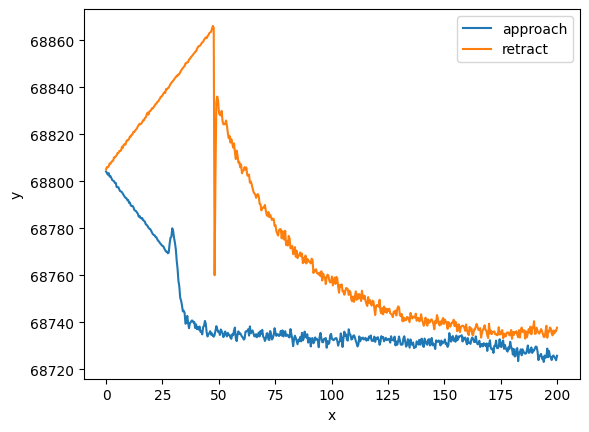

In [ ]:
filepath = 'data/interdigThiols_tipSi3nN_b_0023_Excitation frequency.f.curves'
# filepath = 'data/interdigThiolsHeated_tipNweSi3nN_a_0031_Excitation frequency.f.stp'
test_data = wsxm_readcurves(filepath)
print(test_data.keys())
test_chan = 'Excitation frequency' #'Normal force', 'Amplitude', 'Excitation frequency', 'Phase'
curv_num = 1
print(test_data[test_chan]['curves'][curv_num]['data'].keys())

spectro_data = test_data[test_chan]['curves'][curv_num]['data']
test_spectro, test_param = wsxm_calcspectroparam(spectro_data, test_chan)
# print(test_param)
fig, ax = plt.subplots()
sns.lineplot(data=test_spectro, x="x", y="y", hue="segment", ax=ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels) #remove legend title

#show calculations in plot for checking
# plt.hlines(test_param['Adhesion']['zero'], test_spectro['x'].min(), 
#            test_spectro['x'].max(), linestyles='dashed', colors='r')
# plt.hlines(test_param['Adhesion']['min'], test_spectro['x'].min(), 
#            test_spectro['x'].max(), linestyles='dashed', colors='r')
# plt.plot(test_param['Snap-in distance']['x'], test_param['Snap-in distance']['y'],
#          'r', linestyle='solid',linewidth=2)
# plt.plot(test_param['Stiffness']['x'], test_param['Stiffness']['y'],
#          'r', linestyle='solid',linewidth=2)

plt.show()
# test_data[test_chan]['curves'][curv_num]['header']
# print(test_spectro.max())
# test_spectro

1 interdigThiols_tipSi3nN_b_0030.b.dy.top
2 interdigThiols_tipSi3nN_b_0030.f.dy.ch1
3 interdigThiols_tipSi3nN_b_0030.b.dy.ch12
4 interdigThiols_tipSi3nN_b_0030.f.dy.ch15
5 interdigThiols_tipSi3nN_b_0030.b.dy.ch15
6 interdigThiols_tipSi3nN_b_0030.f.dy.ch12
7 interdigThiols_tipSi3nN_b_0030.b.dy.ch1
8 interdigThiols_tipSi3nN_b_0030.f.dy.top


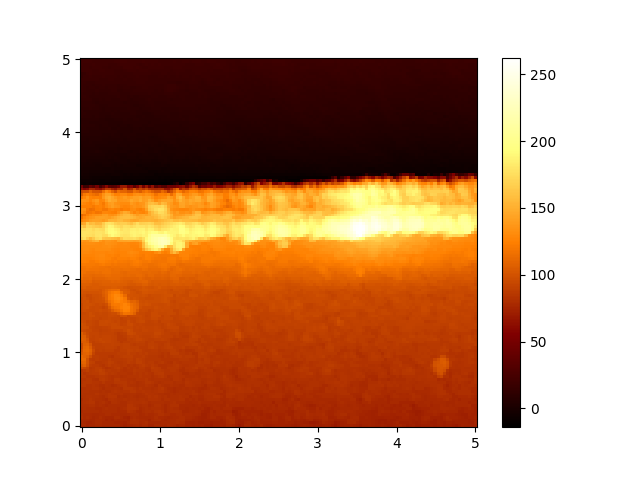

-14.062525423728813 262.5004745762712


In [25]:
# plt.close()
filepath = 'data/interdigThiols_tipSi3nN_b_0030.b.dy.top'
test_data = wsxm_readchan(filepath, all_files=True)
test_chan = 'Topography'#'Topography', 'Normal force', 'Excitation frequency', 'Amplitude'
test_dir = 'Backward'
im_data_test = test_data[test_chan][test_dir]
# xx = im_data_test['X'].reshape(128,128)
# yy = im_data_test['Y'].reshape(128,128)
# zz = im_data_test['Z'].reshape(128,128)
xx, yy, zz = get_imgdata(im_data_test)
plt.pcolormesh(xx,yy,zz, cmap='afmhot')
plt.colorbar()
plt.show()
print(zz.min(), zz.max())
# test_data.keys()
# test_data[test_chan][test_dir]['header']

-65.82043713017751 198.24256286982248 264.063


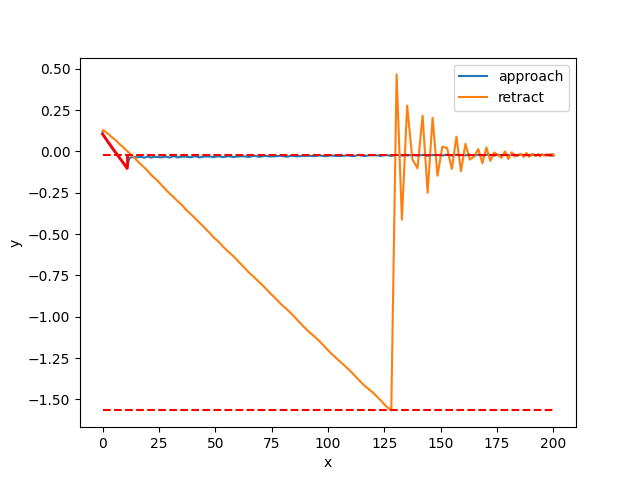

TypeError: descriptor 'remove' for 'list' objects doesn't apply to a 'str' object

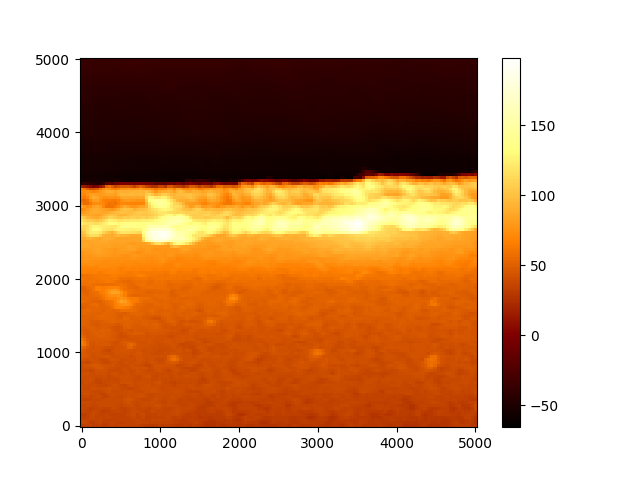

In [7]:
channel = 'Topography' #'Excitation frequency', 'Normal force', 'Amplitude', 'Topography'
chan_dir = 'Image Forward with Backward Ramps' #'Image Forward with Forward Ramps', 'Image Backward with Backward Ramps', 'Image Backward with Forward Ramps', 'Image Forward with Backward Ramps'
img_dir = chan_dir.split(' ')[1]
data_dict_chan = data_dict[channel][chan_dir]
# im_data = data_dict_chan['data']
header_dict = data_dict_chan['header']
x_num = int(header_dict['Number of rows'])
y_num = int(header_dict['Number of rows'])
chan_list = data_dict.keys()

pt_x, pt_y, pt_z = 1, 120, 0
style = 'XY'

# test_data = wsxm_readcurves(filepath)
#plot AFM Z image
# im_data = test_data['Channel']['data']
xx, yy, zz = get_imgdata(data_dict_chan, style, pt_x, pt_y, pt_z) #im_data['X'].reshape(128,128)
# yy = im_data['Y'].reshape(128,128)
# zz = data_dict_chan['data']['Z'] #im_data['Z'].reshape(128,128)
# zz = data_dict_chan['data']['ZZ'][pt_z,:,:]#1st index:xy sections, 2nd index:xz sections, 3rd index: yz sections

#TODO: change and check how forward backward in z (or x) can be consistently plotted
print(zz.min(),zz.max(), zz.max()-zz.min())
plt.figure()
plt.pcolormesh(xx,yy,zz, cmap='afmhot')
plt.colorbar()

# if header_dict['Spectroscopy direction'] == 'Forward': #CHECK THIS
#     segment
#obtain and plot spectroscopy data
chan_spectro = 'Normal force'
# spec_params = ['Adhesion', 'Snap-in distance', 'Stiffness'] #check keys of FUNC_DICT
#CHECK x and y in all functions!!!
spectro_data = wsxm_getspectro(data_dict, channel=chan_spectro,
                               img_dir=img_dir, x=pt_x, y=pt_y)
df_spectro, data_param = wsxm_calcspectroparam(spectro_data, chan_spectro)

# print(fd)
fig, ax = plt.subplots()
sns.lineplot(data=df_spectro, x="x", y="y", hue="segment", ax=ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels) #remove legend title

#show calculations in plot for checking
plt.hlines(data_param['Adhesion']['zero'], df_spectro['x'].min(), 
           df_spectro['x'].max(), linestyles='dashed', colors='r')
plt.hlines(data_param['Adhesion']['min'], df_spectro['x'].min(), 
           df_spectro['x'].max(), linestyles='dashed', colors='r')
plt.plot(data_param['Snap-in distance']['x'], data_param['Snap-in distance']['y'],
         'r', linestyle='solid',linewidth=2)
plt.plot(data_param['Stiffness']['x'], data_param['Stiffness']['y'],
         'r', linestyle='solid',linewidth=2)
# acq_pt = test_data['Curves'][3]['header']['Acquisition point'].strip('()').split(',')
# plt.scatter(float(acq_pt[0]), float(acq_pt[1]),color = 'green')
plt.show()
# header_dict
# #plot Curves
# test_df = pd.DataFrame.from_dict(test_data['Curves'][3]['data'])
# sns.lineplot(data=test_df, x="Z", y="Excitation frequency", hue="Segment")
# plt.show()

# spec_params = ['Adhesion', 'Snap-in distance', 'Stiffness'] #check keys of FUNC_DICT
img_specparams = calc_spectro_prop(data_dict, chan_spectro, img_dir)
img_adh = img_specparams['Snap-in distance']
plt.pcolormesh(xx,yy,img_adh, cmap='afmhot',vmin=None, vmax=0.08)
plt.colorbar()
#plot histogram of parameter
plt.figure()
sns.histplot(img_adh.flatten(),binrange=(0,0.08))
plt.show()
# header_dict

In [6]:
128*128

16384

{'Image header size': '3031', 'Angle': '0', 'Set Point': '-9 V', 'Signal Gain': '1', 'Topography Bias': '0 mV', 'X Amplitude': '1 nm', 'X Offset': '0 nm', 'X-Frequency': '58.594 Hz', 'XY Gain': '0.0588235', 'Y Amplitude': '1 nm', 'Y Offset': '-451.813 nm', 'Z Gain': '10', 'Z Offset': '0 nm', 'Amplitude': '1e-006 V', 'Bandwidth': '445.626', 'Filter Out': '8079 Hz', 'Frq. Scan Sensitivity': '0.024 kHz/V', 'Gain in': '100', 'Gain out X': '2', 'Gain out Y': '2', 'Phase': '52.9998 Deg', 'Quality factor (Q)': '171.177', 'Resonance frequency': '72293.6 Hz', 'Input channel': 'Amplitude', 'Integral': '2.5', 'Proportional': '10', 'Tilt X': '0 nm/nm', 'Tilt Y': '0 nm/nm', 'Acquisition channel': 'Amplitude', 'Acquisition primary channel': 'Channel 15', 'Channel is inverted': 'No', 'Conversion Factor 00': '10 nm', 'Conversion Offset 00': '0 nm', 'Force constant': '165.73 N/m', 'Head type': 'AFM', 'Image Data Type': 'short', 'Number of columns': '128', 'Number of rows': '128', 'Round percent': '10',

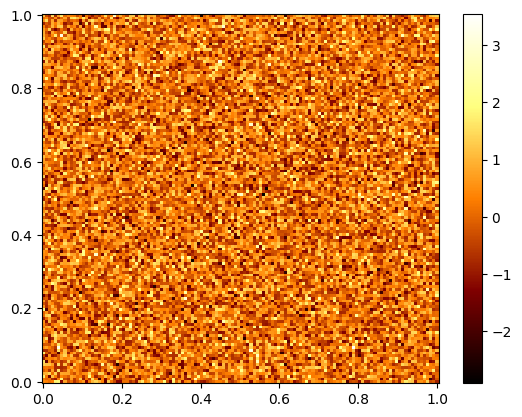

{'Image header size': '3037', 'Angle': '0', 'Set Point': '-9 V', 'Signal Gain': '1', 'Topography Bias': '0 mV', 'X Amplitude': '1 nm', 'X Offset': '0 nm', 'X-Frequency': '58.594 Hz', 'XY Gain': '0.0588235', 'Y Amplitude': '1 nm', 'Y Offset': '-451.813 nm', 'Z Gain': '10', 'Z Offset': '0 nm', 'Amplitude': '1e-006 V', 'Bandwidth': '445.626', 'Filter Out': '8079 Hz', 'Frq. Scan Sensitivity': '0.024 kHz/V', 'Gain in': '100', 'Gain out X': '2', 'Gain out Y': '2', 'Phase': '52.9998 Deg', 'Quality factor (Q)': '171.177', 'Resonance frequency': '72293.6 Hz', 'Input channel': 'Amplitude', 'Integral': '2.5', 'Proportional': '10', 'Tilt X': '0 nm/nm', 'Tilt Y': '0 nm/nm', 'Acquisition channel': 'Amplitude', 'Acquisition primary channel': 'Channel 15', 'Channel is inverted': 'No', 'Conversion Factor 00': '10 nm', 'Conversion Offset 00': '0 nm', 'Force constant': '165.73 N/m', 'Head type': 'AFM', 'Image Data Type': 'short', 'Number of columns': '128', 'Number of rows': '128', 'Round percent': '10',

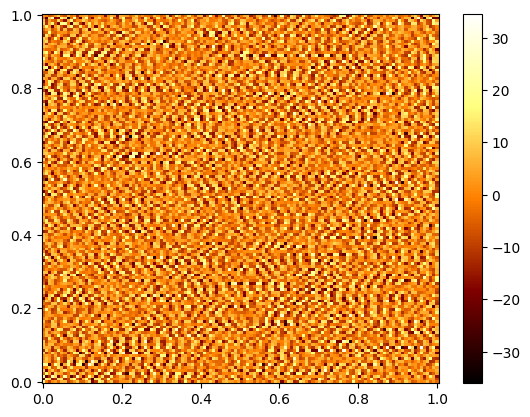

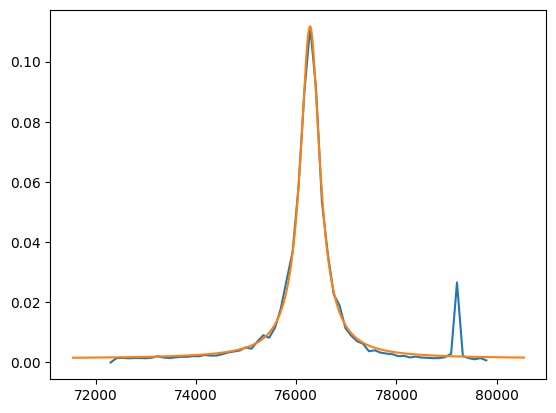

{'offset': 0.0012934139192533319, 'resonance freq': 76274.15433510602, 'fwhm': 473.8767061692985, 'area': 82.11451304229297, 'Q factor': 160.9578047245397}


In [2]:
files = ['data/20240202_laser_off_128pts_58lps_0002.f.dy.ch15', 
         'data/20240202_laser_on_128pts_58lps_0003.f.dy.ch15']
data_dict = {}
rms_min = np.inf
for file in files:
    data_dict[file] = {}
    data_dict[file]['Frequency'], data_dict[file]['PSD'], data_dict[file]['Z rms'] = get_psd(file)
    if data_dict[file]['Z rms'] < rms_min:
        rms_min = data_dict[file]['Z rms']
        off_file = file

on_file = [n for n in files if n != off_file][0]
data_dict[off_file]['Label'] = 'Laser ON'
data_dict[on_file]['Label'] = 'Laser OFF'

#plot data images
# for file in files:
#     plt.plot(data_dict[file]['Frequency'], data_dict[file]['PSD'], label = data_dict[file]['PSD'])
# plt.show()
    

#z_pow = 2*(z_fftx_avg[64:]**2)/(15000*128)
#freq_drive = float(head_data['Resonance frequency'].split(' ')[0])
#freq_array_real = freq_array_shift[64:] + freq_drive
freq_final = data_dict[on_file]['Frequency']
psd_final = data_dict[on_file]['PSD'] - data_dict[off_file]['PSD']
plt.plot(freq_final, psd_final)
#plt.show()

#guess = [0, 76000, 2000, 100000]
y_guess = psd_final.min()
f_guess = freq_final[psd_final.argmax()]
w_guess = 2*np.abs(freq_final[(np.abs(psd_final - psd_final.max()/2)).argmin()]-f_guess)
A_guess = np.pi*w_guess*psd_final.max()/2
guess = [y_guess, f_guess, w_guess, A_guess] #y0,f0,w,A
#fit
popt, pcov = curve_fit(lorentzian, freq_final,psd_final,
                    p0=guess, bounds=(0,np.inf))
#print(np.linalg.cond(pcov))
params = ['offset','resonance freq', 'fwhm', 'area']
fit_dict = dict(zip(params, popt))
fit_dict['Q factor'] = fit_dict['resonance freq']/fit_dict['fwhm']

#plot fit
f_min, f_max = freq_final.min(), freq_final.max()
f_ext = 0.1*(f_max-f_min)
freq_fit_range = np.linspace(f_min-f_ext, f_max+f_ext, 100000)
plt.plot(freq_fit_range,lorentzian(freq_fit_range, *popt))
plt.show()

print(fit_dict)

In [37]:
# Q = head_data['Quality factor (Q)']
k_cant = 2 # N/m
T = 300 #K
kb = 1.380649e-23 #J/K
V_rms = np.sqrt(fit_dict['area'])
corr_fac = 4/3 #Butt-Jaschke correction for thermal noise
sens = np.sqrt(corr_fac*kb*T/k_cant)/V_rms/1e-9 #nm/V 
print(V_rms, sens)
print(np.sqrt(data_dict[on_file]['Z rms']**2 - data_dict[off_file]['Z rms']**2))
# z = im_data['Z']
# print(np.sqrt(z.dot(z)/z.size))

9.061705857193388 0.005798914136715741
9.421556156513725


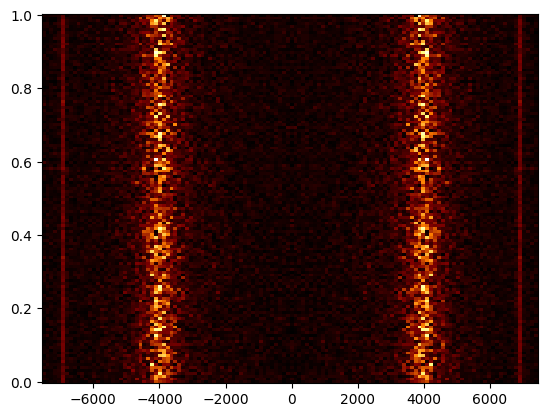

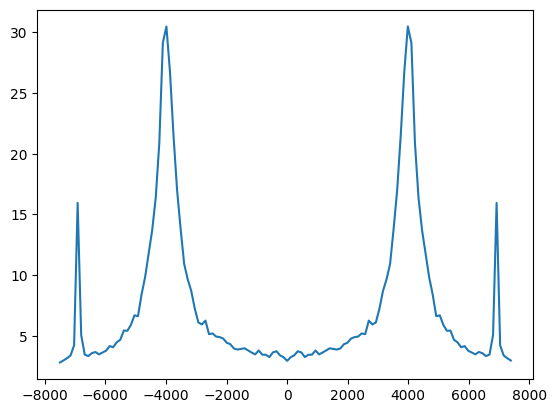

In [6]:
# #1D Fourier Transform of image and average along Y axis.
# z_fftx = np.abs(np.fft.fft(zz))
# z_fftx_shift = np.fft.fftshift(z_fftx)
# z_fftx_avg = np.average(z_fftx_shift, axis=0)

# num_pts = len(z_fftx_avg)
# sample_rate = 2*num_pts*float(head_data['X-Frequency'].split(' ')[0])
# freq_array = np.fft.fftfreq(len(z_fftx_avg), 1 / sample_rate)
# freq_array_shift = np.fft.fftshift(freq_array)
# ff, _ = np.meshgrid(freq_array_shift, freq_array_shift)
# plt.pcolormesh(ff, yy, z_fftx_shift, cmap='afmhot')
# plt.show()
# plt.plot(freq_array_shift, z_fftx_avg)
# plt.show()